# Load Packages

In [22]:
%pylab inline
import pandas as pd
import xarray as xr
from os import chdir
from os.path import join
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
from matplotlib.ticker import PercentFormatter
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import glob
from tqdm import tqdm
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
from scipy.stats import normaltest, wasserstein_distance, zscore, gaussian_kde
from pymannkendall import original_test
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
import warnings

mpl.rcParams['figure.facecolor'] = '1'
font = {'family' : 'Sans Serif',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)
mpl.rcParams['mathtext.default'] = 'regular'

# Change directory information for user
root_dir = '/Users/tommyrk/Library/CloudStorage/Dropbox/Papers - Current/Global NPP Trends Paper'
datadir = root_dir+'/DATA'
figdir = root_dir+'/FIGURES'

# Acronyms for the Fay & McKinley 2014 biomes
bname = ['NP ICE', 'NP SPSS', 'NP STSS', 'NP STPS', 'PEQU W', 'PEQU E', 'SP STPS',
         'NA ICE', 'NA SPSS', 'NA STSS', 'NA STPS', 'AEQU', 'SA STPS', 'IND STPS', 
         'SO STSS', 'SO SPSS', 'SO ICE', 'GLOBAL']

# Names of Earth system models used in the analysis
models = ['ACCESS-ESM1-5', 'CESM2-WACCM', 'CESM2', 'CMCC-ESM2',
       'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3-CC',
       'GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM',
       'UKESM1-0-LL']

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/tommyrk/opt/anaconda3/envs/pyth_env/lib/python3.12/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Download Data for Analysis

All the remote sensing NPP data can be downloaded from here:

[Eppley-VGPM, Behrenfeld-VGPM, Behrenfeld-CbPM, Westberry-CbPM, Silsbe-CAFE](https://zenodo.org/records/10829966)

[Lee-AbPM](https://zenodo.org/records/11174556)

All of the remote sensing driver data can be downloaded from here:

SST, Chl-a, MLDmin, MLDmax

All of the Earth System Model data can be downloaded from here:

NPP, SST, Chl-a, MLDmin, MLDmax

# Figure 1

Here we calculate the historical, contemporary and future mean-normalised NPP trends from the 15 ESMs.  

Whilst also calculating the ΔNPP (Pg C yr$^{-1}$) as the difference between (1995-2014) and (2080-2100).

## Load in data and perform calculations

In [2]:
# Constants
degrees_per_pixel = 1
km_per_degree = 111.1
m_per_km = 1000
pixel_area_equator_km2 = (degrees_per_pixel * km_per_degree) ** 2

# Function to calculate pixel area in square meters
def calculate_pixel_area(xds, km_per_degree=111.1, m_per_km=1000):
    """Calculate the pixel area in m² for the given xarray dataset."""
    degrees_per_pixel = 180 / xds.lat.shape[0]
    pixel_area_equator_km2 = (degrees_per_pixel * km_per_degree) ** 2
    lat_rad = np.radians(xds['lat'])
    pixel_area = np.cos(lat_rad) * pixel_area_equator_km2
    pixel_area_2d = pixel_area.broadcast_like(xds)
    return pixel_area_2d * m_per_km**2  # Convert to m²

# Function to perform regression analysis
def perform_regression(xds, time_slice):
    y = xds.sel(time=slice(*time_slice)).sum(['lat', 'lon']) / xds.sel(time=slice(*time_slice)).sum(['lat', 'lon']).mean()
    X = y.time.dt.year.values
    y = np.squeeze(y.values)
    mask = ~np.isnan(y)
    X, y = X[mask].reshape(-1, 1), y[mask].reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    X2 = sm.add_constant(X)
    model = sm.OLS(y, X2).fit()
    return pd.Series([reg.coef_[0][0], reg.intercept_[0], model.f_pvalue, model.rsquared, model.fvalue],
                     index=['slope', 'intercept', 'pval', 'rsq', 'fval'])

# Directories
datadir = join(root_dir, 'DATA', 'ANNUAL_MEAN_FILES', 'CMIP6_*')

# Initialize results
delta_pg_npp = []
hist_res = []
cont_res = []
futu_res = []

# Process each model
for m in models:
    fname = join(datadir, f'NPP/*_{m}_*.nc')
    flist = sorted(glob.glob(fname))
    if not flist:
        continue  # Skip model if no files found

    xds = xr.open_mfdataset(flist, combine='by_coords')
    pixel_area_m2 = calculate_pixel_area(xds.intpp)

    # Compute integrated NPP (Pg NPP per year)
    xds = ((xds.intpp / 1e3 * pixel_area_m2) * 365) * 1e-15

    # Historical period
    hist_res.append(perform_regression(xds, ('1850-01-01', '2014-12-31')))

    # Contemporary period
    cont_res.append(perform_regression(xds, ('1998-01-01', '2023-12-31')))

    # Future period
    futu_res.append(perform_regression(xds, ('2015-01-01', '2100-12-31')))

    # Delta calculation (future mean minus historical mean)
    delta = xds.sel(time=slice('2081-01-01', '2100-12-31')).mean('time') - \
            xds.sel(time=slice('1995-01-01', '2014-12-31')).mean('time')
    delta_pg_npp.append(delta.sum(['lat', 'lon']).values)


# Convert results to DataFrames
hist_res = pd.DataFrame(hist_res, columns=['slope', 'intercept', 'pval', 'rsq', 'fval'])
cont_res = pd.DataFrame(cont_res, columns=['slope', 'intercept', 'pval', 'rsq', 'fval'])
futu_res = pd.DataFrame(futu_res, columns=['slope', 'intercept', 'pval', 'rsq', 'fval'])

for df in [hist_res, cont_res, futu_res]:
    df['slope'] *= 100  # Convert to percentage change
    df['model'] = models

delta_pg_npp = pd.Series(delta_pg_npp, index=models, dtype=float)

# Combine results into summary DataFrames
df_pval = pd.concat([hist_res['pval'], cont_res['pval'], futu_res['pval']], axis=1)
df_pval.columns = ['Historical', 'Contemporary', 'Future']
df_pval.index = models

df_slope = pd.concat([hist_res['slope'], cont_res['slope'], futu_res['slope']], axis=1)
df_slope.columns = ['Historical', 'Contemporary', 'Future']
df_slope['Delta'] = delta_pg_npp.values
df_slope.index = models

# Sort and reindex results by Delta
df_slope = df_slope.sort_values('Delta')
df_pval = df_pval.reindex(df_slope.index)

print(f"Model mean±stdev ΔNPP = {delta_pg_npp.mean():.2f}±{delta_pg_npp.std():.2f} Pg C")

Model mean±stdev ΔNPP = -1.43±3.24 Pg C


## Plot the Figure

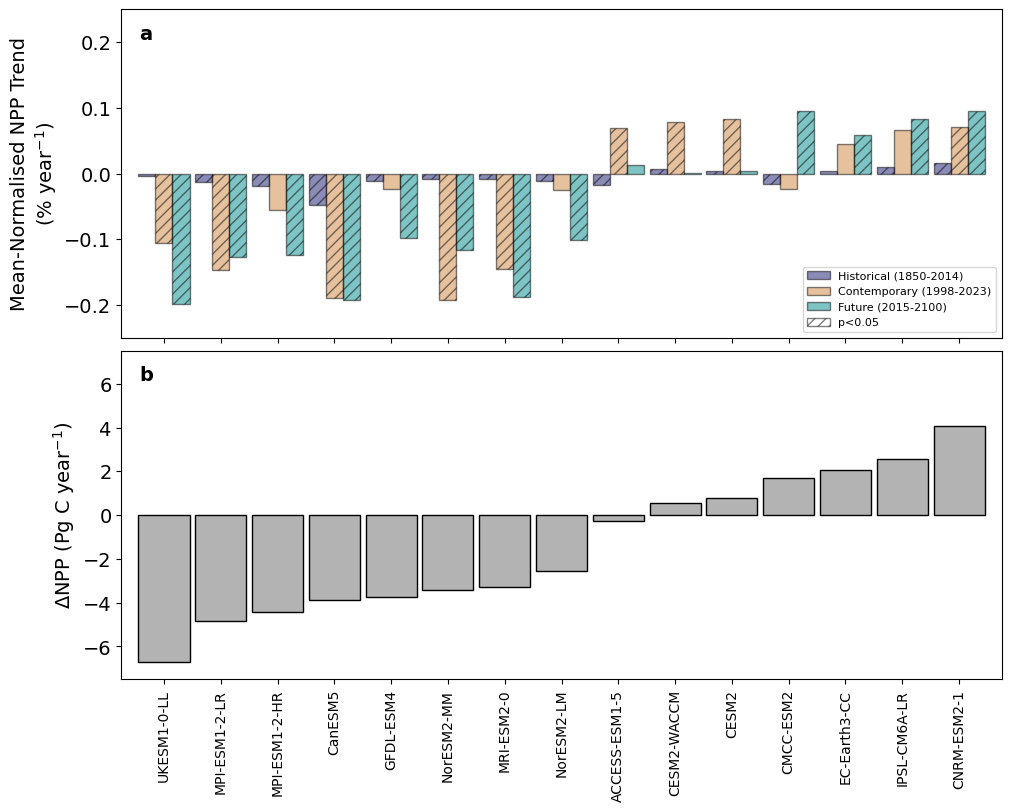

In [3]:
# Define plot settings
colors = ['midnightblue', 'peru', 'darkcyan']
bar_width = 0.3
alpha = 0.5
x = np.arange(1, 16, 1)

# Initialize the figure and subplots
fig = plt.figure(figsize=[10, 8], constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)
ax0 = fig.add_subplot(gs[:1, :])
ax1 = fig.add_subplot(gs[1:, :])

# Plot bars for Historical, Contemporary, and Future trends
categories = ['Historical', 'Contemporary', 'Future']
for i, category in enumerate(categories):
    ax0.bar(
        x + (i - 1) * bar_width,  # Offset bars
        df_slope[category],
        bar_width,
        color=colors[i],
        edgecolor='k',
        alpha=alpha,
        hatch=(df_pval[category] < 0.05).map({True: '///', False: ''})  # Add hatching for significance
    )

# Set labels, ticks, and limits for the top subplot
ax0.set_ylabel('Mean-Normalised NPP Trend\n(% year$^{-1}$)')
ax0.set_xticks(x)
ax0.set_xticklabels('')  # Hide x-tick labels for the top plot
ax0.set_ylim(-0.25, 0.25)  # Adjust as needed based on your data
ax0.set_xlim(0.25, 15.75)

# Create a legend
legend_elements = [
    Patch(facecolor=color, alpha=alpha, edgecolor='k', label=f'{category} ({years})')
    for color, category, years in zip(colors, categories, ['1850-2014', '1998-2023', '2015-2100'])
]
legend_elements.append(
    Patch(facecolor='w', alpha=alpha, edgecolor='k', hatch='///', label='p<0.05')
)
ax0.legend(handles=legend_elements, loc=4, fontsize=8)

# Plot ΔNPP in the bottom subplot
df_slope.Delta.plot.bar(
    ax=ax1,
    facecolor='0.7',
    width=0.9,
    edgecolor='k'
)

# Set labels, ticks, and limits for the bottom subplot
ax1.set_ylabel('ΔNPP (Pg C year$^{-1}$)')
ax1.set_ylim(-7.5, 7.5)  # Adjust dynamically based on data range if possible
ax1.set_xlim(-0.75, len(df_slope) - 0.25)
ax1.set_xticks(np.arange(len(df_slope)))
ax1.set_xticklabels(df_slope.index, rotation=90, fontsize=10)

# Add subplot labels
ax0.text(0.02, 0.91, 'a', transform=ax0.transAxes, fontweight='bold')
ax1.text(0.02, 0.91, 'b', transform=ax1.transAxes, fontweight='bold')

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_01"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)

# Figure S1

## Load in data and perform calculations

In [4]:
# Function to calculate pixel area in m²
def calculate_pixel_area(xds, km_per_degree=111.1, m_per_km=1000):
    degrees_per_pixel = 180 / xds.lat.shape[0]
    pixel_area_equator_km2 = (degrees_per_pixel * km_per_degree) ** 2
    lat_rad = np.radians(xds['lat'])
    pixel_area = np.cos(lat_rad) * pixel_area_equator_km2
    pixel_area_2d = pixel_area.broadcast_like(xds)
    return pixel_area_2d * m_per_km**2  # Convert to m²

# Function to process dataset and compute jackknife trends
def compute_jackknife_trends(file_path, pixel_area_m2, biomes, biome_names, segment_size=20):
    # Open dataset
    xds = xr.open_dataset(file_path)
    xds = xds * pixel_area_m2 * 365  # Scale NPP data
    xds['biomes'] = biomes.MeanBiomes
    xds = xds.set_coords('biomes')
    
    # Group by biomes and prepare DataFrame
    ds = xds.groupby('biomes', squeeze=False).mean().to_dataframe()
    ds = ds.unstack().T
    ds['mean'] = ds.mean(axis=1)
    ds.columns = biome_names
    ds = ds.droplevel(0)
    
    # Compute jackknife trends
    trends = []
    for col in ds.columns:
        for sim, start_row in enumerate(range(len(ds) - segment_size + 1)):  # Ensure no out-of-bounds
            segment = ds.iloc[start_row:start_row + segment_size]
            X = segment.index.year.values
            y = segment[col].values / segment[col].mean()
            mask = ~np.isnan(y)
            X, y = X[mask], y[mask]
            
            if len(X) < 2:  # Skip if insufficient data
                continue
            
            # Fit regression models
            X_reshaped = X.reshape(-1, 1)
            reg = LinearRegression().fit(X_reshaped, y)
            X_with_const = sm.add_constant(X_reshaped)
            model = sm.OLS(y, X_with_const).fit()
            
            # Save regression results
            trends.append({
                'biome': col,
                'sim': sim + 1,
                'slope': reg.coef_[0] * 100,
                'intercept': reg.intercept_,
                'f_pvalue': model.f_pvalue,
                'rsquared': model.rsquared,
                'fvalue': model.fvalue
            })
    return pd.DataFrame(trends)

# Main script
biome_file = f'{root_dir}/DATA/Time_Varying_Biomes_25KM.nc'
biomes = xr.open_dataset(biome_file)

# Compute pixel area
pixel_area_m2 = calculate_pixel_area(biomes.MeanBiomes)

# List of datasets and output variables
datasets = {
    'VGPM1': f'{root_dir}/DATA/ANNUAL_MEAN_FILES/REMOTE_SENSING/VGPM1_GLOBAL_ANNUAL_MEAN.nc',
    'VGPM2': f'{root_dir}/DATA/ANNUAL_MEAN_FILES/REMOTE_SENSING/VGPM2_GLOBAL_ANNUAL_MEAN.nc',
    'CBPM1': f'{root_dir}/DATA/ANNUAL_MEAN_FILES/REMOTE_SENSING/CBPM1_GLOBAL_ANNUAL_MEAN.nc',
    'CBPM2': f'{root_dir}/DATA/ANNUAL_MEAN_FILES/REMOTE_SENSING/CBPM2_GLOBAL_ANNUAL_MEAN.nc',
    'ABPM': f'{root_dir}/DATA/ANNUAL_MEAN_FILES/REMOTE_SENSING/ABPM_GLOBAL_ANNUAL_MEAN.nc', 
    'CAFE': f'{root_dir}/DATA/ANNUAL_MEAN_FILES/REMOTE_SENSING/CAFE_GLOBAL_ANNUAL_MEAN.nc'
}

# Compute trends for each dataset
results = {}
for name, file_path in datasets.items():
    results[name] = compute_jackknife_trends(file_path, pixel_area_m2, biomes, bname)

vgpm1_jn = results['VGPM1'].loc[:, ('biome', 'sim', 'slope')]
vgpm2_jn = results['VGPM2'].loc[:, ('biome', 'sim', 'slope')]
cbpm1_jn = results['CBPM1'].loc[:, ('biome', 'sim', 'slope')]
cbpm2_jn = results['CBPM2'].loc[:, ('biome', 'sim', 'slope')]
abpm_jn = results['ABPM'].loc[:, ('biome', 'sim', 'slope')]
cafe_jn = results['CAFE'].loc[:, ('biome', 'sim', 'slope')]

df_slope_jn = pd.DataFrame([vgpm1_jn.groupby('biome').slope.mean(), 
                          vgpm2_jn.groupby('biome').slope.mean(),
                          cbpm1_jn.groupby('biome').slope.mean(), 
                          cbpm2_jn.groupby('biome').slope.mean(),
                          abpm_jn.groupby('biome').slope.mean(), 
                          cafe_jn.groupby('biome').slope.mean()]).T

df_slope_jn.columns = ['Eppley-VGPM', 'Behrenfeld-VGPM', 'Behrenfeld-CbPM', 
                   'Westberry-CbPM', 'Lee-AbPM', 'Silsbe-CAFE']

df_slope_jn = df_slope_jn.reindex(bname).set_index(np.arange(1,19,1))

df_slope_jn_st = pd.DataFrame([vgpm1_jn.groupby('biome').slope.std(), 
                          vgpm2_jn.groupby('biome').slope.std(),
                          cbpm1_jn.groupby('biome').slope.std(), 
                          cbpm2_jn.groupby('biome').slope.std(),
                          abpm_jn.groupby('biome').slope.std(), 
                          cafe_jn.groupby('biome').slope.std()]).T

df_slope_jn_st.columns = ['Eppley-VGPM', 'Behrenfeld-VGPM', 'Behrenfeld-CbPM', 
                   'Westberry-CbPM', 'Lee-AbPM', 'Silsbe-CAFE']

df_slope_jn_st = df_slope_jn_st.reindex(bname).set_index(np.arange(1,19,1))

## Plot the Figure

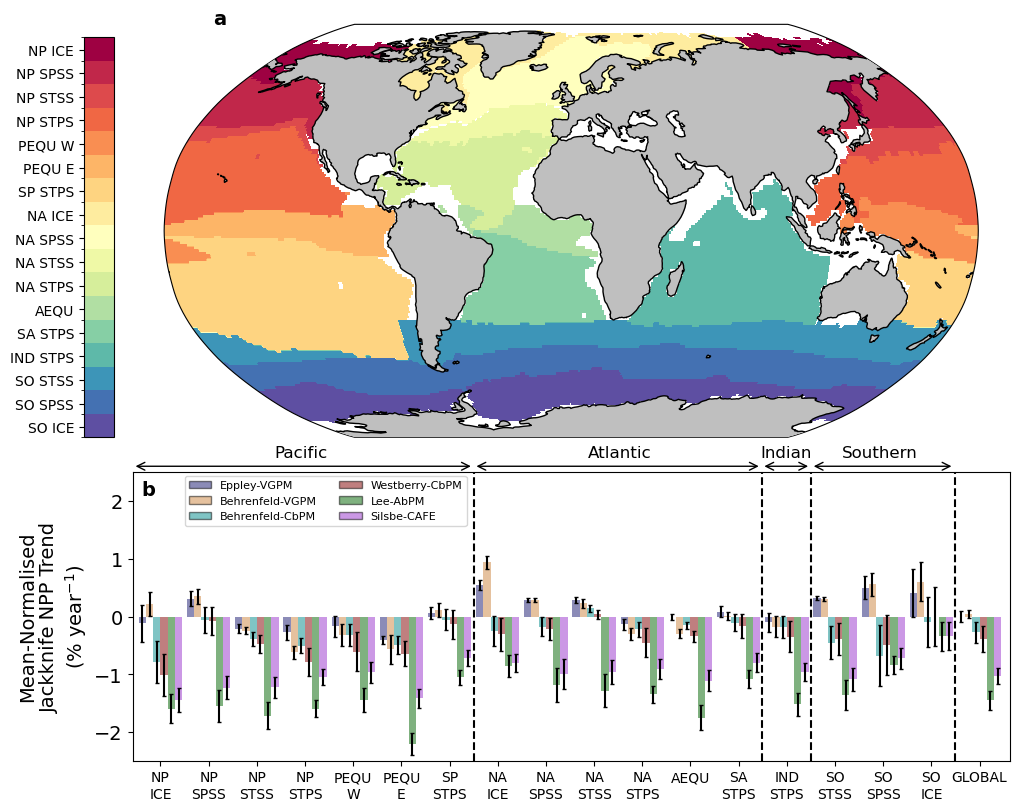

In [5]:
# Read dataset
fname = root_dir + '/DATA/Time_Varying_Biomes_25KM.nc'
biomes = xr.open_dataset(fname)

# Define color map and plot parameters
cmap = ListedColormap(plt.cm.Spectral(np.linspace(0, 1, 17)))
colors = ['midnightblue', 'peru', 'darkcyan', 'maroon', 'darkgreen', 'darkorchid']
datasets = ['Eppley-VGPM', 'Behrenfeld-VGPM', 'Behrenfeld-CbPM', 'Westberry-CbPM', 'Lee-AbPM', 'Silsbe-CAFE']

# Define the figure and layout
fig = plt.figure(figsize=[10,8], constrained_layout=True)
gs = fig.add_gridspec(2, 1, height_ratios=[1.0, 0.7])

# Create global map plot
ax0 = fig.add_subplot(gs[0, :], projection=ccrs.Robinson())
ax0.add_feature(cartopy.feature.LAND, facecolor='0.75', zorder=5)
ax0.add_feature(cartopy.feature.COASTLINE, linewidth=1, zorder=5)
ax0.set_global()

# Plot biomes data with contourf
im = biomes.MeanBiomes.plot.contourf(ax=ax0, add_colorbar=False, transform=ccrs.PlateCarree(),
                                     levels=18, vmin=1, vmax=17, cmap=cmap)

# Colorbar for the map
cbar_ax = fig.add_axes([0.07, 0.46, 0.03, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.linspace(1.5, 16.6, 17), ticklocation='left')
cbar.set_ticklabels(bname[:-1])
cbar.ax.tick_params(labelsize=10)
cbar.ax.invert_yaxis()

# Plot bar chart with error bars
ax1 = fig.add_subplot(gs[1, :])
x = np.arange(1, 19, 1)
width = 0.15

# Plotting bars and errors
def plot_bars(ax, datasets, df_slope_jn, df_slope_jn_st, colors):
    for i, dataset in enumerate(datasets):
        x1 = x + i * width
        y = df_slope_jn[dataset]
        yerr = df_slope_jn_st[dataset]
        ax.bar(x1, y, width=width, color=colors[i], alpha=0.5, label=dataset, yerr=yerr, capsize=1.5)

# Calling the bar plotting function
plot_bars(ax1, datasets, df_slope_jn, df_slope_jn_st, colors)

# Set labels and formatting for the bar plot
ax1.set_ylabel('Mean-Normalised\nJackknife NPP Trend\n(% year$^{-1}$)')
ax1.set_ylim(-2.5, 2.5)
ax1.set_xlim(0.8, 19)
ax1.set_xticks(x + width * 2.5)

# Legend for the datasets
legend_elements = [Patch(facecolor=colors[i], alpha=0.5, edgecolor='k', label=dataset) for i, dataset in enumerate(datasets)]
ax1.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.22, 0.90), fontsize=8, ncol=2)

# Custom x-tick labels
xticklabels = ['NP\nICE', 'NP\nSPSS', 'NP\nSTSS', 'NP\nSTPS', 'PEQU\nW', 'PEQU\nE', 'SP\nSTPS',
               'NA\nICE', 'NA\nSPSS', 'NA\nSTSS', 'NA\nSTPS', 'AEQU', 'SA\nSTPS', 'IND\nSTPS', 
               'SO\nSTSS', 'SO\nSPSS', 'SO\nICE', 'GLOBAL']
ax1.set_xticklabels(xticklabels, fontsize=10)

# Add vertical lines to mark regions
for x_pos in [7.875, 13.85, 14.875, 17.875]:
    ax1.axvline(x_pos, ls='--', color='k')

# Region annotations
regions = [(4.3, 'Pacific', 0.8, 7.875), (10.9, 'Atlantic', 7.875, 13.85), 
           (14.35, 'Indian', 13.85, 14.875), (16.3, 'Southern', 14.875, 17.85)]
for x_pos, label, start, end in regions:
    ax1.text(x_pos, 2.75, label, ha='center', fontsize=12)
    ax1.annotate(text='', xy=(start, 2.6), xytext=(end, 2.6), 
                 arrowprops=dict(arrowstyle='<->'), annotation_clip=False)

# Labeling for subplots
ax0.text(0.06, 1.00, 'a', fontweight='bold', transform=ax0.transAxes)
ax1.text(0.01, 0.92, 'b', fontweight='bold', transform=ax1.transAxes)

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_S01"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)

# Figure 2

## Perform Trend Analysis on Remote Sensing NPP Models

### Definition of Trend calculation function

Here we calculate the trends on a per pixel basis using either Huber-Regressor ordinary least squares regression, for normally distributed data, or Mann-Kendal Theil-Sen slopes, for non-normally distributed data.

The Huber-Regressor OLS uses an ε value of 1.35 based upon the sensitivity analysis performed in Thomalla et al. [(2023, Nature Climate Change)](https://www.nature.com/articles/s41558-023-01768-4).

Using the remote sensing data you must first resample to be as annual mean as below:

fname = 'Remote Sensing Model'

xds = xr.open_dataset(fname).sel(time=slice('1998-01-01', '2023-12-31')).resample(time='1y').mean()

This excludes data from 1997 as there is not a full year available, whilst simulataneously returning the annual mean.



In [ ]:
def normal_distribution(arr):
    
    _, pv = normaltest(arr)
    
    return pv

def mann_kendall(arr, array_len):
    
    result = original_test(arr)
    pval = result.p
    slope = result.slope
    intercept = result.intercept
    ylen = len(arr)
    x = np.arange(ylen)
    y_pred = (x * slope) + intercept
    resid_std = np.std(arr - y_pred)
    variance_score = explained_variance_score(arr, y_pred)
    mae = mean_absolute_error(arr, y_pred)
    mse = mean_squared_error(arr, y_pred)
    rmse = np.sqrt(mse)
    rae = mae/np.mean(np.abs(arr - np.mean(arr)))
    rse = mse/np.mean((arr - np.mean(arr))**2)
    
    return pval, slope, intercept, resid_std, rmse, mae, rae, rse, variance_score, ylen, 2

def robust_OLS(arr, array_len, fit_intercept):
    try:
        
        model = linear_model.HuberRegressor(fit_intercept=fit_intercept, epsilon=1.35)
        mask = ~np.isnan(arr)
        x = np.arange(array_len)[mask]
        y = arr[mask]
        X = x.reshape(-1, 1)

        model.fit(X, y)
        ol = model.outliers_
        X_clean = X[~ol]
        y_clean = y[~ol]

        # Check to see if 50% or more of grid cell is nan and return flag of 1
        if len(y_clean) <= (array_len / 2):
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 1

        X2_clean = sm.add_constant(X_clean)
        model_clean = sm.OLS(y_clean, X2_clean).fit()
        pval = model_clean.f_pvalue
        intercept = model_clean.params[0]
        slope = model_clean.params[1]
        ylen = len(y_clean)
        y_pred = (X_clean * slope) + intercept
        resid_std = np.std(y_clean - y_pred)
        variance_score = explained_variance_score(y_clean, y_pred)
        mae = mean_absolute_error(y_clean, y_pred)
        mse = mean_squared_error(y_clean, y_pred)
        rmse = np.sqrt(mse)
        rae = mae/np.mean(np.abs(y_clean - np.mean(y_clean)))
        rse = mse/np.mean((y_clean - np.mean(y_clean))**2)
        flag = 3
            
    except ValueError:
        
        pval = np.nan
        intercept = np.nan
        slope = np.nan
        resid_std = np.nan
        rmse = np.nan
        mae = np.nan
        rae = np.nan
        rse = np.nan
        variance_score = np.nan
        ylen = np.nan
        flag = -1
        
    return pval, slope, intercept, resid_std, rmse, mae, rae, rse, variance_score, ylen, flag

def combined_trends_stats(arr, array_len, fit_intercept):
    
    # Check to see if grid cell is all nan and return flag of 0
    if np.isnan(arr).all():
        return np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 0])
    
    # Check to see if 50% or more of grid cell is nan and return flag of 1
    mask = ~np.isnan(arr)
    if np.count_nonzero(mask) <= (array_len / 2):
        return np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 1])
    
    # Run a normal distribution test to decide on either non-parametric mann-kendall (flag = 2) or parametric OLS (flag = 3)
    p = normal_distribution(arr)
    if p < 0.05:
        return np.array(mann_kendall(arr, array_len))
    else:
        return np.array(robust_OLS(arr, array_len, fit_intercept))

def convert_stats_xarray(xds):
    
    latitudes = xds.lat
    longitudes = xds.lon

    results = xr.apply_ufunc(combined_trends_stats,
                             xds,
                             input_core_dims=[["time"]],
                             output_core_dims=[["parameter"]],
                             vectorize=True,
                             dask="parallelized",
                             output_dtypes=["float64"],
                             dask_gufunc_kwargs=dict(output_sizes={"parameter": 11}, allow_rechunk=True),
                             kwargs={"array_len": xds.shape[0], "fit_intercept" : True},)
    
    results = results.assign_coords(parameter=["Pval", "Slope", "Intercept", 
                                               "Resid_std", "RMSE", "MAE", 
                                               "RSE", "RAE", "Variance_Score",
                                               "N_Obs", "Flag"])
    results = results.assign_coords(lat=latitudes, lon=longitudes)
    results = results.transpose("lat", "lon", "parameter")

    return results.to_dataset(dim="parameter")

### Example using Eppley-VGPM

In [ ]:
%%time

outdir = datadir+'/STATS/TRENDS'

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

file = datadir+'/ANNUAL_MEAN_FILES/REMOTE_SENSING/VGPM1_GLOBAL_ANNUAL_MEAN.nc'
xds = xr.open_dataarray(file)

name = file.split('/')[-1].split('.')[0]

result1 = convert_stats_xarray(xds)

result1.to_netcdf(f"{outdir}/{name}_TRENDS.nc")

The below example is the same as above except we jackknife resample the annual means to only include ~80% of the time series.

In [ ]:
%%time

outdir = datadir+'/STATS/TRENDS'

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

file = datadir+'/ANNUAL_MEAN_FILES/REMOTE_SENSING/VGPM1_GLOBAL_ANNUAL_MEAN.nc'
xds = xr.open_dataarray(file)

name = file.split('/')[-1].split('.')[0]

results_list = []

for i in tqdm(range(7)):
    
    xda = xds[i:20+i].copy()
    
    results = convert_stats_xarray(xda)
    results_list.append(results)
    
result1 = xr.concat(results_list, dim="simulation")
result1.to_netcdf(f"{outdir}/{name}_TRENDS_JACKKNIFE.nc")

The same analysis is performed on the drivers: SST, Chlorophyll-a and MLD$_{mean}$.

In [ ]:
%%time

outdir = datadir+'/DATA/STATS/VARIABLE_TRENDS'

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

file = datadir+'/ANNUAL_MEAN_FILES/GLOBAL_VARIABLES/CHL/CHL_ANNUAL_MEAN.nc'
xds = xr.open_dataarray(file)

result1 = convert_stats_xarray(xds)

result1.to_netcdf(f"{outdir}/CHL_ANNUAL_MEAN_TRENDS.nc")

### Example of how to apply it to ESM data

In [ ]:
%%time

outdir = root_dir+'/DATA/STATS/CMIP6_TRENDS/CONTEMPORARY'

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

file = root_dir+'/DATA/ANNUAL_MEAN_FILES/CMIP6_HISTORICAL/SST/*CanESM5*.nc'
flist1 = sorted(glob.glob(file))

file = root_dir+'/DATA/ANNUAL_MEAN_FILES/CMIP6_SSP585/SST/*CanESM5*.nc'
flist2 = sorted(glob.glob(file))

for file1, file2 in tqdm(zip(flist1, flist2), total=len(flist1)):
    
    ds1 = xr.open_dataset(file1).sel(time=slice('1998-01-01', '2014-12-31'))

    ds2 = xr.open_dataset(file2).sel(time=slice('2015-01-01', '2023-12-31'))

    ds = xr.merge([ds1, ds2]).tos

    result1 = convert_stats_xarray(ds)

    name = file1.split('/')[-1].split('_')
    name0 = name[0]
    name1 = name[1]
    name2 = name[2]
    name3 = name[4]
    name4 = name[5]

    outname = f'{name0}_{name1}_{name2}_contemporary_{name3}_gr_1998_2023_TRENDS.nc'

    result1.to_netcdf(f'{outdir}/SST/{outname}')


## Load in trend data

In [6]:
# Define the directory paths
statsdir = f"{root_dir}/DATA/STATS/TRENDS"
jackknife_dir = f"{statsdir}/JACKKNIFE"

# List of datasets and filenames
datasets = ['VGPM1', 'VGPM2', 'CBPM1', 'CBPM2', 'CAFE', 'ABPM']
files = [f"{jackknife_dir}/{dataset}_GLOBAL_ANNUAL_MEAN_TRENDS_JACKKNIFE.nc" for dataset in datasets]

# Open all datasets and store them in a dictionary
trend_datasets = {dataset: xr.open_dataset(file) for dataset, file in zip(datasets, files)}

# Function to calculate pixel area in m²
def calculate_pixel_area(xds, km_per_degree=111.1, m_per_km=1000):
    """Calculate the pixel area in m² for the given xarray dataset."""
    degrees_per_pixel = 180 / xds.lat.shape[0]
    pixel_area_equator_km2 = (degrees_per_pixel * km_per_degree) ** 2
    lat_rad = np.radians(xds['lat'])
    pixel_area = np.cos(lat_rad) * pixel_area_equator_km2
    pixel_area_2d = pixel_area.broadcast_like(xds)
    return pixel_area_2d * m_per_km**2  # Convert to m²

# Calculate pixel area once, and use it for all datasets
pixel_area_m2 = calculate_pixel_area(trend_datasets['VGPM1'].Slope)

# Function to convert slope values
def convert_slope(slope, pixel_area_m2):
    """Convert slope from mg C m-2 d-1 year-1 to Gg C year-1."""
    return (slope / 1e3 * pixel_area_m2 * 365) * 1e-9

# Apply the conversion for all datasets
for dataset in datasets:
    trend_datasets[dataset]['Slope'] = convert_slope(trend_datasets[dataset]['Slope'], pixel_area_m2)

## Plot the Figure

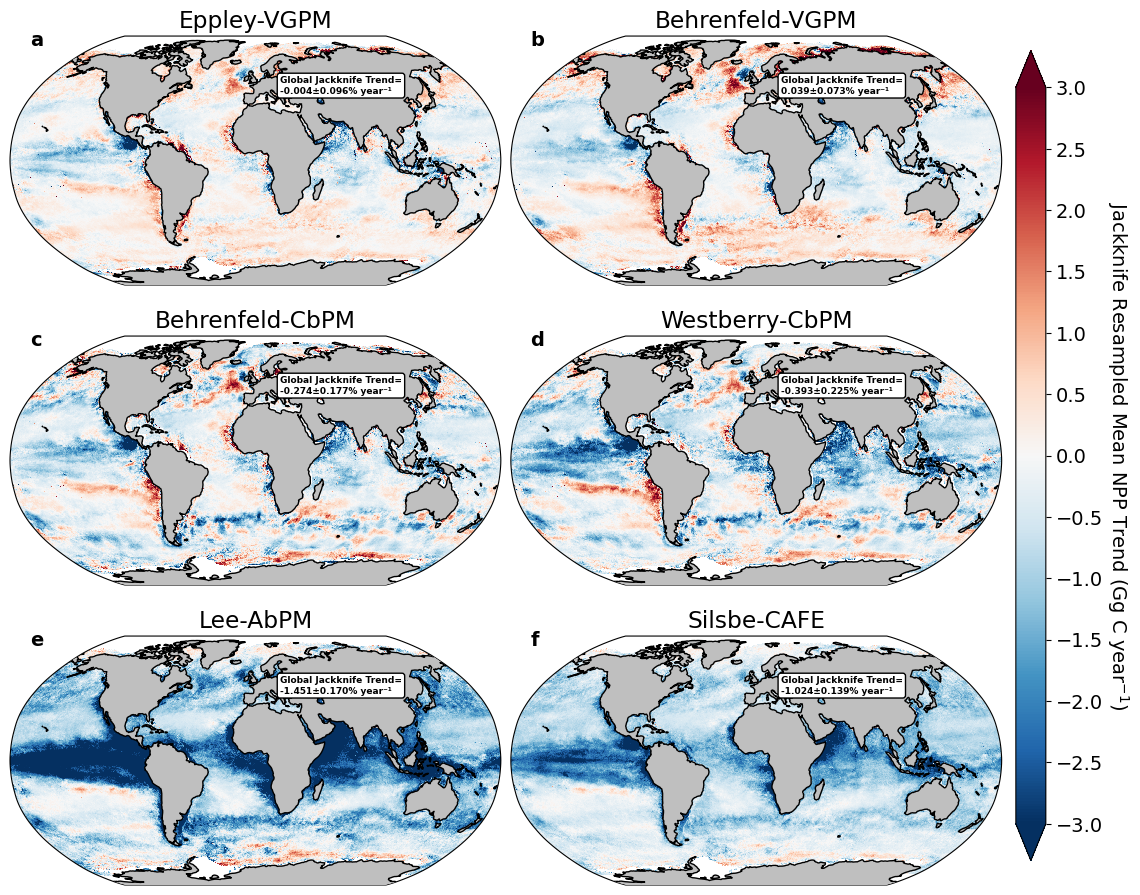

In [19]:
vmin = -3
vmax = 3

fig = plt.figure(figsize=[10, 9], constrained_layout=True)
gs = fig.add_gridspec(3, 2)

models = ['VGPM1', 'VGPM2', 'CBPM1', 'CBPM2', 'ABPM', 'CAFE']
names = ['Eppley-VGPM', 'Behrenfeld-VGPM', 'Behrenfeld-CbPM', 'Westberry-CbPM', 'Lee-AbPM', 'Silsbe-CAFE']
#datasets = [vgpm1, vgpm2, cbpm1, cbpm2, abpm, cafe]
#jn_datasets = [vgpm1_jn, vgpm2_jn, cbpm1_jn, cbpm2_jn, abpm_jn, cafe_jn]

# Function to plot each map
def plot_map(ax, model, dataset, trend_mean, trend_std, label, position, vmin, vmax):
    ax.add_feature(cartopy.feature.LAND, facecolor='0.75', zorder=5)
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1, zorder=5)
    ax.set_global()
    
    # Plot the data and save the image object for colorbar later
    im = trend_datasets[model].mean('simulation').Slope.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=vmin, vmax=vmax)
    
    # Adding title and trend annotation
    ax.text(0.04, 0.96, label, fontweight='bold', transform=ax.transAxes)
    ax.text(0.55, 0.77, f'Global Jackknife Trend=\n{trend_mean:.3f}±{trend_std:.3f}% year⁻¹',
            bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'),
            fontsize=6.5, zorder=6, fontweight='bold', transform=ax.transAxes)
    
    return im  # Return the image object for later use in colorbar
    
# Create subplots for each model
axes = []
for i, model in enumerate(models):
    ax = fig.add_subplot(gs[i // 2, i % 2], projection=ccrs.Robinson())
    axes.append(ax)
    im = plot_map(ax, models[i], trend_datasets, df_slope_jn.iloc[-1,i], df_slope_jn_st.iloc[-1,i], chr(97 + i), (i // 2, i % 2), vmin, vmax)

# Add color bar
cbar_ax = fig.add_axes([1.01, 0.05, 0.03, 0.9])
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', ticks=np.arange(-3, 3.5, 0.5))
cbar.set_label('Jackknife Resampled Mean NPP Trend (Gg C year$^{-1}$)', labelpad=20, rotation=270)

# Set titles
for i, ax in enumerate(axes):
    ax.set_title(f'{names[i]}')

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_02"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)

# Figure S2

## Define MLR model for predicting trend

In [ ]:
def regression_analysis(y, *x):
    # Check for NaNs in y and x variables
    if np.isnan(y).any() or np.isnan(np.column_stack(x)).any():
        return xr.DataArray(np.full((3 + len(x),), np.nan), 
                            dims=['stats'], 
                            coords={'stats': ['rsquared', 'fvalue', 'f_pvalue'] + [f'param_{i+1}' for i in range(len(x))]})

    # Define a small threshold for variance to handle floating point errors
    threshold = 1e-10

    # Check for very small variance in the dependent variable y
    if np.var(y) < threshold:
        return xr.DataArray(np.full((3 + len(x),), np.nan), 
                            dims=['stats'], 
                            coords={'stats': ['rsquared', 'fvalue', 'f_pvalue'] + [f'param_{i+1}' for i in range(len(x))]})

    # Check for very small variance in independent variables x
    for var in x:
        if np.var(var) < threshold:
            return xr.DataArray(np.full((3 + len(x),), np.nan), 
                                dims=['stats'], 
                                coords={'stats': ['rsquared', 'fvalue', 'f_pvalue'] + [f'param_{i+1}' for i in range(len(x))]})
    
    x_stack = np.column_stack(x)
    X = sm.add_constant(x_stack)  # Add constant, though we will drop it later
    
    model = sm.OLS(y, X)
    maxlags = int(np.floor(4 * (len(y) / 100) ** (2/9)))
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': maxlags})

    # Drop the constant term (index 0), return only the coefficients for the 3 drivers
    params_without_constant = results.params[1:]  # Drop the constant term
    
    # Ensure the output includes r-squared, f-value, p-value, and 3 coefficients
    # Return results as an xarray DataArray including all params
    return xr.DataArray([results.rsquared_adj, results.fvalue, results.f_pvalue] + list(results.params[1:]),
                        dims=['stats'],
                        coords={'stats': ['rsquared', 'fvalue', 'f_pvalue'] + [f'param_{i+1}' for i in range(len(x))]})


### Load in data

In [ ]:
# File needed for the results to look at per biome relationship
fname = root_dir+'/DATA/Time_Varying_Biomes_25KM.nc'
biomes = xr.open_dataset(fname)

outdir = f"{root_dir}/DATA/STATS/MLR/REMOTE_SENSING"
datadir_global = f"{root_dir}/DATA/ANNUAL_MEAN_FILES/GLOBAL_VARIABLES"
datadir_remote = f"{root_dir}/DATA/ANNUAL_MEAN_FILES/REMOTE_SENSING"

# Load global variable datasets
global_files = {
    "sst": f"{datadir_global}/SST/SST_ANNUAL_MEAN.nc",
    "mld": f"{datadir_global}/MLD/HADLEY_030_MLD_ANNUAL_MEAN.nc",
    "chl": f"{datadir_global}/CHL/CHL_ANNUAL_MEAN.nc"
}
global_datasets = {key: xr.open_dataset(path) for key, path in global_files.items()}

# Load remote sensing datasets
remote_files = {
    "vgpm1": ("Eppley-VGPM", f"{datadir_remote}/VGPM1_GLOBAL_ANNUAL_MEAN.nc"),
    "vgpm2": ("Behrenfeld-VGPM", f"{datadir_remote}/VGPM2_GLOBAL_ANNUAL_MEAN.nc"),
    "cbpm1": ("Behrenfeld-CbPM", f"{datadir_remote}/CBPM1_GLOBAL_ANNUAL_MEAN.nc"),
    "cbpm2": ("Westberry-CbPM", f"{datadir_remote}/CBPM2_GLOBAL_ANNUAL_MEAN.nc"),
    "abpm": ("Lee-AbPM", f"{datadir_remote}/ABPM_GLOBAL_ANNUAL_MEAN.nc"),
    "cafe": ("Silsbe-CAFE", f"{datadir_remote}/CAFE_GLOBAL_ANNUAL_MEAN.nc"),
}
remote_datasets = {
    key: (var_name, xr.open_dataset(path)) for key, (var_name, path) in remote_files.items()
}

def calculate_pixel_area(xds, km_per_degree=111.1, m_per_km=1000):
    """Calculate the pixel area in m² for the given xarray dataset."""
    degrees_per_pixel = 180 / xds.lat.shape[0]
    pixel_area_equator_km2 = (degrees_per_pixel * km_per_degree) ** 2
    lat_rad = np.radians(xds['lat'])
    pixel_area = np.cos(lat_rad) * pixel_area_equator_km2
    pixel_area_2d = pixel_area.broadcast_like(xds)
    return pixel_area_2d * m_per_km**2  # Convert to m²

# Use one dataset to calculate pixel area (assumes consistent grid across datasets)
sample_dataset = next(iter(remote_datasets.values()))[1]  # Get a dataset from the remote list
pixel_area_m2 = calculate_pixel_area(sample_dataset)

# Apply area weighting and correction for all remote datasets
for key, (var_name, ds) in remote_datasets.items():
    if var_name in ds.variables:  # Ensure variable exists in dataset
        ds[var_name] = ds[var_name] * pixel_area_m2 * 365

#### Eppley-VGPM

In [ ]:
# Merge required datasets into a single xarray dataset
xds = xr.merge([
    remote_datasets['vgpm1'][1],  # Eppley-VGPM
    global_datasets['sst'],       # SST
    global_datasets['chl'],       # CHL
    global_datasets['mld']        # MLD
])

# Define predictor combinations
predictor_combinations = {
    "sst": ["analysed_sst"],
    "chl": ["chlor_a"],
    "sst_chl": ["analysed_sst", "chlor_a"],
    "sst_chl_mld": ["analysed_sst", "chlor_a", "mld"]
}

# Prepare an empty dictionary to store results for each combination
results = {}

# Iterate through predictor combinations
for combo_name, predictors in tqdm(predictor_combinations.items(), desc="Predictor Combinations"):
    dataset_jn = []  # Store datasets for all simulations of this combination
    
    # Loop through 7 jackknife simulations
    for i in range(7):
        # Select rolling time slice and normalize
        ds = xds.isel(time=slice(i, 20 + i)) / xds.isel(time=slice(i, 20 + i)).mean(dim="time")
        
        # Prepare inputs for regression
        inputs = [ds[predictor] for predictor in predictors]
        
        # Apply regression analysis
        regression_results = xr.apply_ufunc(
            regression_analysis,
            ds['Eppley-VGPM'],  # Target variable
            *inputs,            # Predictor variables
            input_core_dims=[['time']] + [['time']] * len(inputs),
            output_core_dims=[['stats']],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[float]
        )
        
        # Create a dataset from regression results
        dataset = xr.Dataset(coords={'lat': xds['lat'], 'lon': xds['lon']})
        dataset['regression_stats'] = regression_results.rename('regression_stats')
        
        # Extract metrics into individual variables
        metrics = ['rsquared', 'fvalue', 'f_pvalue'] + [f"{p}_coef" for p in predictors]
        for idx, metric in enumerate(metrics):
            dataset[metric] = dataset['regression_stats'].isel(stats=idx)
        
        # Drop the combined regression stats variable
        dataset = dataset.drop_vars('regression_stats')
        
        # Mask invalid R-squared values and add biome data
        dataset['rsquared'] = dataset['rsquared'].where(dataset['rsquared'] > 0, other=np.nan)
        dataset['biomes'] = biomes['MeanBiomes']
        
        # Append to the list for concatenation
        dataset_jn.append(dataset)
    
    # Concatenate all jackknife results along a new simulation dimension
    results[combo_name] = xr.concat(dataset_jn, dim="simulation")

    # Save the dataset to NetCDF
    output_path = f"{outdir}/VGPM1_MLR_{combo_name.upper()}_JACKKNIFE.nc"
    results[combo_name].to_netcdf(output_path)
    print(f"Saved dataset for {combo_name} to {output_path}")

#### Behrenfeld-VGPM

In [ ]:
# Merge required datasets into a single xarray dataset
xds = xr.merge([
    remote_datasets['vgpm2'][1],  # Behrenfeld-VGPM
    global_datasets['sst'],       # SST
    global_datasets['chl'],       # CHL
    global_datasets['mld']        # MLD
])

# Define predictor combinations
predictor_combinations = {
    "sst": ["analysed_sst"],
    "chl": ["chlor_a"],
    "sst_chl": ["analysed_sst", "chlor_a"],
    "sst_chl_mld": ["analysed_sst", "chlor_a", "mld"]
}

# Prepare an empty dictionary to store results for each combination
results = {}

# Iterate through predictor combinations
for combo_name, predictors in tqdm(predictor_combinations.items(), desc="Predictor Combinations"):
    dataset_jn = []  # Store datasets for all simulations of this combination
    
    # Loop through 7 jackknife simulations
    for i in range(7):
        # Select rolling time slice and normalize
        ds = xds.isel(time=slice(i, 20 + i)) / xds.isel(time=slice(i, 20 + i)).mean(dim="time")
        
        # Prepare inputs for regression
        inputs = [ds[predictor] for predictor in predictors]
        
        # Apply regression analysis
        regression_results = xr.apply_ufunc(
            regression_analysis,
            ds['Behrenfeld-VGPM'],  # Target variable
            *inputs,            # Predictor variables
            input_core_dims=[['time']] + [['time']] * len(inputs),
            output_core_dims=[['stats']],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[float]
        )
        
        # Create a dataset from regression results
        dataset = xr.Dataset(coords={'lat': xds['lat'], 'lon': xds['lon']})
        dataset['regression_stats'] = regression_results.rename('regression_stats')
        
        # Extract metrics into individual variables
        metrics = ['rsquared', 'fvalue', 'f_pvalue'] + [f"{p}_coef" for p in predictors]
        for idx, metric in enumerate(metrics):
            dataset[metric] = dataset['regression_stats'].isel(stats=idx)
        
        # Drop the combined regression stats variable
        dataset = dataset.drop_vars('regression_stats')
        
        # Mask invalid R-squared values and add biome data
        dataset['rsquared'] = dataset['rsquared'].where(dataset['rsquared'] > 0, other=np.nan)
        dataset['biomes'] = biomes['MeanBiomes']
        
        # Append to the list for concatenation
        dataset_jn.append(dataset)
    
    # Concatenate all jackknife results along a new simulation dimension
    results[combo_name] = xr.concat(dataset_jn, dim="simulation")

    # Save the dataset to NetCDF
    output_path = f"{outdir}/VGPM2_MLR_{combo_name.upper()}_JACKKNIFE.nc"
    results[combo_name].to_netcdf(output_path)
    print(f"Saved dataset for {combo_name} to {output_path}")

#### Behrenfeld-CbPM

In [ ]:
# Merge required datasets into a single xarray dataset
xds = xr.merge([
    remote_datasets['cbpm1'][1],  # Behrenfeld-CbPM
    global_datasets['sst'],       # SST
    global_datasets['chl'],       # CHL
    global_datasets['mld']        # MLD
])

# Define predictor combinations
predictor_combinations = {
    "sst": ["analysed_sst"],
    "chl": ["chlor_a"],
    "sst_chl": ["analysed_sst", "chlor_a"],
    "sst_chl_mld": ["analysed_sst", "chlor_a", "mld"]
}

# Prepare an empty dictionary to store results for each combination
results = {}

# Iterate through predictor combinations
for combo_name, predictors in tqdm(predictor_combinations.items(), desc="Predictor Combinations"):
    dataset_jn = []  # Store datasets for all simulations of this combination
    
    # Loop through 7 jackknife simulations
    for i in range(7):
        # Select rolling time slice and normalize
        ds = xds.isel(time=slice(i, 20 + i)) / xds.isel(time=slice(i, 20 + i)).mean(dim="time")
        
        # Prepare inputs for regression
        inputs = [ds[predictor] for predictor in predictors]
        
        # Apply regression analysis
        regression_results = xr.apply_ufunc(
            regression_analysis,
            ds['Behrenfeld-CbPM'],  # Target variable
            *inputs,            # Predictor variables
            input_core_dims=[['time']] + [['time']] * len(inputs),
            output_core_dims=[['stats']],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[float]
        )
        
        # Create a dataset from regression results
        dataset = xr.Dataset(coords={'lat': xds['lat'], 'lon': xds['lon']})
        dataset['regression_stats'] = regression_results.rename('regression_stats')
        
        # Extract metrics into individual variables
        metrics = ['rsquared', 'fvalue', 'f_pvalue'] + [f"{p}_coef" for p in predictors]
        for idx, metric in enumerate(metrics):
            dataset[metric] = dataset['regression_stats'].isel(stats=idx)
        
        # Drop the combined regression stats variable
        dataset = dataset.drop_vars('regression_stats')
        
        # Mask invalid R-squared values and add biome data
        dataset['rsquared'] = dataset['rsquared'].where(dataset['rsquared'] > 0, other=np.nan)
        dataset['biomes'] = biomes['MeanBiomes']
        
        # Append to the list for concatenation
        dataset_jn.append(dataset)
    
    # Concatenate all jackknife results along a new simulation dimension
    results[combo_name] = xr.concat(dataset_jn, dim="simulation")

    # Save the dataset to NetCDF
    output_path = f"{outdir}/CBPM1_MLR_{combo_name.upper()}_JACKKNIFE.nc"
    results[combo_name].to_netcdf(output_path)
    print(f"Saved dataset for {combo_name} to {output_path}")

#### Westberry-CbPM

In [ ]:
# Merge required datasets into a single xarray dataset
xds = xr.merge([
    remote_datasets['cbpm2'][1],  # Westberry-CbPM
    global_datasets['sst'],       # SST
    global_datasets['chl'],       # CHL
    global_datasets['mld']        # MLD
])

# Define predictor combinations
predictor_combinations = {
    "sst": ["analysed_sst"],
    "chl": ["chlor_a"],
    "sst_chl": ["analysed_sst", "chlor_a"],
    "sst_chl_mld": ["analysed_sst", "chlor_a", "mld"]
}

# Prepare an empty dictionary to store results for each combination
results = {}

# Iterate through predictor combinations
for combo_name, predictors in tqdm(predictor_combinations.items(), desc="Predictor Combinations"):
    dataset_jn = []  # Store datasets for all simulations of this combination
    
    # Loop through 7 jackknife simulations
    for i in range(7):
        # Select rolling time slice and normalize
        ds = xds.isel(time=slice(i, 20 + i)) / xds.isel(time=slice(i, 20 + i)).mean(dim="time")
        
        # Prepare inputs for regression
        inputs = [ds[predictor] for predictor in predictors]
        
        # Apply regression analysis
        regression_results = xr.apply_ufunc(
            regression_analysis,
            ds['Westberry-CbPM'],  # Target variable
            *inputs,            # Predictor variables
            input_core_dims=[['time']] + [['time']] * len(inputs),
            output_core_dims=[['stats']],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[float]
        )
        
        # Create a dataset from regression results
        dataset = xr.Dataset(coords={'lat': xds['lat'], 'lon': xds['lon']})
        dataset['regression_stats'] = regression_results.rename('regression_stats')
        
        # Extract metrics into individual variables
        metrics = ['rsquared', 'fvalue', 'f_pvalue'] + [f"{p}_coef" for p in predictors]
        for idx, metric in enumerate(metrics):
            dataset[metric] = dataset['regression_stats'].isel(stats=idx)
        
        # Drop the combined regression stats variable
        dataset = dataset.drop_vars('regression_stats')
        
        # Mask invalid R-squared values and add biome data
        dataset['rsquared'] = dataset['rsquared'].where(dataset['rsquared'] > 0, other=np.nan)
        dataset['biomes'] = biomes['MeanBiomes']
        
        # Append to the list for concatenation
        dataset_jn.append(dataset)
    
    # Concatenate all jackknife results along a new simulation dimension
    results[combo_name] = xr.concat(dataset_jn, dim="simulation")

    # Save the dataset to NetCDF
    output_path = f"{outdir}/CBPM2_MLR_{combo_name.upper()}_JACKKNIFE.nc"
    results[combo_name].to_netcdf(output_path)
    print(f"Saved dataset for {combo_name} to {output_path}")

#### Lee-AbPM

In [ ]:
# Merge required datasets into a single xarray dataset
xds = xr.merge([
    remote_datasets['abpm'][1],  # Lee-AbPM
    global_datasets['sst'],       # SST
    global_datasets['chl'],       # CHL
    global_datasets['mld']        # MLD
])

# Define predictor combinations
predictor_combinations = {
    "sst": ["analysed_sst"],
    "chl": ["chlor_a"],
    "sst_chl": ["analysed_sst", "chlor_a"],
    "sst_chl_mld": ["analysed_sst", "chlor_a", "mld"]
}

# Prepare an empty dictionary to store results for each combination
results = {}

# Iterate through predictor combinations
for combo_name, predictors in tqdm(predictor_combinations.items(), desc="Predictor Combinations"):
    dataset_jn = []  # Store datasets for all simulations of this combination
    
    # Loop through 7 jackknife simulations
    for i in range(7):
        # Select rolling time slice and normalize
        ds = xds.isel(time=slice(i, 20 + i)) / xds.isel(time=slice(i, 20 + i)).mean(dim="time")
        
        # Prepare inputs for regression
        inputs = [ds[predictor] for predictor in predictors]
        
        # Apply regression analysis
        regression_results = xr.apply_ufunc(
            regression_analysis,
            ds['Lee-AbPM'],  # Target variable
            *inputs,            # Predictor variables
            input_core_dims=[['time']] + [['time']] * len(inputs),
            output_core_dims=[['stats']],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[float]
        )
        
        # Create a dataset from regression results
        dataset = xr.Dataset(coords={'lat': xds['lat'], 'lon': xds['lon']})
        dataset['regression_stats'] = regression_results.rename('regression_stats')
        
        # Extract metrics into individual variables
        metrics = ['rsquared', 'fvalue', 'f_pvalue'] + [f"{p}_coef" for p in predictors]
        for idx, metric in enumerate(metrics):
            dataset[metric] = dataset['regression_stats'].isel(stats=idx)
        
        # Drop the combined regression stats variable
        dataset = dataset.drop_vars('regression_stats')
        
        # Mask invalid R-squared values and add biome data
        dataset['rsquared'] = dataset['rsquared'].where(dataset['rsquared'] > 0, other=np.nan)
        dataset['biomes'] = biomes['MeanBiomes']
        
        # Append to the list for concatenation
        dataset_jn.append(dataset)
    
    # Concatenate all jackknife results along a new simulation dimension
    results[combo_name] = xr.concat(dataset_jn, dim="simulation")

    # Save the dataset to NetCDF
    output_path = f"{outdir}/ABPM_MLR_{combo_name.upper()}_JACKKNIFE.nc"
    results[combo_name].to_netcdf(output_path)
    print(f"Saved dataset for {combo_name} to {output_path}")

#### Silsbe-CAFE

In [ ]:
# Merge required datasets into a single xarray dataset
xds = xr.merge([
    remote_datasets['cafe'][1],  # Silsbe-CAFE
    global_datasets['sst'],       # SST
    global_datasets['chl'],       # CHL
    global_datasets['mld']        # MLD
])

# Define predictor combinations
predictor_combinations = {
    "sst": ["analysed_sst"],
    "chl": ["chlor_a"],
    "sst_chl": ["analysed_sst", "chlor_a"],
    "sst_chl_mld": ["analysed_sst", "chlor_a", "mld"]
}

# Prepare an empty dictionary to store results for each combination
results = {}

# Iterate through predictor combinations
for combo_name, predictors in tqdm(predictor_combinations.items(), desc="Predictor Combinations"):
    dataset_jn = []  # Store datasets for all simulations of this combination
    
    # Loop through 7 jackknife simulations
    for i in range(7):
        # Select rolling time slice and normalize
        ds = xds.isel(time=slice(i, 20 + i)) / xds.isel(time=slice(i, 20 + i)).mean(dim="time")
        
        # Prepare inputs for regression
        inputs = [ds[predictor] for predictor in predictors]
        
        # Apply regression analysis
        regression_results = xr.apply_ufunc(
            regression_analysis,
            ds['Silsbe-CAFE'],  # Target variable
            *inputs,            # Predictor variables
            input_core_dims=[['time']] + [['time']] * len(inputs),
            output_core_dims=[['stats']],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[float]
        )
        
        # Create a dataset from regression results
        dataset = xr.Dataset(coords={'lat': xds['lat'], 'lon': xds['lon']})
        dataset['regression_stats'] = regression_results.rename('regression_stats')
        
        # Extract metrics into individual variables
        metrics = ['rsquared', 'fvalue', 'f_pvalue'] + [f"{p}_coef" for p in predictors]
        for idx, metric in enumerate(metrics):
            dataset[metric] = dataset['regression_stats'].isel(stats=idx)
        
        # Drop the combined regression stats variable
        dataset = dataset.drop_vars('regression_stats')
        
        # Mask invalid R-squared values and add biome data
        dataset['rsquared'] = dataset['rsquared'].where(dataset['rsquared'] > 0, other=np.nan)
        dataset['biomes'] = biomes['MeanBiomes']
        
        # Append to the list for concatenation
        dataset_jn.append(dataset)
    
    # Concatenate all jackknife results along a new simulation dimension
    results[combo_name] = xr.concat(dataset_jn, dim="simulation")

    # Save the dataset to NetCDF
    output_path = f"{outdir}/CAFE_MLR_{combo_name.upper()}_JACKKNIFE.nc"
    results[combo_name].to_netcdf(output_path)
    print(f"Saved dataset for {combo_name} to {output_path}")

## Load MLR results

In [20]:
# Define the datasets to load
datasets = {
    'vgpm1_sst': 'VGPM1_MLR_SST_JACKKNIFE.nc',
    'vgpm2_sst': 'VGPM2_MLR_SST_JACKKNIFE.nc',
    'cbpm1_sst': 'CBPM1_MLR_SST_JACKKNIFE.nc',
    'cbpm2_sst': 'CBPM2_MLR_SST_JACKKNIFE.nc',
    'cafe_sst': 'CAFE_MLR_SST_JACKKNIFE.nc',
    'abpm_sst': 'ABPM_MLR_SST_JACKKNIFE.nc',
    'vgpm1_chl': 'VGPM1_MLR_CHL_JACKKNIFE.nc',
    'vgpm2_chl': 'VGPM2_MLR_CHL_JACKKNIFE.nc',
    'cbpm1_chl': 'CBPM1_MLR_CHL_JACKKNIFE.nc',
    'cbpm2_chl': 'CBPM2_MLR_CHL_JACKKNIFE.nc',
    'cafe_chl': 'CAFE_MLR_CHL_JACKKNIFE.nc',
    'abpm_chl': 'ABPM_MLR_CHL_JACKKNIFE.nc',
    'vgpm1_sst_chl': 'VGPM1_MLR_SST_CHL_JACKKNIFE.nc',
    'vgpm2_sst_chl': 'VGPM2_MLR_SST_CHL_JACKKNIFE.nc',
    'cbpm1_sst_chl': 'CBPM1_MLR_SST_CHL_JACKKNIFE.nc',
    'cbpm2_sst_chl': 'CBPM2_MLR_SST_CHL_JACKKNIFE.nc',
    'cafe_sst_chl': 'CAFE_MLR_SST_CHL_JACKKNIFE.nc',
    'abpm_sst_chl': 'ABPM_MLR_SST_CHL_JACKKNIFE.nc',
    'vgpm1_sst_chl_mld': 'VGPM1_MLR_SST_CHL_MLD_JACKKNIFE.nc',
    'vgpm2_sst_chl_mld': 'VGPM2_MLR_SST_CHL_MLD_JACKKNIFE.nc',
    'cbpm1_sst_chl_mld': 'CBPM1_MLR_SST_CHL_MLD_JACKKNIFE.nc',
    'cbpm2_sst_chl_mld': 'CBPM2_MLR_SST_CHL_MLD_JACKKNIFE.nc',
    'cafe_sst_chl_mld': 'CAFE_MLR_SST_CHL_MLD_JACKKNIFE.nc',
    'abpm_sst_chl_mld': 'ABPM_MLR_SST_CHL_MLD_JACKKNIFE.nc'
}

# Load the datasets into a dictionary
dataset_dict = {}
for key, fname in datasets.items():
    dataset_dict[key] = xr.open_dataset(root_dir + f'/DATA/STATS/MLR/REMOTE_SENSING/{fname}')

# Function to compute ratio of counts for R-squared values
def compute_significance_ratio(dataset1):
    """
    Compute the ratio of the count of significant R-squared values (f_pvalue < 0.05)
    relative to the total R-squared count for the given dataset(s).
    """

    return (dataset1.where(dataset1.f_pvalue < 0.05, drop=True).rsquared.count(['lat', 'lon']) /
            dataset1.rsquared.count(['lat', 'lon']))

a1 = compute_significance_ratio(dataset_dict['vgpm1_sst'])
a2 = compute_significance_ratio(dataset_dict['vgpm1_chl'])
a3 = compute_significance_ratio(dataset_dict['vgpm1_sst_chl'])
a4 = compute_significance_ratio(dataset_dict['vgpm1_sst_chl_mld'])

b1 = compute_significance_ratio(dataset_dict['vgpm2_sst'])
b2 = compute_significance_ratio(dataset_dict['vgpm2_chl'])
b3 = compute_significance_ratio(dataset_dict['vgpm2_sst_chl'])
b4 = compute_significance_ratio(dataset_dict['vgpm2_sst_chl_mld'])

c1 = compute_significance_ratio(dataset_dict['cbpm1_sst'])
c2 = compute_significance_ratio(dataset_dict['cbpm1_chl'])
c3 = compute_significance_ratio(dataset_dict['cbpm1_sst_chl'])
c4 = compute_significance_ratio(dataset_dict['cbpm1_sst_chl_mld'])

d1 = compute_significance_ratio(dataset_dict['cbpm2_sst'])
d2 = compute_significance_ratio(dataset_dict['cbpm2_chl'])
d3 = compute_significance_ratio(dataset_dict['cbpm2_sst_chl'])
d4 = compute_significance_ratio(dataset_dict['cbpm2_sst_chl_mld'])

e1 = compute_significance_ratio(dataset_dict['abpm_sst'])
e2 = compute_significance_ratio(dataset_dict['abpm_chl'])
e3 = compute_significance_ratio(dataset_dict['abpm_sst_chl'])
e4 = compute_significance_ratio(dataset_dict['abpm_sst_chl_mld'])

f1 = compute_significance_ratio(dataset_dict['cafe_sst'])
f2 = compute_significance_ratio(dataset_dict['cafe_chl'])
f3 = compute_significance_ratio(dataset_dict['cafe_sst_chl'])
f4 = compute_significance_ratio(dataset_dict['cafe_sst_chl_mld'])

rsquared_dict = {}

# Iterate over each dataset and apply the rsquared extraction
for key, dataset in dataset_dict.items():
    rsquared_dict[key] = dataset.where(dataset.f_pvalue < 0.05, drop=True).rsquared

data01 = rsquared_dict['vgpm1_sst'].mean('simulation').to_series().values
data02 = rsquared_dict['vgpm1_chl'].mean('simulation').to_series().values
data03 = rsquared_dict['vgpm1_sst_chl'].mean('simulation').to_series().values
data04 = rsquared_dict['vgpm1_sst_chl_mld'].mean('simulation').to_series().values

data05 = rsquared_dict['vgpm2_sst'].mean('simulation').to_series().values
data06 = rsquared_dict['vgpm2_chl'].mean('simulation').to_series().values
data07 = rsquared_dict['vgpm2_sst_chl'].mean('simulation').to_series().values
data08 = rsquared_dict['vgpm2_sst_chl_mld'].mean('simulation').to_series().values

data09 = rsquared_dict['cbpm1_sst'].mean('simulation').to_series().values
data10 = rsquared_dict['cbpm1_chl'].mean('simulation').to_series().values
data11 = rsquared_dict['cbpm1_sst_chl'].mean('simulation').to_series().values
data12 = rsquared_dict['cbpm1_sst_chl_mld'].mean('simulation').to_series().values

data13 = rsquared_dict['cbpm2_sst'].mean('simulation').to_series().values
data14 = rsquared_dict['cbpm2_chl'].mean('simulation').to_series().values
data15 = rsquared_dict['cbpm2_sst_chl'].mean('simulation').to_series().values
data16 = rsquared_dict['cbpm2_sst_chl_mld'].mean('simulation').to_series().values

data17 = rsquared_dict['abpm_sst'].mean('simulation').to_series().values
data18 = rsquared_dict['abpm_chl'].mean('simulation').to_series().values
data19 = rsquared_dict['abpm_sst_chl'].mean('simulation').to_series().values
data20 = rsquared_dict['abpm_sst_chl_mld'].mean('simulation').to_series().values

data21 = rsquared_dict['cafe_sst'].mean('simulation').to_series().values
data22 = rsquared_dict['cafe_chl'].mean('simulation').to_series().values
data23 = rsquared_dict['cafe_sst_chl'].mean('simulation').to_series().values
data24 = rsquared_dict['cafe_sst_chl_mld'].mean('simulation').to_series().values

data = [data01, data02, data03, data04, np.nan, 
        data05, data06, data07, data08, np.nan, 
        data09, data10, data11, data12, np.nan,
        data13, data14, data15, data16, np.nan, 
        data17, data18, data19, data20, np.nan,
        data21, data22, data23, data24]

## Plot the Figure

/Users/tommyrk/opt/anaconda3/envs/pyth_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)


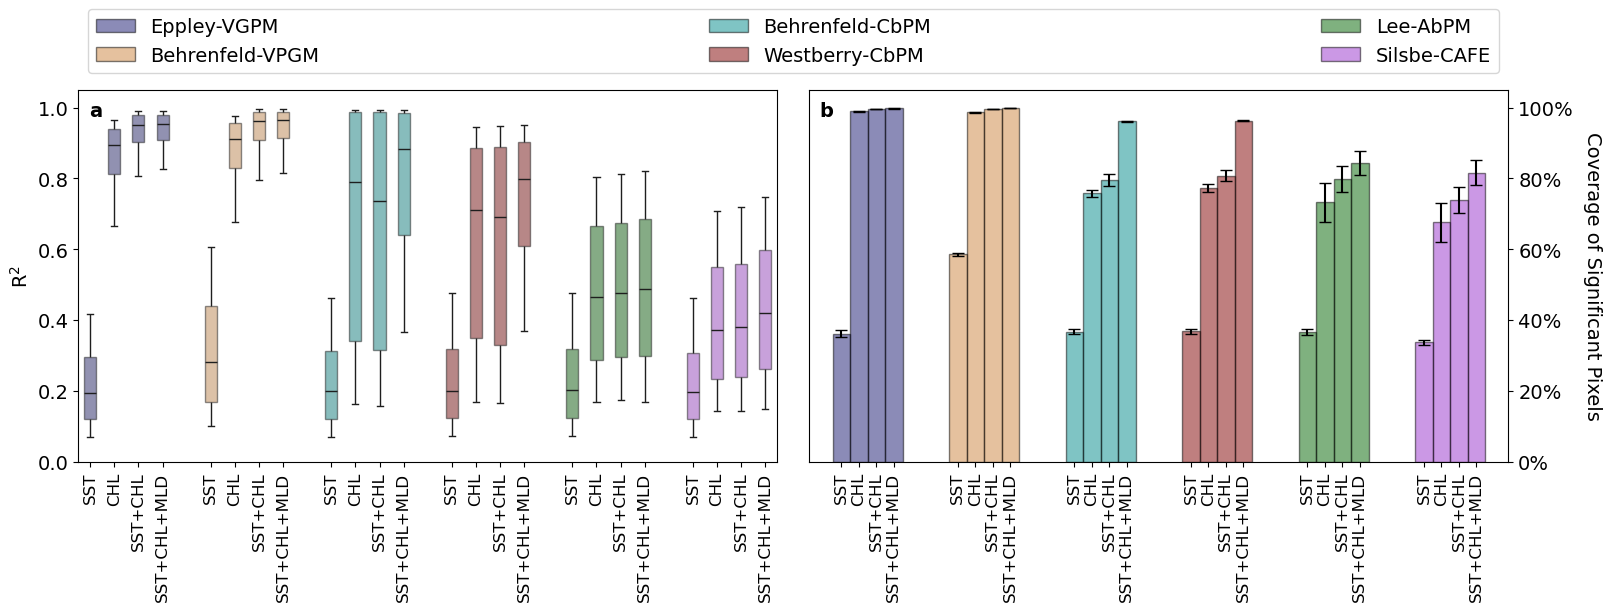

In [23]:
labels = ['Eppley-VGPM', 'Behrenfeld-VPGM', 'Behrenfeld-CbPM', 
          'Westberry-CbPM', 'Lee-AbPM', 'Silsbe-CAFE']

custom_palette = ['midnightblue', 'midnightblue', 'midnightblue', 'midnightblue', 'w',
                  'peru', 'peru', 'peru', 'peru', 'w',
                  'darkcyan', 'darkcyan', 'darkcyan', 'darkcyan', 'w',
                  'maroon', 'maroon', 'maroon', 'maroon', 'w',
                  'darkgreen', 'darkgreen', 'darkgreen', 'darkgreen','w',
                  'darkorchid', 'darkorchid', 'darkorchid', 'darkorchid']

colors = ['midnightblue', 'peru', 'darkcyan', 'maroon', 'darkgreen', 'darkorchid']

boxprops = dict(alpha=0.5)

fig = figure(figsize=[16,6], constrained_layout=True)
gs = GridSpec(1, 2, figure=fig)
ax0 = fig.add_subplot(gs[:, :1])
ax1 = fig.add_subplot(gs[:, 1:])

sns.boxplot(ax=ax0, data=data, width=0.5, palette=custom_palette, 
            showfliers=False, whis=[10, 90], boxprops=boxprops)

ax0.set_xticks([0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 
                17, 18, 20, 21, 22, 23, 25, 26, 27, 28])
ax0.set_xticklabels(['SST', 'CHL','SST+CHL', 'SST+CHL+MLD',
                     'SST', 'CHL','SST+CHL', 'SST+CHL+MLD',
                     'SST', 'CHL','SST+CHL', 'SST+CHL+MLD',
                     'SST', 'CHL','SST+CHL', 'SST+CHL+MLD',
                     'SST', 'CHL','SST+CHL', 'SST+CHL+MLD',
                     'SST', 'CHL','SST+CHL', 'SST+CHL+MLD'], fontsize=12, rotation=90)
ax0.set_ylabel('R$^2$')
ax0.set_ylim(0, 1.05)

width = 0.2

values1 = [a1.mean('simulation').values, b1.mean('simulation').values, c1.mean('simulation').values, 
           d1.mean('simulation').values, e1.mean('simulation').values, f1.mean('simulation').values] 
values2 = [a2.mean('simulation').values, b2.mean('simulation').values, c2.mean('simulation').values, 
           d2.mean('simulation').values, e2.mean('simulation').values, f2.mean('simulation').values] 
values3 = [a3.mean('simulation').values, b3.mean('simulation').values, c3.mean('simulation').values, 
           d3.mean('simulation').values, e3.mean('simulation').values, f3.mean('simulation').values] 
values4 = [a4.mean('simulation').values, b4.mean('simulation').values, c4.mean('simulation').values, 
           d4.mean('simulation').values, e4.mean('simulation').values, f4.mean('simulation').values] 

values1_std = [a1.std('simulation').values, b1.std('simulation').values, c1.std('simulation').values, 
           d1.std('simulation').values, e1.std('simulation').values, f1.std('simulation').values]
values2_std = [a2.std('simulation').values, b2.std('simulation').values, c2.std('simulation').values, 
           d2.std('simulation').values, e2.std('simulation').values, f2.std('simulation').values]
values3_std = [a3.std('simulation').values, b3.std('simulation').values, c3.std('simulation').values, 
           d3.std('simulation').values, e3.std('simulation').values, f3.std('simulation').values]
values4_std = [a4.std('simulation').values, b4.std('simulation').values, c4.std('simulation').values, 
           d4.std('simulation').values, e4.std('simulation').values, f4.std('simulation').values]


# Number of categories
num_categories = len(labels)

# Define the width of the bars
bar_width = 0.15

# Create an array of x positions for each category
x = np.arange(num_categories)

# Positions for each group of bars
positions1 = x - (bar_width * 1.5)  # First dataset
positions2 = x - (bar_width * 0.5)  # Second dataset
positions3 = x + (bar_width * 0.5)   # Third dataset
positions4 = x + (bar_width * 1.5)   # Fourth dataset

# Create the grouped bar chart
ax1.bar(positions1, values1, bar_width, color=colors, edgecolor='k', alpha=0.5, yerr=values1_std, capsize=4)
ax1.bar(positions2, values2, bar_width, color=colors, edgecolor='k', alpha=0.5, yerr=values2_std, capsize=4)
ax1.bar(positions3, values3, bar_width, color=colors, edgecolor='k', alpha=0.5, yerr=values3_std, capsize=4)
ax1.bar(positions4, values4, bar_width, color=colors, edgecolor='k', alpha=0.5, yerr=values4_std, capsize=4)

tick_positions = np.concatenate([positions1, positions2, positions3, positions4])
ax1.set_xticks(sorted(tick_positions))
ax1.set_xticklabels(['SST', 'CHL', 'SST+CHL', 'SST+CHL+MLD',
                     'SST', 'CHL', 'SST+CHL', 'SST+CHL+MLD',
                     'SST', 'CHL', 'SST+CHL', 'SST+CHL+MLD',
                     'SST', 'CHL', 'SST+CHL', 'SST+CHL+MLD',
                     'SST', 'CHL', 'SST+CHL', 'SST+CHL+MLD',
                     'SST', 'CHL', 'SST+CHL', 'SST+CHL+MLD'], fontsize=12, rotation=90)

ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax1.set_ylim(0, 1.05)
ax1.set_xlim(-0.5, 5.5)
ax1.set_ylabel('Coverage of Significant Pixels', rotation=270, labelpad=20)
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()

legend_labels = ['Eppley-VGPM', 'Behrenfeld-VPGM', 'Behrenfeld-CbPM', 'Westberry-CbPM', 'Lee-AbPM', 'Silsbe-CAFE']
legend_rects = [Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='k', alpha=0.5) for color in colors]
legend_ax = fig.add_subplot(gs[0, :])
legend_ax.axis('off')
legend_ax.legend(legend_rects, legend_labels, loc='lower left', 
                 bbox_to_anchor=(0, 1.02, 1.0, 0.3), ncol=3, mode='expand')

ax0.text(.015, 0.93, 'a', transform=ax0.transAxes, fontweight='bold')
ax1.text(.015, 0.93, 'b', transform=ax1.transAxes, fontweight='bold')

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_S02"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)

# Figure S3

## Load the data

In [24]:
# Define model names and paths
model_names = ['VGPM1', 'VGPM2', 'CBPM1', 'CBPM2', 'CAFE', 'ABPM']
datasets = {}

# Load datasets and apply the filter
for model_name in model_names:
    fname = f"{root_dir}/DATA/STATS/MLR/REMOTE_SENSING/{model_name}_MLR_SST_CHL_MLD_JACKKNIFE.nc"
    dataset = xr.open_dataset(fname)
    # Exclude non-significant predictive models and calculate the mean
    filtered_dataset = dataset.where(dataset.f_pvalue < 0.05, drop=True).mean('simulation')
    datasets[model_name.lower()] = filtered_dataset

# Access datasets as `datasets['vgpm1']`, `datasets['cbpm2']`, etc.

## Plot the Figure

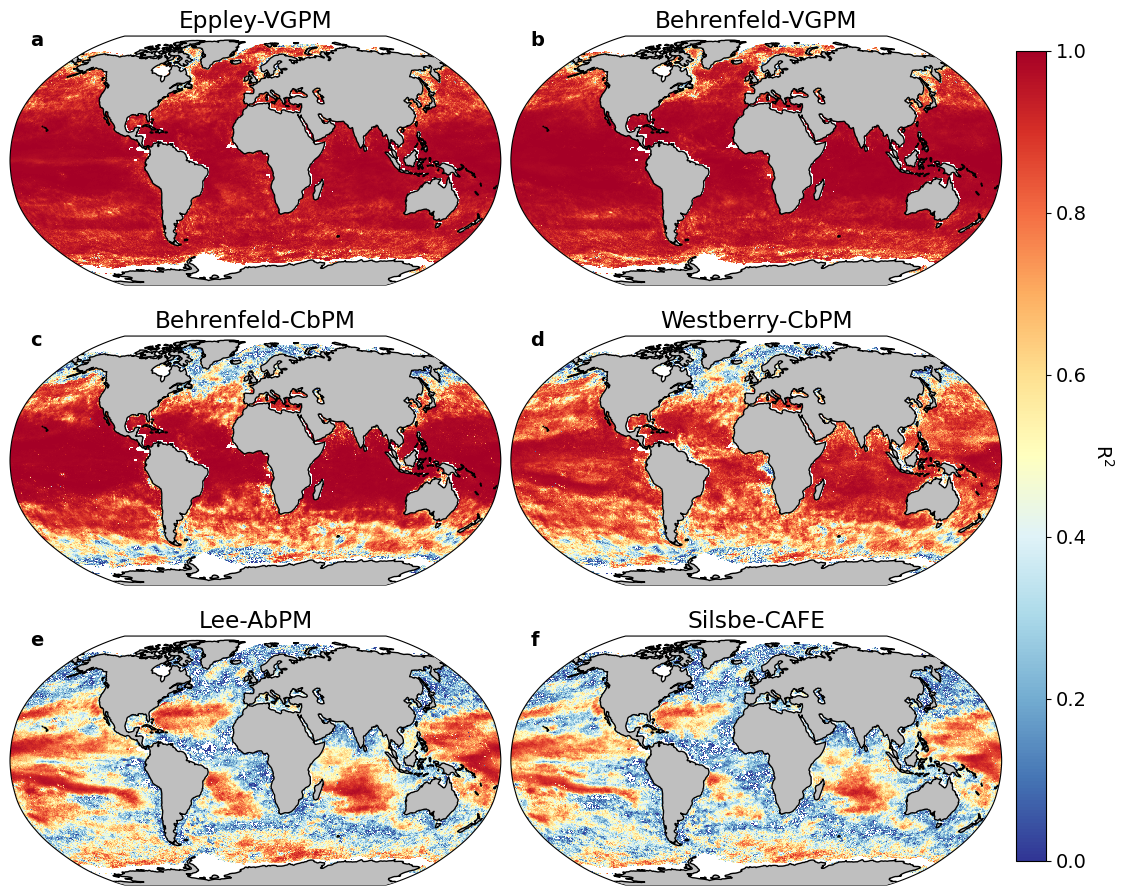

In [25]:
vmin = 0
vmax = 1

fig = figure(figsize=[10, 9], constrained_layout=True)
gs = GridSpec(3, 2, figure=fig)

# Define configurations
datasets_list = ['vgpm1', 'vgpm2', 'cbpm1', 'cbpm2', 'abpm', 'cafe']
titles = [
    'Eppley-VGPM', 'Behrenfeld-VGPM', 
    'Behrenfeld-CbPM', 'Westberry-CbPM', 
    'Lee-AbPM', 'Silsbe-CAFE'
]
subplot_labels = ['a', 'b', 'c', 'd', 'e', 'f']
positions = [
    (slice(None, 1), slice(None, 1)), (slice(None, 1), slice(1, None)),
    (slice(1, 2), slice(None, 1)), (slice(1, 2), slice(1, None)),
    (slice(2, None), slice(None, 1)), (slice(2, None), slice(1, None))
]

# Create subplots dynamically
for i, (data_key, title, label, pos) in enumerate(zip(datasets_list, titles, subplot_labels, positions)):
    ax = fig.add_subplot(gs[pos[0], pos[1]], projection=ccrs.Robinson())
    ax.add_feature(cartopy.feature.LAND, facecolor='0.75', zorder=5)
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1, zorder=5)
    ax.set_global()
    im = datasets[data_key].rsquared.plot(
        ax=ax, add_colorbar=False, cmap='RdYlBu_r', vmin=vmin, vmax=vmax, 
        transform=ccrs.PlateCarree()
    )
    ax.text(0.04, 0.96, label, fontweight='bold', transform=ax.transAxes)
    ax.set_title(title)

# Add colorbar
cbar_ax = fig.add_axes([1.01, 0.05, 0.03, 0.90])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('R$^2$', labelpad=20, rotation=270)

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_S03"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)

# Figure S4

## Load the data

In [26]:
def process_vars_simulation(dataset, var_list, lat_range=(-80, 80), iqr_factor=3):
    """
    Processes a dataset by filtering variables based on IQR, grouping by rounded latitude, 
    and calculating mean values for simulations.

    Parameters:
    - dataset: xarray.Dataset
        The dataset to process.
    - var_list: list of str
        List of variable names to process.
    - lat_range: tuple
        Latitude range to select, default is (-80, 80).
    - iqr_factor: float
        Multiplier for the IQR range for filtering, default is 3.

    Returns:
    - xr.Dataset
        Processed dataset containing grouped and averaged variables for simulations.
    """
    result_dict = {}

    # Restrict to the specified latitude range
    ds = dataset.sel(lat=slice(lat_range[0], lat_range[1]))

    for var in var_list:
        result_dict[var] = {}

        # Process each simulation separately
        for sim in ds.simulation:
            ds_sim = ds.sel(simulation=sim)

            # Compute IQR bounds
            q25 = ds_sim[var].quantile(0.25)
            q75 = ds_sim[var].quantile(0.75)
            iqr = q75 - q25
            lower_bound = q25 - (iqr_factor * iqr)
            upper_bound = q75 + (iqr_factor * iqr)

            # Filter values based on IQR
            ds_filtered = ds_sim.where((ds_sim[var] >= lower_bound) & (ds_sim[var] <= upper_bound), drop=True)

            # Round latitude and group by rounded latitude
            ds_filtered['lat_rnd'] = ds_filtered['lat'].round()
            ds_filtered = ds_filtered.set_coords('lat_rnd')
            ds_grouped = ds_filtered.groupby('lat_rnd').mean()

            # Store grouped results
            result_dict[var][str(sim.values)] = ds_grouped[var]

    # Combine processed variables into a single dataset
    combined_ds = xr.Dataset({
        var: xr.concat([result_dict[var][sim] for sim in result_dict[var]], dim='simulation')
        for var in result_dict
    })

    return combined_ds

def load_and_filter_dataset(filepath, pvalue_threshold=0.05):
    """
    Loads a dataset and filters out data where the predictive model is not significant.

    Parameters:
    - filepath: str
        Path to the dataset file.
    - pvalue_threshold: float
        Threshold for filtering based on `f_pvalue`, default is 0.05.

    Returns:
    - xarray.Dataset
        Filtered and longitude-averaged dataset.
    """
    ds = xr.open_dataset(filepath)
    return ds.where(ds.f_pvalue < pvalue_threshold, drop=True).mean('lon')

def process_all_datasets(datasets, var_list):
    """
    Processes all datasets and returns processed variables as a dictionary.

    Parameters:
    - datasets: dict
        Dictionary of dataset names and filepaths.
    - var_list: list of str
        List of variable names to process.

    Returns:
    - dict
        Dictionary of processed datasets for each variable.
    """
    results = {}
    for name, filepath in datasets.items():
        dataset = load_and_filter_dataset(filepath)
        results[name] = process_vars_simulation(dataset, var_list)
    return results

datadir_mlr = root_dir+'/DATA/STATS/MLR/REMOTE_SENSING'

# Filepaths for datasets
datasets = {
    "Eppley-VGPM": f"{datadir_mlr}/VGPM1_MLR_SST_CHL_MLD_JACKKNIFE.nc",
    "Behrenfeld-VGPM": f"{datadir_mlr}/VGPM2_MLR_SST_CHL_MLD_JACKKNIFE.nc",
    "Behrenfeld-CbPM": f"{datadir_mlr}/CBPM1_MLR_SST_CHL_MLD_JACKKNIFE.nc",
    "Westberry-CbPM": f"{datadir_mlr}/CBPM2_MLR_SST_CHL_MLD_JACKKNIFE.nc",
    "Lee-AbPM": f"{datadir_mlr}/ABPM_MLR_SST_CHL_MLD_JACKKNIFE.nc",
    "Silsbe-CAFE": f"{datadir_mlr}/CAFE_MLR_SST_CHL_MLD_JACKKNIFE.nc"
}

# Variables to process
var_list = ['sst_coef', 'chl_coef', 'mld_coef']

# Process all datasets
processed_results = process_all_datasets(datasets, var_list)


## Plot the Figure

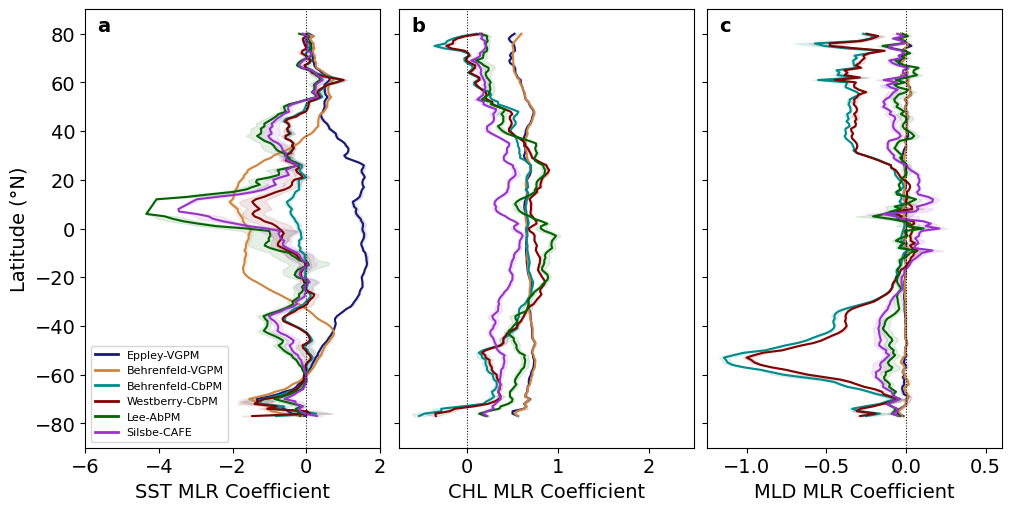

In [27]:
colors = ['midnightblue', 'peru', 'darkcyan', 'maroon', 'darkgreen', 'darkorchid']

coef_types = ['sst_coef', 'chl_coef', 'mld_coef']
ylims = (-90, 90)
xlims = [(-6, 2), (-0.75, 2.5), (-1.25, 0.6)]
xlabel = ['SST MLR Coefficient', 'CHL MLR Coefficient', 'MLD MLR Coefficient']

fig, axs = plt.subplots(1, 3, figsize=[10, 5], constrained_layout=True)
axs = axs.flatten()

# Loop through the three coefficient types and plot for each model
for ax, coef, xlim, xlab in zip(axs, coef_types, xlims, xlabel):
    for (label, data), color in zip(processed_results.items(), colors):  # Use .items() to get label, data pairs
        # Compute mean and std over simulations
        mean_values = data.mean('simulation')[coef].to_series().interpolate()
        std_values = data.std('simulation')[coef].to_series().interpolate()
        latitudes = data.mean('simulation').lat_rnd
        
        # Plot the mean line
        ax.plot(mean_values, latitudes, color=color, label=label)
        # Plot the shaded standard deviation region
        ax.fill_betweenx(latitudes, mean_values + std_values, mean_values - std_values, color=color, alpha=0.10)
    
    # Set x and y limits
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylims)
    ax.axvline(0, color='k', ls=':', lw=0.75)
    
    # Set axis labels
    if coef != 'sst_coef':  # Remove y-axis labels except for the first column
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Latitude (°N)')
    ax.set_xlabel(xlab)

# Add panel labels
for ax, label in zip(axs, ['a', 'b', 'c']):
    ax.text(.04, 0.95, label, transform=ax.transAxes, fontsize=14, fontweight='bold')

# Create a legend
handles = [Line2D([0], [0], color=color, lw=2, label=label) for label, color in zip(processed_results.keys(), colors)]
axs[0].legend(handles=handles, loc='lower left', fontsize=8)

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_S04"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)

# Figure 3

## Repeat MLR analysis on historical CMIP

In [ ]:
# Suppress warnings for NaN slices
warnings.filterwarnings("ignore", message="All-NaN slice encountered")

# Constants
models = ['ACCESS-ESM1-5', 'CESM2-WACCM', 'CESM2', 'CMCC-ESM2',
          'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3-CC',
          'GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR',
          'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM',
          'UKESM1-0-LL']

# File paths and directories
datadir1 = root_dir + '/DATA/ANNUAL_MEAN_FILES/CMIP6_HISTORICAL'
datadir2 = root_dir + '/DATA/ANNUAL_MEAN_FILES/CMIP6_SSP585'
biome_file = root_dir + '/DATA/Time_Varying_Biomes_CMIP.nc'
model_dir = root_dir + '/DATA/ANNUAL_MEAN_FILES/CMIP6_HISTORICAL'
outdir = root_dir + '/DATA/STATS/MLR/CMIP6'

# Open biome dataset
biomes = xr.open_dataset(biome_file)
biomes = biomes.MeanBiomes.T  # Transpose for proper latitude/longitude mapping

def calculate_pixel_area(xds, km_per_degree=111.1, m_per_km=1000):
    """Calculate the pixel area in m² for the given xarray dataset."""
    degrees_per_pixel = 180 / xds.lat.shape[0]
    pixel_area_equator_km2 = (degrees_per_pixel * km_per_degree) ** 2
    lat_rad = np.radians(xds['lat'])
    pixel_area = np.cos(lat_rad) * pixel_area_equator_km2
    pixel_area_2d = pixel_area.broadcast_like(xds)
    return pixel_area_2d * m_per_km**2  # Convert to m²

# Calculate pixel area for biomes
pixel_area_m2 = calculate_pixel_area(biomes)

# Function to open and process data files
def open_and_process_data(flist, variable_name, scale_factor=None, set_nan=False):
    """Open and process data from netCDF files."""
    data = xr.open_mfdataset(flist)
    if set_nan:
        data = data.where(data[variable_name] > 0, np.nan)  # Set bad grid points to NaN
    if scale_factor:
        data[variable_name] = data[variable_name] * scale_factor
    data[variable_name] = data[variable_name] / data[variable_name].mean(dim='time')
    return data[[variable_name]]

# Function to perform regression analysis and store results
def perform_regression_analysis_cmip(xds):
    """Apply regression analysis to the dataset."""
    return xr.apply_ufunc(
        regression_analysis,
        xds['intpp'],
        xds['tos'],
        xds['mlotst'],
        xds['chlos'],
        input_core_dims=[['time'], ['time'], ['time'], ['time']],
        output_core_dims=[['stats']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float],
        dask_gufunc_kwargs={'output_sizes': {'stats': 6}, 'allow_rechunk': True}
    )

# Loop over models and process data
for model in tqdm(models):
    # File paths for the model data
    fname1 = model_dir + f'/NPP/intpp*{model}_*.nc'
    fname2 = model_dir + f'/SST/tos*{model}_*.nc'
    fname3 = model_dir + f'/CHL/chlos*{model}_*.nc'
    fname4 = model_dir + f'/MLD/mlotst*{model}_*.nc'

    flist1 = sorted(glob.glob(fname1))
    flist2 = sorted(glob.glob(fname2))
    flist3 = sorted(glob.glob(fname3))
    flist4 = sorted(glob.glob(fname4))

    # Open and process datasets
    npp_data = open_and_process_data(flist1, 'intpp', scale_factor=pixel_area_m2 * 365)
    sst_data = open_and_process_data(flist2, 'tos')
    chl_data = open_and_process_data(flist3, 'chlos', set_nan=True)
    mld_data = open_and_process_data(flist4, 'mlotst')

    # Merge datasets into a single xarray
    xds = xr.merge([npp_data, sst_data, mld_data, chl_data])

    # Perform regression analysis
    data = perform_regression_analysis_cmip(xds)

    # Rename and extract the results
    data = data.rename('regression_stats')
    result_dataset = xr.Dataset(
        {'regression_stats': data},
        coords={'lat': xds['lat'], 'lon': xds['lon']}
    )
    result_dataset['rsquared'] = result_dataset.regression_stats[:,:,0]
    result_dataset['fvalue'] = result_dataset.regression_stats[:,:,1]
    result_dataset['f_pvalue'] = result_dataset.regression_stats[:,:,2]
    result_dataset['sst_coef'] = result_dataset.regression_stats[:,:,3]
    result_dataset['mld_coef'] = result_dataset.regression_stats[:,:,4]
    result_dataset['chl_coef'] = result_dataset.regression_stats[:,:,5]

    # Drop intermediate variable and add biomes
    result_dataset = result_dataset.drop_vars('regression_stats')
    result_dataset['biomes'] = biomes

    # Filter negative R² values and save the dataset
    result_dataset['rsquared'] = result_dataset['rsquared'].where(result_dataset['rsquared'] > 0, other=np.nan)
    result_dataset.to_netcdf(f"{outdir}/{model}_MLR_SST_CHL_MLD.nc")


## Load in data

In [51]:
# Suppress warnings for all-NaN slices
warnings.filterwarnings("ignore", message="All-NaN slice encountered")

# Constants
models = ['ACCESS-ESM1-5', 'CESM2-WACCM', 'CESM2', 'CMCC-ESM2',
          'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3-CC', 'GFDL-ESM4', 
          'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 
          'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL']

biomes = xr.open_dataset(root_dir + '/DATA/Time_Varying_Biomes_CMIP.nc').MeanBiomes.T

# Function to calculate IQR and filter out values
def filter_by_iqr(ds, var, iqr_factor=3):
    q1 = ds[var].quantile(0.25)
    q3 = ds[var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_factor * iqr
    upper_bound = q3 + iqr_factor * iqr
    return ds.where((ds[var] >= lower_bound) & (ds[var] <= upper_bound), drop=True)

# Function to process variables individually
def process_vars_individually(dataset, var_list, lat_range=(-80, 80), iqr_factor=3):
    # Filter latitude range
    ds = dataset.sel(lat=slice(lat_range[0], lat_range[1]))
    
    # Filter and process each variable
    result_dict = {}
    for var in var_list:
        ds_var = filter_by_iqr(ds, var, iqr_factor)
        ds_var['lat_rnd'] = ds_var['lat'].round()
        ds_var = ds_var.set_coords('lat_rnd')
        
        # Group by rounded latitude and store results
        ds_grouped = ds_var.groupby('lat_rnd').mean()
        result_dict[var] = ds_grouped[var]
    
    return xr.Dataset(result_dict)

# Loading and processing CMIP6 datasets
cmip_rsq, cmip_variable = [], []
for file in tqdm(sorted(glob.glob(root_dir + '/DATA/STATS/MLR/CMIP6/*SST_CHL_MLD.nc'))):
    ds = xr.open_dataset(file)  # Open the dataset
    ds = ds.where(ds.f_pvalue < 0.05, drop=True)  # Apply the filtering condition
    cmip_rsq.append(ds.rsquared)
    cmip_variable.append(ds[['sst_coef', 'mld_coef', 'chl_coef']])

cmip_rsq = xr.concat(cmip_rsq, dim=xr.DataArray(models, dims='model', name='model'))
cmip_variable = xr.concat(cmip_variable, dim=xr.DataArray(models, dims='model', name='model'))

# Process CMIP6 variables
var_list = ['sst_coef', 'chl_coef', 'mld_coef']
cmip_vars = [process_vars_individually(cmip_variable.isel(model=i), var_list) for i in range(len(models))]
cmip_vars = xr.concat(cmip_vars, dim=xr.DataArray(models, dims='model', name='model'))

# Loading remote sensing datasets and processing them
remote_sensing_files = {
    'vgpm1': root_dir + '/DATA/STATS/MLR/REMOTE_SENSING/VGPM1_MLR_SST_CHL_MLD_JACKKNIFE.nc',
    'vgpm2': root_dir + '/DATA/STATS/MLR/REMOTE_SENSING/VGPM2_MLR_SST_CHL_MLD_JACKKNIFE.nc',
    'cbpm1': root_dir + '/DATA/STATS/MLR/REMOTE_SENSING/CBPM1_MLR_SST_CHL_MLD_JACKKNIFE.nc',
    'cbpm2': root_dir + '/DATA/STATS/MLR/REMOTE_SENSING/CBPM2_MLR_SST_CHL_MLD_JACKKNIFE.nc',
    'cafe': root_dir + '/DATA/STATS/MLR/REMOTE_SENSING/CAFE_MLR_SST_CHL_MLD_JACKKNIFE.nc',
    'abpm': root_dir + '/DATA/STATS/MLR/REMOTE_SENSING/ABPM_MLR_SST_CHL_MLD_JACKKNIFE.nc'
}

# Function to load and process datasets, exclude non-significant results
def load_and_process_remote_sensing_data(file_path):
    dataset = xr.open_dataset(file_path)
    dataset = dataset.where(dataset.f_pvalue < 0.05, drop=True).mean('simulation')
    return process_vars_individually(dataset, var_list)

# Process all remote sensing datasets
remote_sensing_vars = {name: load_and_process_remote_sensing_data(file) for name, file in remote_sensing_files.items()}

df_sst, df_chl, df_mld = [], [], []
for d in remote_sensing_vars.keys():
    data_vars = remote_sensing_vars[d]
    df_sst.append(data_vars.sst_coef.mean('lon').to_series())
    df_chl.append(data_vars.chl_coef.mean('lon').to_series())
    df_mld.append(data_vars.mld_coef.mean('lon').to_series())

df_sst = pd.concat(df_sst, axis=1)
df_chl = pd.concat(df_chl, axis=1)
df_mld = pd.concat(df_mld, axis=1)

df_sst.columns = ['vgpm1', 'vgpm2', 'cbpm1', 'cbpm2', 'abpm', 'cafe']
df_chl.columns = ['vgpm1', 'vgpm2', 'cbpm1', 'cbpm2', 'abpm', 'cafe']
df_mld.columns = ['vgpm1', 'vgpm2', 'cbpm1', 'cbpm2', 'abpm', 'cafe']

100%|██████████| 15/15 [00:00<00:00, 106.53it/s]


## Plot the Figure

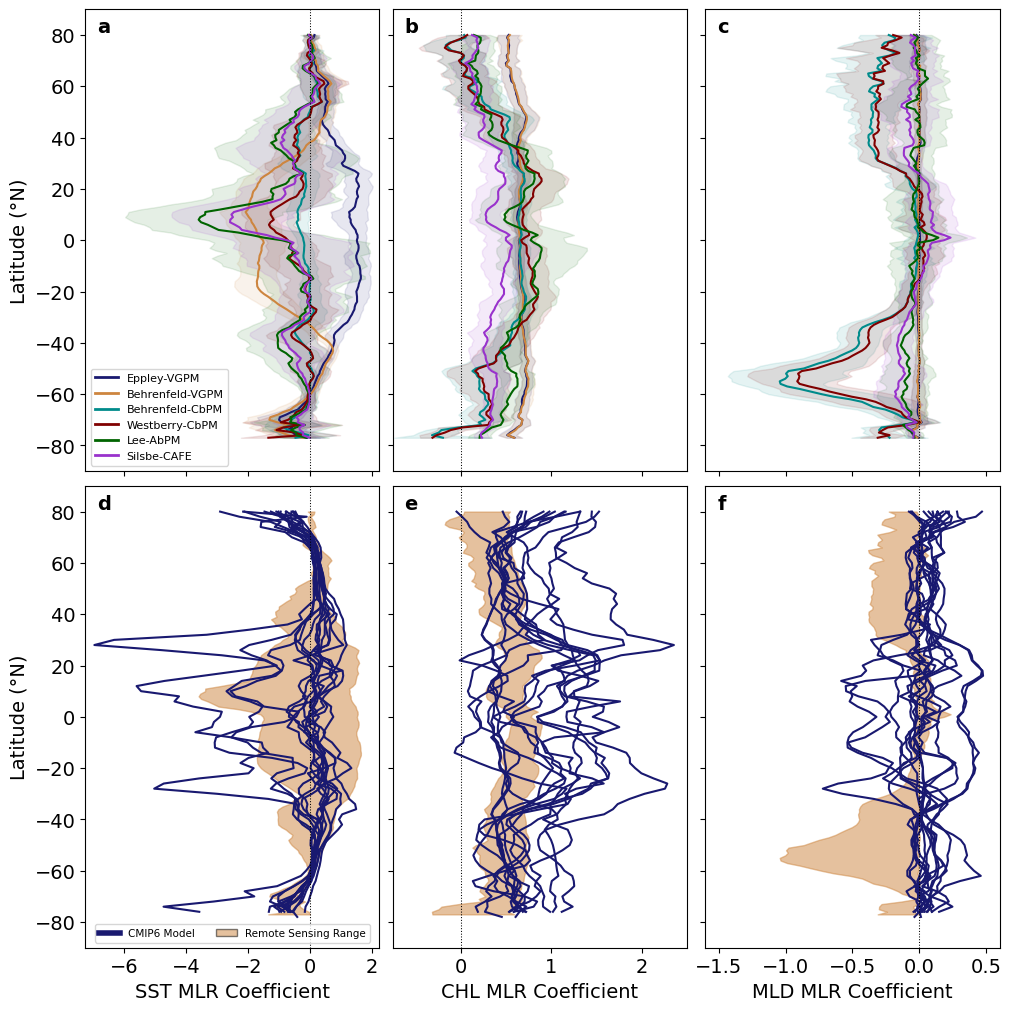

In [53]:
# Define colors for each model
colors = ['midnightblue', 'peru', 'darkcyan', 'maroon', 'darkgreen', 'darkorchid']
models = [
    ('Eppley-VGPM', remote_sensing_vars['vgpm1']),
    ('Behrenfeld-VGPM', remote_sensing_vars['vgpm2']),
    ('Behrenfeld-CbPM', remote_sensing_vars['cbpm1']),
    ('Westberry-CbPM', remote_sensing_vars['cbpm2']),
    ('Lee-AbPM', remote_sensing_vars['abpm']),
    ('Silsbe-CAFE', remote_sensing_vars['cafe'])
]

coef_types = ['sst_coef', 'chl_coef', 'mld_coef']
ylims = (-90, 90)
xlims = [(-7.25, 2.25), (-0.75, 2.5), (-1.6, 0.6)]
xlabel = ['SST MLR Coefficient', 'CHL MLR Coefficient', 'MLD MLR Coefficient']

# Initialize the figure and axes for 2x3 subplots
fig, axs = plt.subplots(2, 3, figsize=[10, 10], constrained_layout=True)
axs = axs.flatten()

# Loop through the three coefficient types and plot for each model
for ax, coef, xlim in zip(axs[:3], coef_types, xlims):
    for (label, data), color in zip(models, colors):
        # Interpolate the data for smooth plotting
        x = data.mean('lon')[coef].to_series().interpolate()
        y = data.mean('lon').lat_rnd
        ax.plot(x, y, color=color, label=label)
        
        # Add shaded regions for standard deviation
        x2 = data.std('lon')[coef].to_series().interpolate()
        ax.fill_betweenx(y, x + x2, x - x2, color=color, alpha=0.10)

    # Set the limits and vertical line for reference
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylims)
    ax.axvline(0, color='k', ls=':', lw=0.75)
    
    # Y-axis labels: remove them for non-first columns
    if coef != 'sst_coef':
        ax.set_yticklabels('')
    else:
        ax.set_ylabel('Latitude (°N)')
        
    ax.set_xticklabels('')

# Create custom legend for remote sensing models
handles = [Line2D([0], [0], color=color, lw=2, label=label) for (label, _), color in zip(models, colors)]
axs[0].legend(handles=handles, loc='lower left', fontsize=8)

# Define DataFrames for CMIP6 model coefficients
df_types = [df_sst, df_chl, df_mld]

# Plot CMIP6 models in the second row
for ax, coef, df_coef, xlim, xlab in zip(axs[3:], coef_types, df_types, xlims, xlabel):
    y = cmip_vars.mean('lon').lat_rnd
    
    # Plot all individual CMIP6 models
    for i in range(14):
        x = cmip_vars.mean('lon')[coef][i,:].to_series().interpolate()
        ax.plot(x, y, color=colors[0]) 

    # Add shaded region for CMIP6 model ranges
    y = df_coef.index
    ax.fill_betweenx(y, df_coef.min(axis=1), df_coef.max(axis=1), color=colors[1], alpha=0.5)

    # Set the limits and labels
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylims)
    ax.axvline(0, color='k', ls=':', lw=0.75)
    ax.set_xlabel(xlab)
    
    # Adjust y-axis labels
    if ax != axs[3]:  # Remove y-axis labels for all but the first subplot (SST)
        ax.set_yticklabels('')
    else:
        ax.set_ylabel('Latitude (°N)')

# Add legend for CMIP6 models and remote sensing range
legend_elements = [
    Line2D([0], [0], label='CMIP6 Model', color=colors[0], lw=4), 
    Patch(facecolor=colors[1], alpha=0.5, edgecolor='k', label='Remote Sensing Range')
]
axs[3].legend(handles=legend_elements, loc='lower center', fontsize=7.5, ncol=2)

# Add panel labels (a, b, c, etc.)
for ax, label in zip(axs, ['a', 'b', 'c', 'd', 'e', 'f']):
    ax.text(.04, 0.95, label, transform=ax.transAxes, fontsize=14, fontweight='bold')

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_03"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)

# Figure S5

## Load in data

In [54]:
# Names of Earth system models used in the analysis
models = ['ACCESS-ESM1-5', 'CESM2-WACCM', 'CESM2', 'CMCC-ESM2',
          'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3-CC',
          'GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR',
          'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM',
          'UKESM1-0-LL']

# Define file path and load files
fname = root_dir+'/DATA/STATS/MLR/CMIP6/*.nc'
flist = sorted(glob.glob(fname))  

# Initialize lists to store the data
cmip_rsq = []
cmip_variable = []

# Loop over files and process them
for file in flist:
    try:
        # Open dataset and filter p-values
        with xr.open_dataset(file) as ds:
            ds_filtered = ds.where(ds.f_pvalue < 0.05, drop=True)
            
            # Extract the necessary variables and rsquared value
            cmip_rsq.append(ds_filtered.rsquared)
            cmip_variable.append(ds_filtered[['sst_coef', 'mld_coef', 'chl_coef']])
    
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Concatenate the data along the 'model' dimension
cmip_rsq = xr.concat(cmip_rsq, dim=xr.DataArray(models, dims='model', name='model'))
cmip_variable = xr.concat(cmip_variable, dim=xr.DataArray(models, dims='model', name='model'))

## Plot the Figure

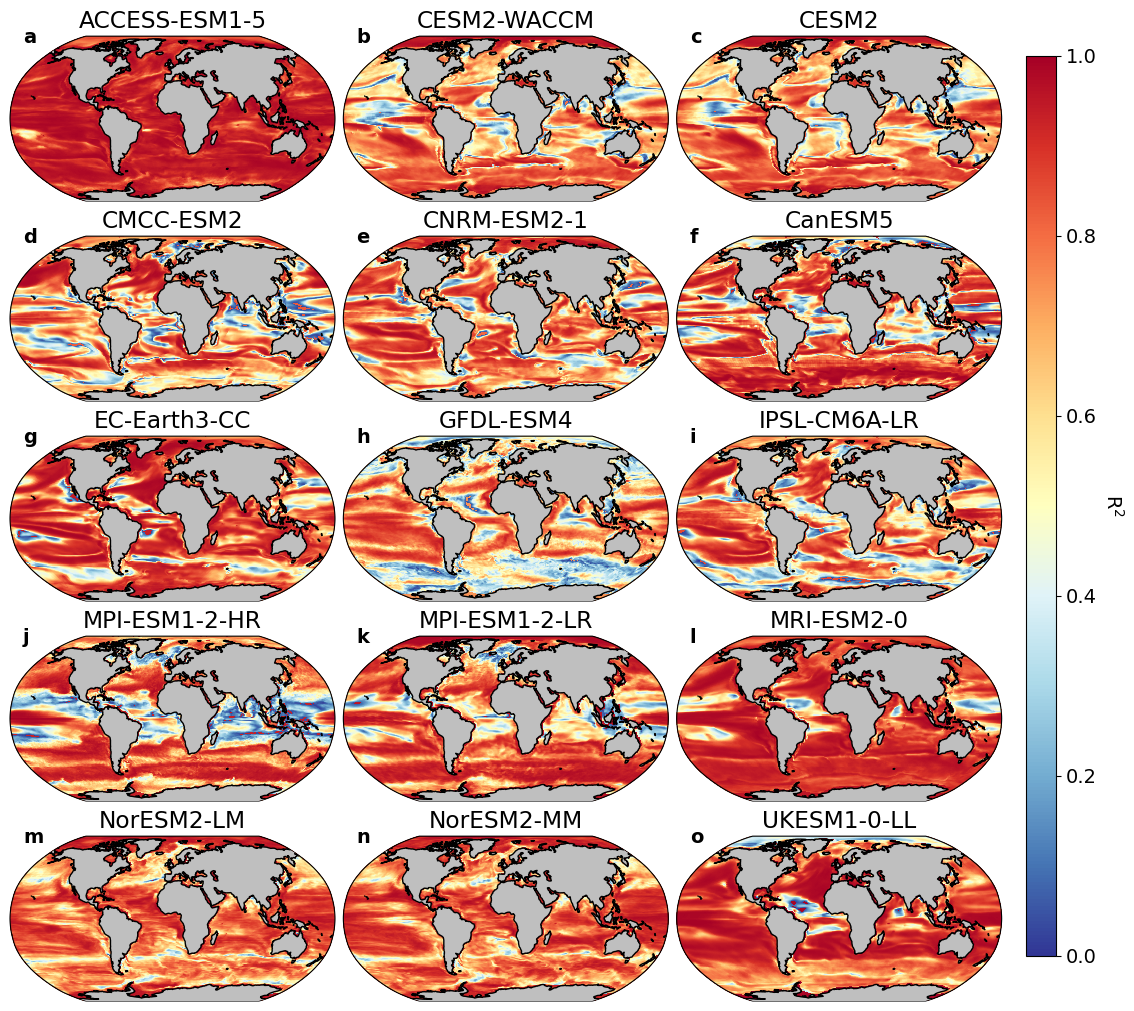

In [55]:
# Set the colormap limits
vmin = 0
vmax = 1

# Create the figure and GridSpec layout
fig = plt.figure(figsize=[10, 10], constrained_layout=True)
gs = GridSpec(5, 3, figure=fig)

cmap = plt.get_cmap('RdYlBu_r').copy()
cmap.set_bad(color='none')

# Define a function to streamline repetitive plot creation
def create_map(ax, model_idx, title, label):
    ax.add_feature(cartopy.feature.LAND, facecolor='0.75', zorder=5)
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1, zorder=5)
    ax.set_global()
    
    # Plot the data
    im = cmip_rsq.isel(model=model_idx).plot(ax=ax, add_colorbar=False, cmap=cmap, 
                                        vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    ax.set_title(title)

    # Add the label in bold
    ax.text(0.04, 0.96, label, transform=ax.transAxes, fontweight='bold')

    return im

# Create subplots and apply the function for each map
titles = [f'{model}' for model in models]   # Add titles for each model
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o']  # Labels for each subplot

for idx, (title, label) in enumerate(zip(titles, labels)):
    row = idx // 3  # Integer division to get the row index
    col = idx % 3   # Modulus to get the column index
    ax = fig.add_subplot(gs[row, col], projection=ccrs.Robinson())
    im = create_map(ax, model_idx=idx, title=title, label=label)

cbar_ax = fig.add_axes([1.02, 0.05, 0.03, 0.90])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('R$^2$', labelpad=20, rotation=270)

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_S05"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)

# Figure S6

## Define Earth Movers Distance Function

In [56]:
# Names of Earth system models used in the analysis
models = ['ACCESS-ESM1-5', 'CESM2-WACCM', 'CESM2', 'CMCC-ESM2',
          'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3-CC', 'GFDL-ESM4', 
          'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 
          'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL']

def compute_emd(df, df_biomes, cmip_df, models, pc, coef_name, iqr_factor=3, pc_weight=False):
    """Computes Wasserstein distances for each biome and model."""
    
    def compute_iqr_filter(data, iqr_factor=3):
        """Helper function to compute IQR-based filtering."""
        # Ensure that the data is a Series, then calculate the IQR and filtering thresholds
        iqr = data.quantile(0.75) - data.quantile(0.25)
        q1 = data.quantile(0.25) - (iqr * iqr_factor)
        q2 = data.quantile(0.75) + (iqr * iqr_factor)
        # Apply the condition for filtering, returning only values within the IQR range
        return data[(data >= q1) & (data <= q2)]

    emd_vals = []

    # Loop through biomes
    for j in range(1, 18):
        # Ensure that both df and df_biomes are aligned, and filter by biome
        df_filtered = df.where(df_biomes == j, drop=True).to_series().dropna()
        
        # Apply IQR filtering to the df_filtered for the current biome
        df_qc = compute_iqr_filter(df_filtered, iqr_factor)

        # Filter the CMIP dataset for the current biome
        cmip_model = cmip_df[cmip_df['biome'] == j]
        md = []  # list to store Wasserstein distances for each model

        # Loop through models
        for m in models:
            # Filter the CMIP data for the current model and the specified coefficient
            cmip_filtered = cmip_model[cmip_model['model'] == m][coef_name]
            # Apply IQR filtering to the CMIP data for the current model
            cmip_qc = compute_iqr_filter(cmip_filtered, iqr_factor)

            # Compute Wasserstein distance if both datasets are non-empty
            if cmip_qc.empty or df_qc.empty:
                wd = np.nan
            else:
                wd = wasserstein_distance(cmip_qc.values, df_qc.values)

            # Apply PC weighting if needed
            if pc_weight:
                wd *= pc.iloc[j - 1]
                
            md.append(wd)
        
        # Append the distances for the current biome
        emd_vals.append(md)
    
    # Convert results into a DataFrame
    emd_vals_df = pd.DataFrame(emd_vals, columns=models, index=bname[:-1]).T
    emd_vals_df['GLOBAL'] = emd_vals_df.mean(axis=1)
    
    return emd_vals_df

def calculate_pixel_area(xds, km_per_degree=111.1, m_per_km=1000):
    """Calculate the pixel area in m² for the given xarray dataset."""
    degrees_per_pixel = 180 / xds.lat.shape[0]
    pixel_area_equator_km2 = (degrees_per_pixel * km_per_degree) ** 2
    lat_rad = np.radians(xds['lat'])
    pixel_area = np.cos(lat_rad) * pixel_area_equator_km2
    pixel_area_2d = pixel_area.broadcast_like(xds)
    return pixel_area_2d * m_per_km**2  # Convert to m²

# Area and model preparation
fname = root_dir + '/DATA/Time_Varying_Biomes_25KM.nc'
biomes = xr.open_dataset(fname)
pixel_area_2d = calculate_pixel_area(biomes.MeanBiomes)
biomes['area'] = pixel_area_2d
data = biomes.to_dataframe()
data = data.groupby('MeanBiomes')['area'].sum()
pc = data / data.sum()  # Normalizing pixel area

# Loading CMIP biomes file
biome_file = root_dir + '/DATA/Time_Varying_Biomes_CMIP.nc'

# Open biome dataset
biomes = xr.open_dataset(biome_file)
biomes = biomes

# Loading CMIP6 data
cmip_files = sorted(glob.glob(root_dir + '/DATA/STATS/MLR/CMIP6/*.nc'))
cmip_sst, cmip_mld, cmip_chl = [], [], []

# Read CMIP6 data and filter
for file in cmip_files:
    ds = xr.open_dataset(file)
    ds['biomes'] = biomes.MeanBiomes.T
    ds = ds.where(ds.f_pvalue < 0.05, drop=True)
    name = file.split('/')[-1].split('_')[0]
    
    # Extract and organize data for each coefficient
    for coef, cmip_list in zip(['sst_coef', 'mld_coef', 'chl_coef'], [cmip_sst, cmip_mld, cmip_chl]):
        temp_df = ds[coef].to_dataframe()
        temp_df['model'] = name
        temp_df['biome'] = ds.biomes.to_series()
        cmip_list.append(temp_df)
        
# Concatenate all CMIP6 data into DataFrames
cmip_sst = pd.concat(cmip_sst).drop(columns=['depth'])
cmip_mld = pd.concat(cmip_mld).drop(columns=['depth'])
cmip_chl = pd.concat(cmip_chl).drop(columns=['depth'])



## Jackknife EMD

### Eppley-VGPM

In [57]:
vgpm1_dataset = xr.open_dataset(root_dir + '/DATA/STATS/MLR/REMOTE_SENSING/VGPM1_MLR_SST_CHL_MLD_JACKKNIFE.nc')
vgpm1_sst, vgpm1_chl, vgpm1_mld = [], [], []

# Compute EMD values for VGPM1 simulations
for i in tqdm(range(7)):
    ds = vgpm1_dataset.isel(simulation=i)
    ds = ds.where(ds.f_pvalue < 0.05, drop=True)
    
    # Calculate EMD values for each variable (SST, Chl, MLD)
    for coef, datalist in zip(['sst_coef', 'chl_coef', 'mld_coef'], [vgpm1_sst, vgpm1_chl, vgpm1_mld]):
        emd_vals = compute_emd(ds[coef], ds.biomes, cmip_sst if coef == 'sst_coef' else (cmip_chl if coef == 'chl_coef' else cmip_mld), 
                               models, pc, coef, iqr_factor=3, pc_weight=True)
        
        # Stack and prepare the results
        emd_vals = emd_vals.stack().reset_index()
        emd_vals.columns = ['model', 'biome', f'{coef}_emd']
        emd_vals['sim'] = i
        emd_vals = emd_vals.set_index(['model', 'biome', 'sim']).to_xarray()
        
        datalist.append(emd_vals)

# Concatenate results across simulations
vgpm1_sst = xr.concat(vgpm1_sst, dim='sim')
vgpm1_chl = xr.concat(vgpm1_chl, dim='sim')
vgpm1_mld = xr.concat(vgpm1_mld, dim='sim')

# Merge results
vgpm1_emd = xr.merge([vgpm1_sst, vgpm1_chl, vgpm1_mld])

100%|██████████| 7/7 [00:35<00:00,  5.05s/it]


### Behrenfeld-VGPM

In [58]:
vgpm2_dataset = xr.open_dataset(root_dir + '/DATA/STATS/MLR/REMOTE_SENSING/VGPM2_MLR_SST_CHL_MLD_JACKKNIFE.nc')
vgpm2_sst, vgpm2_chl, vgpm2_mld = [], [], []

# Compute EMD values for VGPM1 simulations
for i in tqdm(range(7)):
    ds = vgpm2_dataset.isel(simulation=i)
    ds = ds.where(ds.f_pvalue < 0.05, drop=True)
    
    # Calculate EMD values for each variable (SST, Chl, MLD)
    for coef, datalist in zip(['sst_coef', 'chl_coef', 'mld_coef'], [vgpm2_sst, vgpm2_chl, vgpm2_mld]):
        emd_vals = compute_emd(ds[coef], ds.biomes, cmip_sst if coef == 'sst_coef' else (cmip_chl if coef == 'chl_coef' else cmip_mld), 
                               models, pc, coef, iqr_factor=3, pc_weight=True)
        
        # Stack and prepare the results
        emd_vals = emd_vals.stack().reset_index()
        emd_vals.columns = ['model', 'biome', f'{coef}_emd']
        emd_vals['sim'] = i
        emd_vals = emd_vals.set_index(['model', 'biome', 'sim']).to_xarray()
        
        datalist.append(emd_vals)

# Concatenate results across simulations
vgpm2_sst = xr.concat(vgpm2_sst, dim='sim')
vgpm2_chl = xr.concat(vgpm2_chl, dim='sim')
vgpm2_mld = xr.concat(vgpm2_mld, dim='sim')

# Merge results
vgpm2_emd = xr.merge([vgpm2_sst, vgpm2_chl, vgpm2_mld])

100%|██████████| 7/7 [00:36<00:00,  5.21s/it]


### Behrenfeld-CbPM

In [59]:
cbpm1_dataset = xr.open_dataset(root_dir + '/DATA/STATS/MLR/REMOTE_SENSING/CBPM1_MLR_SST_CHL_MLD_JACKKNIFE.nc')
cbpm1_sst, cbpm1_chl, cbpm1_mld = [], [], []

# Compute EMD values for VGPM1 simulations
for i in tqdm(range(7)):
    ds = cbpm1_dataset.isel(simulation=i)
    ds = ds.where(ds.f_pvalue < 0.05, drop=True)
    
    # Calculate EMD values for each variable (SST, Chl, MLD)
    for coef, datalist in zip(['sst_coef', 'chl_coef', 'mld_coef'], [cbpm1_sst, cbpm1_chl, cbpm1_mld]):
        emd_vals = compute_emd(ds[coef], ds.biomes, cmip_sst if coef == 'sst_coef' else (cmip_chl if coef == 'chl_coef' else cmip_mld), 
                               models, pc, coef, iqr_factor=3, pc_weight=True)
        
        # Stack and prepare the results
        emd_vals = emd_vals.stack().reset_index()
        emd_vals.columns = ['model', 'biome', f'{coef}_emd']
        emd_vals['sim'] = i
        emd_vals = emd_vals.set_index(['model', 'biome', 'sim']).to_xarray()
        
        datalist.append(emd_vals)

# Concatenate results across simulations
cbpm1_sst = xr.concat(cbpm1_sst, dim='sim')
cbpm1_chl = xr.concat(cbpm1_chl, dim='sim')
cbpm1_mld = xr.concat(cbpm1_mld, dim='sim')

# Merge results
cbpm1_emd = xr.merge([cbpm1_sst, cbpm1_chl, cbpm1_mld])

100%|██████████| 7/7 [00:34<00:00,  5.00s/it]


### Westberry-CbPM

In [60]:
cbpm2_dataset = xr.open_dataset(root_dir + '/DATA/STATS/MLR/REMOTE_SENSING/CBPM2_MLR_SST_CHL_MLD_JACKKNIFE.nc')
cbpm2_sst, cbpm2_chl, cbpm2_mld = [], [], []

# Compute EMD values for VGPM1 simulations
for i in tqdm(range(7)):
    ds = cbpm2_dataset.isel(simulation=i)
    ds = ds.where(ds.f_pvalue < 0.05, drop=True)
    
    # Calculate EMD values for each variable (SST, Chl, MLD)
    for coef, datalist in zip(['sst_coef', 'chl_coef', 'mld_coef'], [cbpm2_sst, cbpm2_chl, cbpm2_mld]):
        emd_vals = compute_emd(ds[coef], ds.biomes, cmip_sst if coef == 'sst_coef' else (cmip_chl if coef == 'chl_coef' else cmip_mld), 
                               models, pc, coef, iqr_factor=3, pc_weight=True)
        
        # Stack and prepare the results
        emd_vals = emd_vals.stack().reset_index()
        emd_vals.columns = ['model', 'biome', f'{coef}_emd']
        emd_vals['sim'] = i
        emd_vals = emd_vals.set_index(['model', 'biome', 'sim']).to_xarray()
        
        datalist.append(emd_vals)

# Concatenate results across simulations
cbpm2_sst = xr.concat(cbpm2_sst, dim='sim')
cbpm2_chl = xr.concat(cbpm2_chl, dim='sim')
cbpm2_mld = xr.concat(cbpm2_mld, dim='sim')

# Merge results
cbpm2_emd = xr.merge([cbpm2_sst, cbpm2_chl, cbpm2_mld])

100%|██████████| 7/7 [00:35<00:00,  5.03s/it]


### Lee-AbPM

In [61]:
abpm_dataset = xr.open_dataset(root_dir + '/DATA/STATS/MLR/REMOTE_SENSING/ABPM_MLR_SST_CHL_MLD_JACKKNIFE.nc')
abpm_sst, abpm_chl, abpm_mld = [], [], []

# Compute EMD values for VGPM1 simulations
for i in tqdm(range(7)):
    ds = abpm_dataset.isel(simulation=i)
    ds = ds.where(ds.f_pvalue < 0.05, drop=True)
    
    # Calculate EMD values for each variable (SST, Chl, MLD)
    for coef, datalist in zip(['sst_coef', 'chl_coef', 'mld_coef'], [abpm_sst, abpm_chl, abpm_mld]):
        emd_vals = compute_emd(ds[coef], ds.biomes, cmip_sst if coef == 'sst_coef' else (cmip_chl if coef == 'chl_coef' else cmip_mld), 
                               models, pc, coef, iqr_factor=3, pc_weight=True)
        
        # Stack and prepare the results
        emd_vals = emd_vals.stack().reset_index()
        emd_vals.columns = ['model', 'biome', f'{coef}_emd']
        emd_vals['sim'] = i
        emd_vals = emd_vals.set_index(['model', 'biome', 'sim']).to_xarray()
        
        datalist.append(emd_vals)

# Concatenate results across simulations
abpm_sst = xr.concat(abpm_sst, dim='sim')
abpm_chl = xr.concat(abpm_chl, dim='sim')
abpm_mld = xr.concat(abpm_mld, dim='sim')

# Merge results
abpm_emd = xr.merge([abpm_sst, abpm_chl, abpm_mld])

100%|██████████| 7/7 [00:32<00:00,  4.67s/it]


### Silsbe-CAFE

In [62]:
cafe_dataset = xr.open_dataset(root_dir + '/DATA/STATS/MLR/REMOTE_SENSING/CAFE_MLR_SST_CHL_MLD_JACKKNIFE.nc')
cafe_sst, cafe_chl, cafe_mld = [], [], []

# Compute EMD values for VGPM1 simulations
for i in tqdm(range(7)):
    ds = cafe_dataset.isel(simulation=i)
    ds = ds.where(ds.f_pvalue < 0.05, drop=True)
    
    # Calculate EMD values for each variable (SST, Chl, MLD)
    for coef, datalist in zip(['sst_coef', 'chl_coef', 'mld_coef'], [cafe_sst, cafe_chl, cafe_mld]):
        emd_vals = compute_emd(ds[coef], ds.biomes, cmip_sst if coef == 'sst_coef' else (cmip_chl if coef == 'chl_coef' else cmip_mld), 
                               models, pc, coef, iqr_factor=3, pc_weight=True)
        
        # Stack and prepare the results
        emd_vals = emd_vals.stack().reset_index()
        emd_vals.columns = ['model', 'biome', f'{coef}_emd']
        emd_vals['sim'] = i
        emd_vals = emd_vals.set_index(['model', 'biome', 'sim']).to_xarray()
        
        datalist.append(emd_vals)

# Concatenate results across simulations
cafe_sst = xr.concat(cafe_sst, dim='sim')
cafe_chl = xr.concat(cafe_chl, dim='sim')
cafe_mld = xr.concat(cafe_mld, dim='sim')

# Merge results
cafe_emd = xr.merge([cafe_sst, cafe_chl, cafe_mld])

100%|██████████| 7/7 [00:31<00:00,  4.50s/it]


## Plot the Figure

/Users/tommyrk/opt/anaconda3/envs/pyth_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)


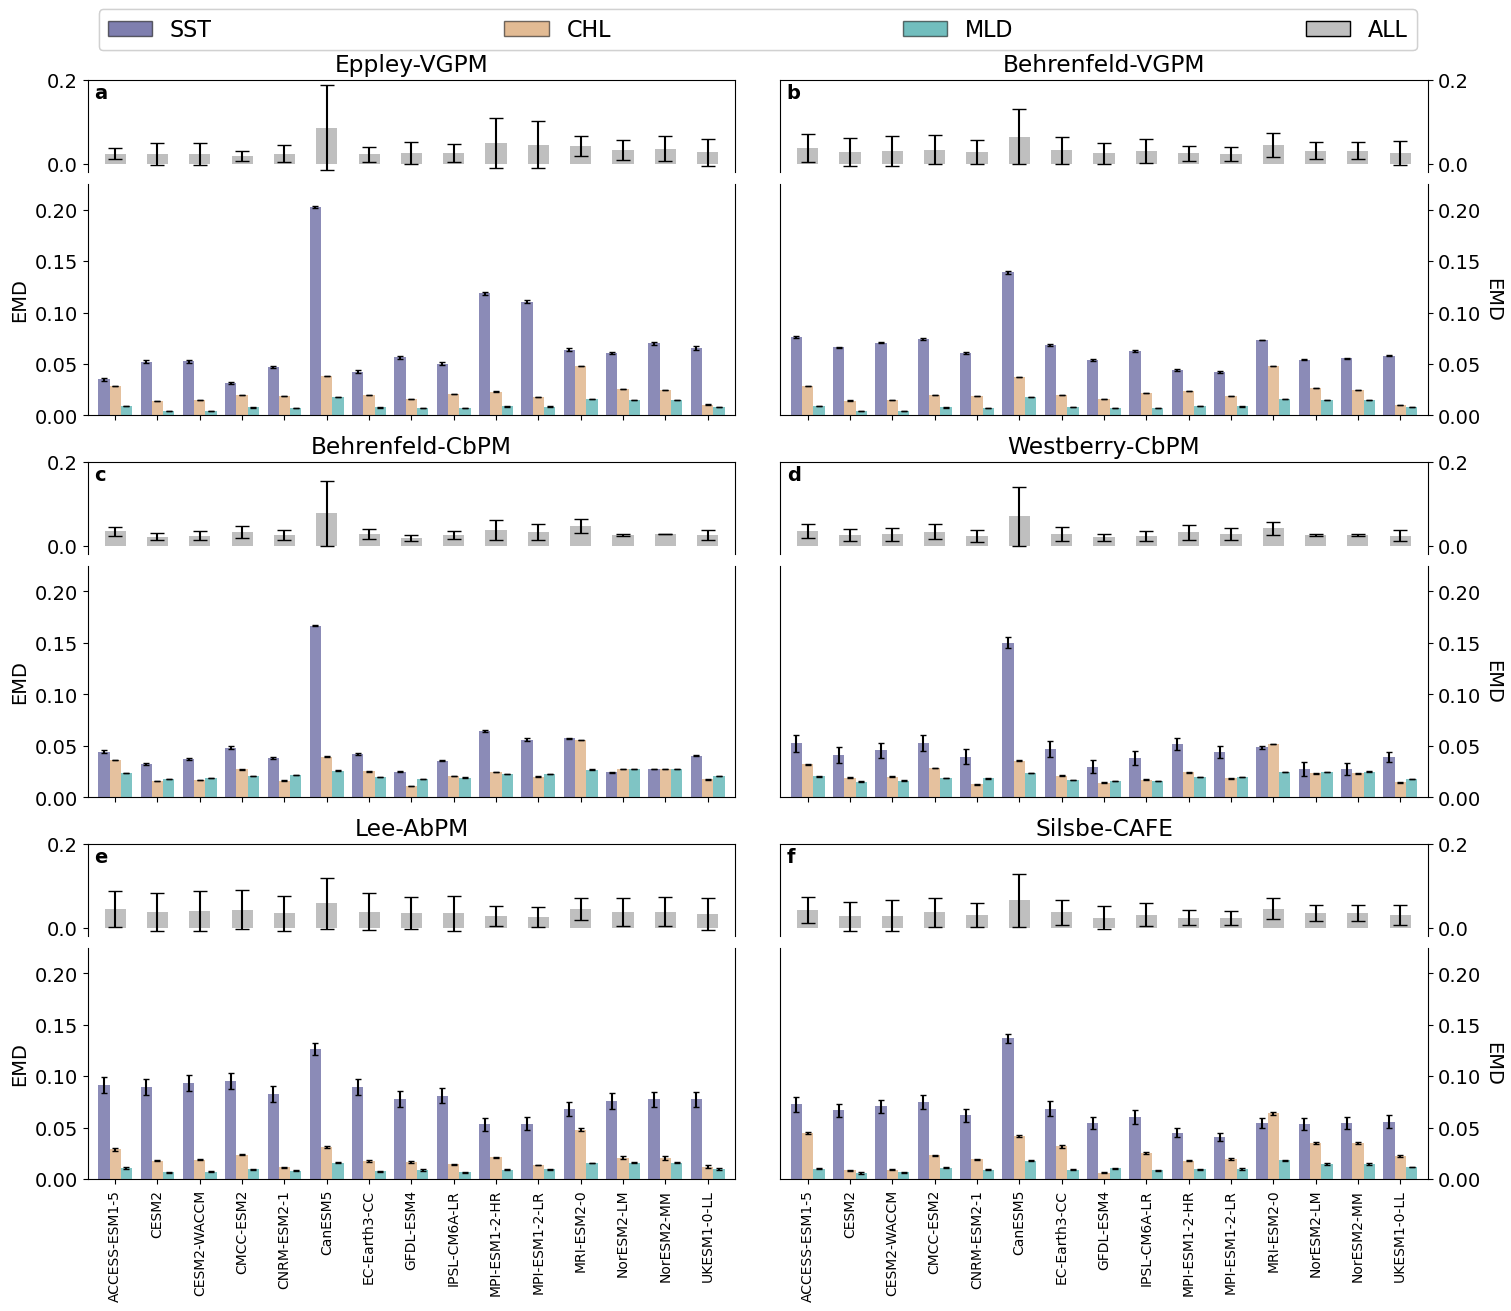

In [63]:
def calculate_summary_stats(emd_data):
    summary_stats = {}
    coef_names = ['sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']

    # Iterate over the coefficients and calculate summary stats
    for coef in coef_names:
        summary_stats[coef] = (emd_data.sel(biome='GLOBAL')
                                   .to_dataframe()[coef]
                                   .reset_index()
                                   .groupby('model')[coef]
                                   .agg(['mean', 'std'])
                                   .reset_index())
    
    # Combine means and standard deviations into one DataFrame
    data = pd.DataFrame({
        'SST': summary_stats['sst_coef_emd']['mean'],
        'CHL': summary_stats['chl_coef_emd']['mean'],
        'MLD': summary_stats['mld_coef_emd']['mean']
    })

    data_st = pd.DataFrame({
        'SST': summary_stats['sst_coef_emd']['std'],
        'CHL': summary_stats['chl_coef_emd']['std'],
        'MLD': summary_stats['mld_coef_emd']['std']
    })

    return data, data_st

fig = figure(figsize=[15,13], constrained_layout=True)
gs = GridSpec(6, 2, figure=fig, height_ratios=[0.4,1,0.4,1,0.4,1])
ax0 = fig.add_subplot(gs[1:2, :1])
ax0b = fig.add_subplot(gs[:1, :1])

ax1 = fig.add_subplot(gs[1:2, 1:])
ax1b = fig.add_subplot(gs[:1, 1:])

ax2 = fig.add_subplot(gs[3:4, :1])
ax2b = fig.add_subplot(gs[2:3, :1])

ax3 = fig.add_subplot(gs[3:4, 1:])
ax3b = fig.add_subplot(gs[2:3, 1:])

ax4 = fig.add_subplot(gs[5:, :1])
ax4b = fig.add_subplot(gs[4:5, :1])

ax5 = fig.add_subplot(gs[5:, 1:])
ax5b = fig.add_subplot(gs[4:5, 1:])

# Create a list of the models and corresponding axes
models = ['vgpm1', 'vgpm2', 'cbpm1', 'cbpm2', 'abpm', 'cafe']
axes = [(ax0, ax0b), (ax1, ax1b), (ax2, ax2b), (ax3, ax3b), (ax4, ax4b), (ax5, ax5b)]

# Loop over the models and plot the corresponding data
for i, (model, (ax, axb)) in enumerate(zip(models, axes)):
    data, data_st = calculate_summary_stats(eval(f'{model}_emd'))  # dynamically use the model name
    data.plot.bar(ax=ax, color=colors, width=0.8, legend=False, yerr=data_st, capsize=2, alpha=0.5)
    data.mean(axis=1).plot.bar(ax=axb, color='0.75', yerr=data.std(axis=1), capsize=5)

ax0.set_xticklabels('')
ax1.set_xticklabels('')
ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax0b.set_xticklabels('')
ax1b.set_xticklabels('')
ax2b.set_xticklabels('')
ax3b.set_xticklabels('')
ax4.set_xticklabels(vgpm1_emd.model.values, fontsize=10)
ax5.set_xticklabels(vgpm1_emd.model.values, fontsize=10)

ax0.set_ylim(0, 0.225)
ax1.set_ylim(0, 0.225)
ax2.set_ylim(0, 0.225)
ax3.set_ylim(0, 0.225)
ax4.set_ylim(0, 0.225)
ax5.set_ylim(0, 0.225)

ax0b.set_ylim(-0.02, 0.2)
ax1b.set_ylim(-0.02, 0.2)
ax2b.set_ylim(-0.02, 0.2)
ax3b.set_ylim(-0.02, 0.2)
ax4b.set_ylim(-0.02, 0.2)
ax5b.set_ylim(-0.02, 0.2)

ax0b.set_xlim(ax0.get_xlim())
ax1b.set_xlim(ax0.get_xlim())
ax2b.set_xlim(ax0.get_xlim())
ax3b.set_xlim(ax0.get_xlim())
ax4b.set_xlim(ax0.get_xlim())
ax5b.set_xlim(ax0.get_xlim())

legend_elements = [Patch(facecolor=colors[0], edgecolor='k', alpha=0.5,
                         label='SST'),
                   Patch(facecolor=colors[1], edgecolor='k', alpha=0.5,
                         label='CHL'),
                   Patch(facecolor=colors[2], edgecolor='k', alpha=0.5,
                         label='MLD'),
                   Patch(facecolor='0.75', edgecolor='k',
                         label='ALL')] 

legend_ax = fig.add_subplot(gs[0, :])
legend_ax.axis('off')
legend_ax.legend(handles=legend_elements, loc='lower left', fontsize=16,
                 bbox_to_anchor=(0, 1.20, 1.0, 0.3), ncol=5, mode='expand')

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax5.yaxis.set_label_position("right")
ax5.yaxis.tick_right()
ax1b.yaxis.set_label_position("right")
ax1b.yaxis.tick_right()
ax3b.yaxis.set_label_position("right")
ax3b.yaxis.tick_right()
ax5b.yaxis.set_label_position("right")
ax5b.yaxis.tick_right()

ax0b.spines[['bottom']].set_visible(False)
ax1b.spines[['bottom']].set_visible(False)
ax2b.spines[['bottom']].set_visible(False)
ax3b.spines[['bottom']].set_visible(False)
ax4b.spines[['bottom']].set_visible(False)
ax5b.spines[['bottom']].set_visible(False)

ax0.spines[['top']].set_visible(False)
ax1.spines[['top']].set_visible(False)
ax2.spines[['top']].set_visible(False)
ax3.spines[['top']].set_visible(False)
ax4.spines[['top']].set_visible(False)
ax5.spines[['top']].set_visible(False)

ax0b.xaxis.set_tick_params(labelbottom=False)
ax0b.set_xticks([])
ax1b.xaxis.set_tick_params(labelbottom=False)
ax1b.set_xticks([])
ax2b.xaxis.set_tick_params(labelbottom=False)
ax2b.set_xticks([])
ax3b.xaxis.set_tick_params(labelbottom=False)
ax3b.set_xticks([])
ax4b.xaxis.set_tick_params(labelbottom=False)
ax4b.set_xticks([])
ax5b.xaxis.set_tick_params(labelbottom=False)
ax5b.set_xticks([])

ax0b.text(.01, 0.80, 'a', transform=ax0b.transAxes, fontsize=14, fontweight='bold')
ax1b.text(.01, 0.80, 'b', transform=ax1b.transAxes, fontsize=14, fontweight='bold')
ax2b.text(.01, 0.80, 'c', transform=ax2b.transAxes, fontsize=14, fontweight='bold')
ax3b.text(.01, 0.80, 'd', transform=ax3b.transAxes, fontsize=14, fontweight='bold')
ax4b.text(.01, 0.80, 'e', transform=ax4b.transAxes, fontsize=14, fontweight='bold')
ax5b.text(.01, 0.80, 'f', transform=ax5b.transAxes, fontsize=14, fontweight='bold')

ax0b.set_title('Eppley-VGPM')
ax1b.set_title('Behrenfeld-VGPM')
ax2b.set_title('Behrenfeld-CbPM')
ax3b.set_title('Westberry-CbPM')
ax4b.set_title('Lee-AbPM')
ax5b.set_title('Silsbe-CAFE')

ax0.set_ylabel('EMD')
ax1.set_ylabel('EMD', rotation=270, labelpad=15)
ax2.set_ylabel('EMD')
ax3.set_ylabel('EMD', rotation=270, labelpad=15)
ax4.set_ylabel('EMD')
ax5.set_ylabel('EMD', rotation=270, labelpad=15)

# Add legend and save the figure
legend_elements = [
    Patch(facecolor=colors[0], edgecolor='k', alpha=0.5, label='SST'),
    Patch(facecolor=colors[1], edgecolor='k', alpha=0.5, label='CHL'),
    Patch(facecolor=colors[2], edgecolor='k', alpha=0.5, label='MLD'),
    Patch(facecolor='0.75', edgecolor='k', label='ALL')
]
legend_ax = fig.add_subplot(gs[0, :])
legend_ax.axis('off')
legend_ax.legend(handles=legend_elements, loc='lower left', fontsize=16,
                 bbox_to_anchor=(0, 1.20, 1.0, 0.3), ncol=5, mode='expand')

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_S06"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)

# Figure 4

## Use output from Figure S6 to perform ranking exercise

In [64]:
# Names of Earth system models used in the analysis
models = ['ACCESS-ESM1-5', 'CESM2-WACCM', 'CESM2', 'CMCC-ESM2',
          'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3-CC', 'GFDL-ESM4', 
          'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 
          'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL']

data1 = vgpm1_emd.sel(biome='GLOBAL').to_dataframe()
data1['EMD_mean'] = data1[['sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']].mean(axis=1)
data1['EMD_stdev'] = data1[['sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']].std(axis=1)
data1 = data1.drop(columns=['biome', 'sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']).sort_values(['sim', 'model'])

# Create empty lists for z-scores
z_scores1 = []
z_scores2 = []

# Calculate z-scores for each 'sim'
for i in range(7):
    df = data1.loc[data1.index.get_level_values(1) == i].copy()
    z_scores1.extend(zscore(df['EMD_mean']))
    z_scores2.extend(zscore(df['EMD_stdev']))

# Assign the z-scores back to data1; make sure lengths match
data1['EMD_mean_zscore'] = z_scores1
data1['EMD_stdev_zscore'] = z_scores2
data1['Combined_zscore'] = data1[['EMD_mean_zscore', 'EMD_stdev_zscore']].mean(axis=1)
idx = data1.loc[data1.index.get_level_values(1) == 1].index.get_level_values(0)
data1['Delta_NPP'] = pd.concat([delta_pg_npp.reindex(idx)]*7).values

data1 = data1.sort_values(by=['sim', 'Combined_zscore'])
data1['ranking'] = list(range(1, len(models)+1)) * 7

vgpm1_delta_npp = data1.groupby('ranking').agg(
    mean_Delta_NPP=('Delta_NPP', 'mean'),
    std_Delta_NPP=('Delta_NPP', lambda x: x.std(ddof=1)),
    mean_zscore=('Combined_zscore', 'mean')).reset_index()

data2 = vgpm2_emd.sel(biome='GLOBAL').to_dataframe()
data2['EMD_mean'] = data2[['sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']].mean(axis=1)
data2['EMD_stdev'] = data2[['sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']].std(axis=1)
data2 = data2.drop(columns=['biome', 'sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']).sort_values(['sim', 'model'])

# Create empty lists for z-scores
z_scores1 = []
z_scores2 = []

# Calculate z-scores for each 'sim'
for i in range(7):
    df = data2.loc[data2.index.get_level_values(1) == i].copy()
    z_scores1.extend(zscore(df['EMD_mean']))
    z_scores2.extend(zscore(df['EMD_stdev']))

# Assign the z-scores back to data1; make sure lengths match
data2['EMD_mean_zscore'] = z_scores1
data2['EMD_stdev_zscore'] = z_scores2
data2['Combined_zscore'] = data2[['EMD_mean_zscore', 'EMD_stdev_zscore']].mean(axis=1)
idx = data2.loc[data2.index.get_level_values(1) == 1].index.get_level_values(0)
data2['Delta_NPP'] = pd.concat([delta_pg_npp.reindex(idx)]*7).values

data2 = data2.sort_values(by=['sim', 'Combined_zscore'])
data2['ranking'] = list(range(1, len(models)+1)) * 7

vgpm2_delta_npp = data2.groupby('ranking').agg(
    mean_Delta_NPP=('Delta_NPP', 'mean'),
    std_Delta_NPP=('Delta_NPP', lambda x: x.std(ddof=1)),
    mean_zscore=('Combined_zscore', 'mean')).reset_index()

data3 = cbpm1_emd.sel(biome='GLOBAL').to_dataframe()
data3['EMD_mean'] = data3[['sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']].mean(axis=1)
data3['EMD_stdev'] = data3[['sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']].std(axis=1)
data3 = data3.drop(columns=['biome', 'sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']).sort_values(['sim', 'model'])

# Create empty lists for z-scores
z_scores1 = []
z_scores2 = []

# Calculate z-scores for each 'sim'
for i in range(7):
    df = data3.loc[data3.index.get_level_values(1) == i].copy()
    z_scores1.extend(zscore(df['EMD_mean']))
    z_scores2.extend(zscore(df['EMD_stdev']))

# Assign the z-scores back to data1; make sure lengths match
data3['EMD_mean_zscore'] = z_scores1
data3['EMD_stdev_zscore'] = z_scores2
data3['Combined_zscore'] = data3[['EMD_mean_zscore', 'EMD_stdev_zscore']].mean(axis=1)
idx = data3.loc[data3.index.get_level_values(1) == 1].index.get_level_values(0)
data3['Delta_NPP'] = pd.concat([delta_pg_npp.reindex(idx)]*7).values

data3 = data3.sort_values(by=['sim', 'Combined_zscore'])
data3['ranking'] = list(range(1, len(models)+1)) * 7

cbpm1_delta_npp = data3.groupby('ranking').agg(
    mean_Delta_NPP=('Delta_NPP', 'mean'),
    std_Delta_NPP=('Delta_NPP', lambda x: x.std(ddof=1)),
    mean_zscore=('Combined_zscore', 'mean')).reset_index()

data4 = cbpm2_emd.sel(biome='GLOBAL').to_dataframe()
data4['EMD_mean'] = data4[['sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']].mean(axis=1)
data4['EMD_stdev'] = data4[['sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']].std(axis=1)
data4 = data4.drop(columns=['biome', 'sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']).sort_values(['sim', 'model'])

# Create empty lists for z-scores
z_scores1 = []
z_scores2 = []

# Calculate z-scores for each 'sim'
for i in range(7):
    df = data4.loc[data4.index.get_level_values(1) == i].copy()
    z_scores1.extend(zscore(df['EMD_mean']))
    z_scores2.extend(zscore(df['EMD_stdev']))

# Assign the z-scores back to data1; make sure lengths match
data4['EMD_mean_zscore'] = z_scores1
data4['EMD_stdev_zscore'] = z_scores2
data4['Combined_zscore'] = data4[['EMD_mean_zscore', 'EMD_stdev_zscore']].mean(axis=1)
idx = data4.loc[data4.index.get_level_values(1) == 1].index.get_level_values(0)
data4['Delta_NPP'] = pd.concat([delta_pg_npp.reindex(idx)]*7).values

data4 = data4.sort_values(by=['sim', 'Combined_zscore'])
data4['ranking'] = list(range(1, len(models)+1)) * 7

cbpm2_delta_npp = data4.groupby('ranking').agg(
    mean_Delta_NPP=('Delta_NPP', 'mean'),
    std_Delta_NPP=('Delta_NPP', lambda x: x.std(ddof=1)),
    mean_zscore=('Combined_zscore', 'mean')).reset_index()

data5 = abpm_emd.sel(biome='GLOBAL').to_dataframe()
data5['EMD_mean'] = data5[['sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']].mean(axis=1)
data5['EMD_stdev'] = data5[['sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']].std(axis=1)
data5 = data5.drop(columns=['biome', 'sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']).sort_values(['sim', 'model'])

# Create empty lists for z-scores
z_scores1 = []
z_scores2 = []

# Calculate z-scores for each 'sim'
for i in range(7):
    df = data5.loc[data5.index.get_level_values(1) == i].copy()
    z_scores1.extend(zscore(df['EMD_mean']))
    z_scores2.extend(zscore(df['EMD_stdev']))

# Assign the z-scores back to data1; make sure lengths match
data5['EMD_mean_zscore'] = z_scores1
data5['EMD_stdev_zscore'] = z_scores2
data5['Combined_zscore'] = data5[['EMD_mean_zscore', 'EMD_stdev_zscore']].mean(axis=1)
idx = data5.loc[data5.index.get_level_values(1) == 1].index.get_level_values(0)
data5['Delta_NPP'] = pd.concat([delta_pg_npp.reindex(idx)]*7).values

data5 = data5.sort_values(by=['sim', 'Combined_zscore'])
data5['ranking'] = list(range(1, len(models)+1)) * 7

abpm_delta_npp = data5.groupby('ranking').agg(
    mean_Delta_NPP=('Delta_NPP', 'mean'),
    std_Delta_NPP=('Delta_NPP', lambda x: x.std(ddof=1)),
    mean_zscore=('Combined_zscore', 'mean')).reset_index()

data6 = cafe_emd.sel(biome='GLOBAL').to_dataframe()
data6['EMD_mean'] = data6[['sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']].mean(axis=1)
data6['EMD_stdev'] = data6[['sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']].std(axis=1)
data6 = data6.drop(columns=['biome', 'sst_coef_emd', 'chl_coef_emd', 'mld_coef_emd']).sort_values(['sim', 'model'])

# Create empty lists for z-scores
z_scores1 = []
z_scores2 = []

# Calculate z-scores for each 'sim'
for i in range(7):
    df = data6.loc[data6.index.get_level_values(1) == i].copy()
    z_scores1.extend(zscore(df['EMD_mean']))
    z_scores2.extend(zscore(df['EMD_stdev']))

# Assign the z-scores back to data1; make sure lengths match
data6['EMD_mean_zscore'] = z_scores1
data6['EMD_stdev_zscore'] = z_scores2
data6['Combined_zscore'] = data6[['EMD_mean_zscore', 'EMD_stdev_zscore']].mean(axis=1)
idx = data6.loc[data6.index.get_level_values(1) == 1].index.get_level_values(0)
data6['Delta_NPP'] = pd.concat([delta_pg_npp.reindex(idx)]*7).values

data6 = data6.sort_values(by=['sim', 'Combined_zscore'])
data6['ranking'] = list(range(1, len(models)+1)) * 7

cafe_delta_npp = data6.groupby('ranking').agg(
    mean_Delta_NPP=('Delta_NPP', 'mean'),
    std_Delta_NPP=('Delta_NPP', lambda x: x.std(ddof=1)),  # Add ddof=1 here
    mean_zscore=('Combined_zscore', 'mean')
).reset_index()

## Plot the Figure

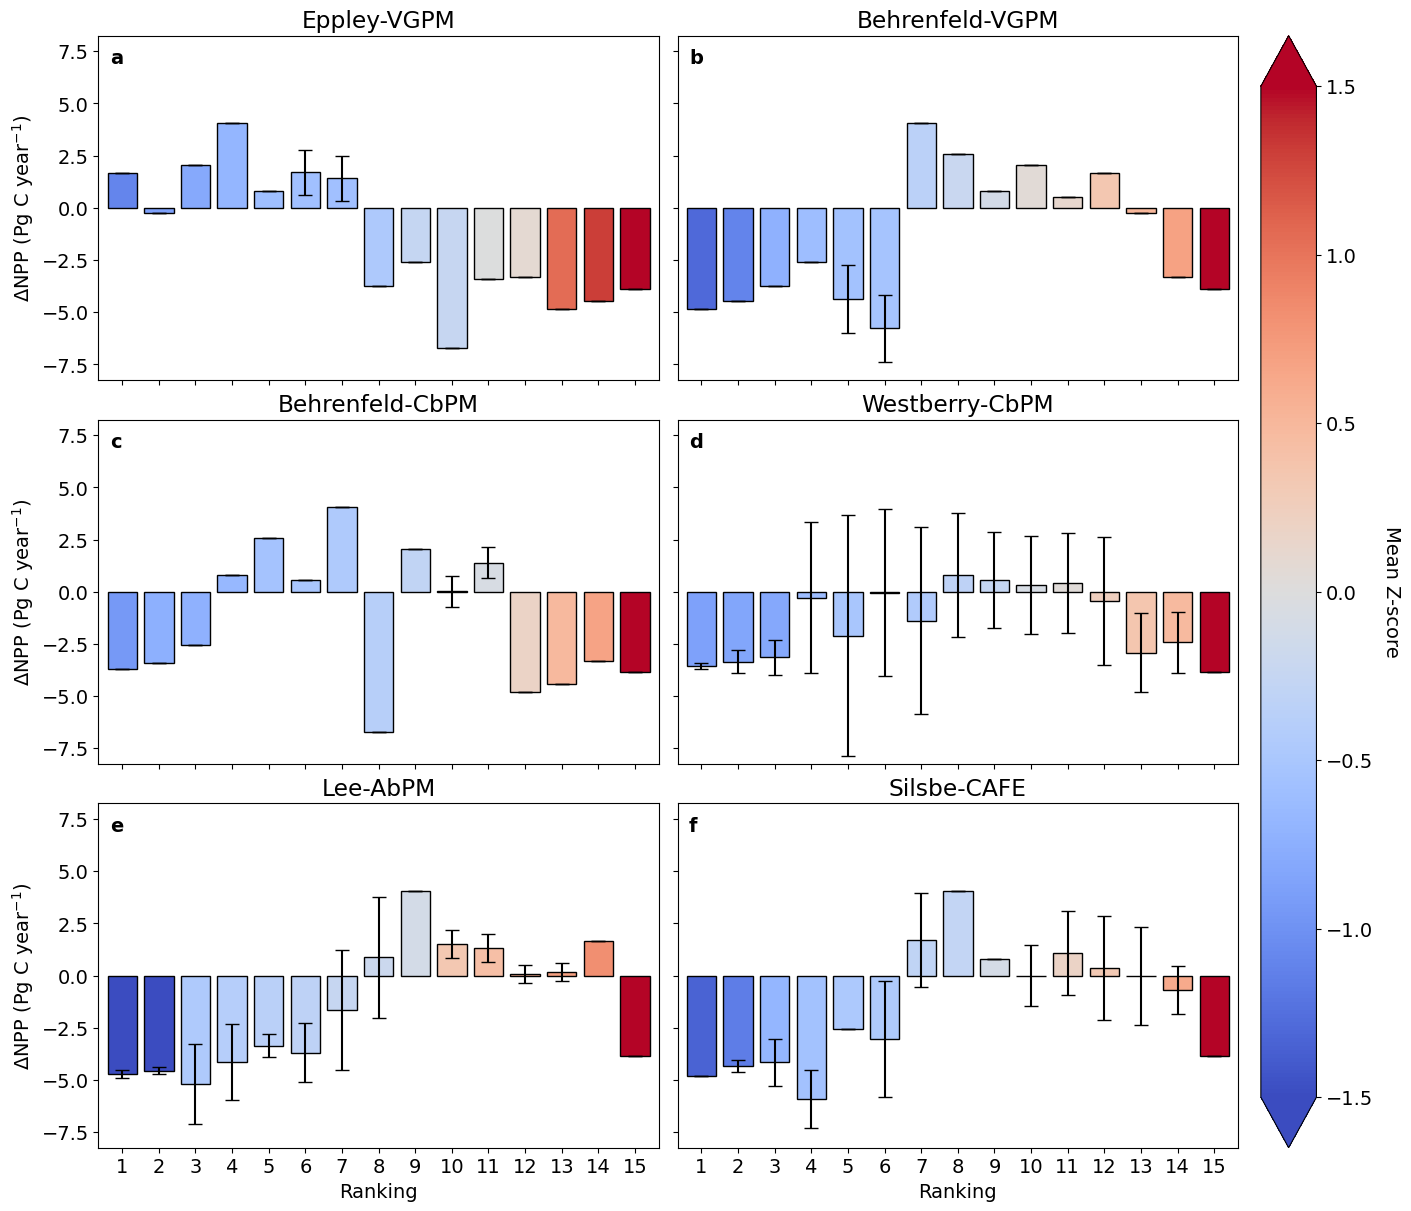

In [65]:
mean_vals_list = [vgpm1_delta_npp, vgpm2_delta_npp, cbpm1_delta_npp, cbpm2_delta_npp, abpm_delta_npp, cafe_delta_npp]

# Concatenate mean_zscore values to find global min and max
all_zscores = pd.concat([mean_vals.mean_zscore for mean_vals in mean_vals_list])
global_min = all_zscores.min()
global_max = all_zscores.max()

global_min = -1.25
global_max = 1.25

# Create figure and GridSpec layout
fig = plt.figure(figsize=[14, 12], constrained_layout=True)
gs = GridSpec(3, 2, figure=fig)

# Create a colormap
cmap = plt.get_cmap('coolwarm')

# Define a list of letters from a to o
letters = [chr(i) for i in range(ord('a'), ord('o') + 1)]

titles = [
    'Eppley-VGPM',
    'Behrenfeld-VGPM',
    'Behrenfeld-CbPM',
    'Westberry-CbPM',
    'Lee-AbPM',
    'Silsbe-CAFE'
]

# Loop through datasets and create subplots
for i, mean_vals in enumerate(mean_vals_list):
    ax = fig.add_subplot(gs[i // 2, i % 2])  # Create subplots in a 3x2 grid

    # Normalize z-scores using global min and max
    normed_zscores = (mean_vals.mean_zscore - global_min) / (global_max - global_min)
    colors = cmap(normed_zscores)

    # Create the bar plot
    mean_vals.mean_Delta_NPP.plot(ax=ax, kind='bar', color=colors, edgecolor='k', width=0.8, yerr=mean_vals.std_Delta_NPP, capsize=5)

    # Map x-tick labels based on model_idx
    ax.set_xticks(range(len(mean_vals)))  # Set the x-ticks to match the number of bars
    ax.set_xticklabels(np.arange(1, len(models)+1, 1), rotation=0)
    ax.text(0.02, 0.92, letters[i], transform=ax.transAxes, fontsize=14, fontweight='bold')
    ax.set_title(titles[i])
    if i == 0  or i == 2 or i == 4:
        ax.set_ylabel('ΔNPP (Pg C year$^{-1}$)')
    else:
        ax.set_yticklabels('')
    if i == 4 or i == 5:
        ax.set_xlabel('Ranking')
    else:
        ax.set_xticklabels('')
        
    ax.set_ylim(-8.25, 8.25)

# Create ScalarMappable for color normalization
norm = plt.Normalize(-1.5, 1.5)
smap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
smap.set_array([])  # Necessary for colorbar in some versions

# Add colorbar to the figure
cbar = fig.colorbar(smap, ax=fig.get_axes(), orientation='vertical', pad=0.02, extend='both')
cbar.set_label('Mean Z-score', rotation=270, labelpad=20)

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_04"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)

# Figure S7

## Use output from Figure S6 to generate Z-score heatmaps

In [66]:
vgpm1_data = data1.reset_index().set_index(['sim', 'ranking'])
vgpm1_scores = vgpm1_data.Combined_zscore.unstack().T
vgpm1_models = vgpm1_data.model.unstack().T
vgpm1_scores_std = vgpm1_scores.std(axis=1)

vgpm2_data = data2.reset_index().set_index(['sim', 'ranking'])
vgpm2_scores = vgpm2_data.Combined_zscore.unstack().T
vgpm2_models = vgpm2_data.model.unstack().T
vgpm2_scores_std = vgpm2_scores.std(axis=1)

cbpm1_data = data3.reset_index().set_index(['sim', 'ranking'])
cbpm1_scores = cbpm1_data.Combined_zscore.unstack().T
cbpm1_models = cbpm1_data.model.unstack().T
cbpm1_scores_std = cbpm1_scores.std(axis=1)

cbpm2_data = data4.reset_index().set_index(['sim', 'ranking'])
cbpm2_scores = cbpm2_data.Combined_zscore.unstack().T
cbpm2_models = cbpm2_data.model.unstack().T
cbpm2_scores_std = cbpm2_scores.std(axis=1)

abpm_data = data5.reset_index().set_index(['sim', 'ranking'])
abpm_scores = abpm_data.Combined_zscore.unstack().T
abpm_models = abpm_data.model.unstack().T
abpm_scores_std = abpm_scores.std(axis=1)

cafe_data = data6.reset_index().set_index(['sim', 'ranking'])
cafe_scores = cafe_data.Combined_zscore.unstack().T
cafe_models = cafe_data.model.unstack().T
cafe_scores_std = cafe_scores.std(axis=1)

## Plot the Figure

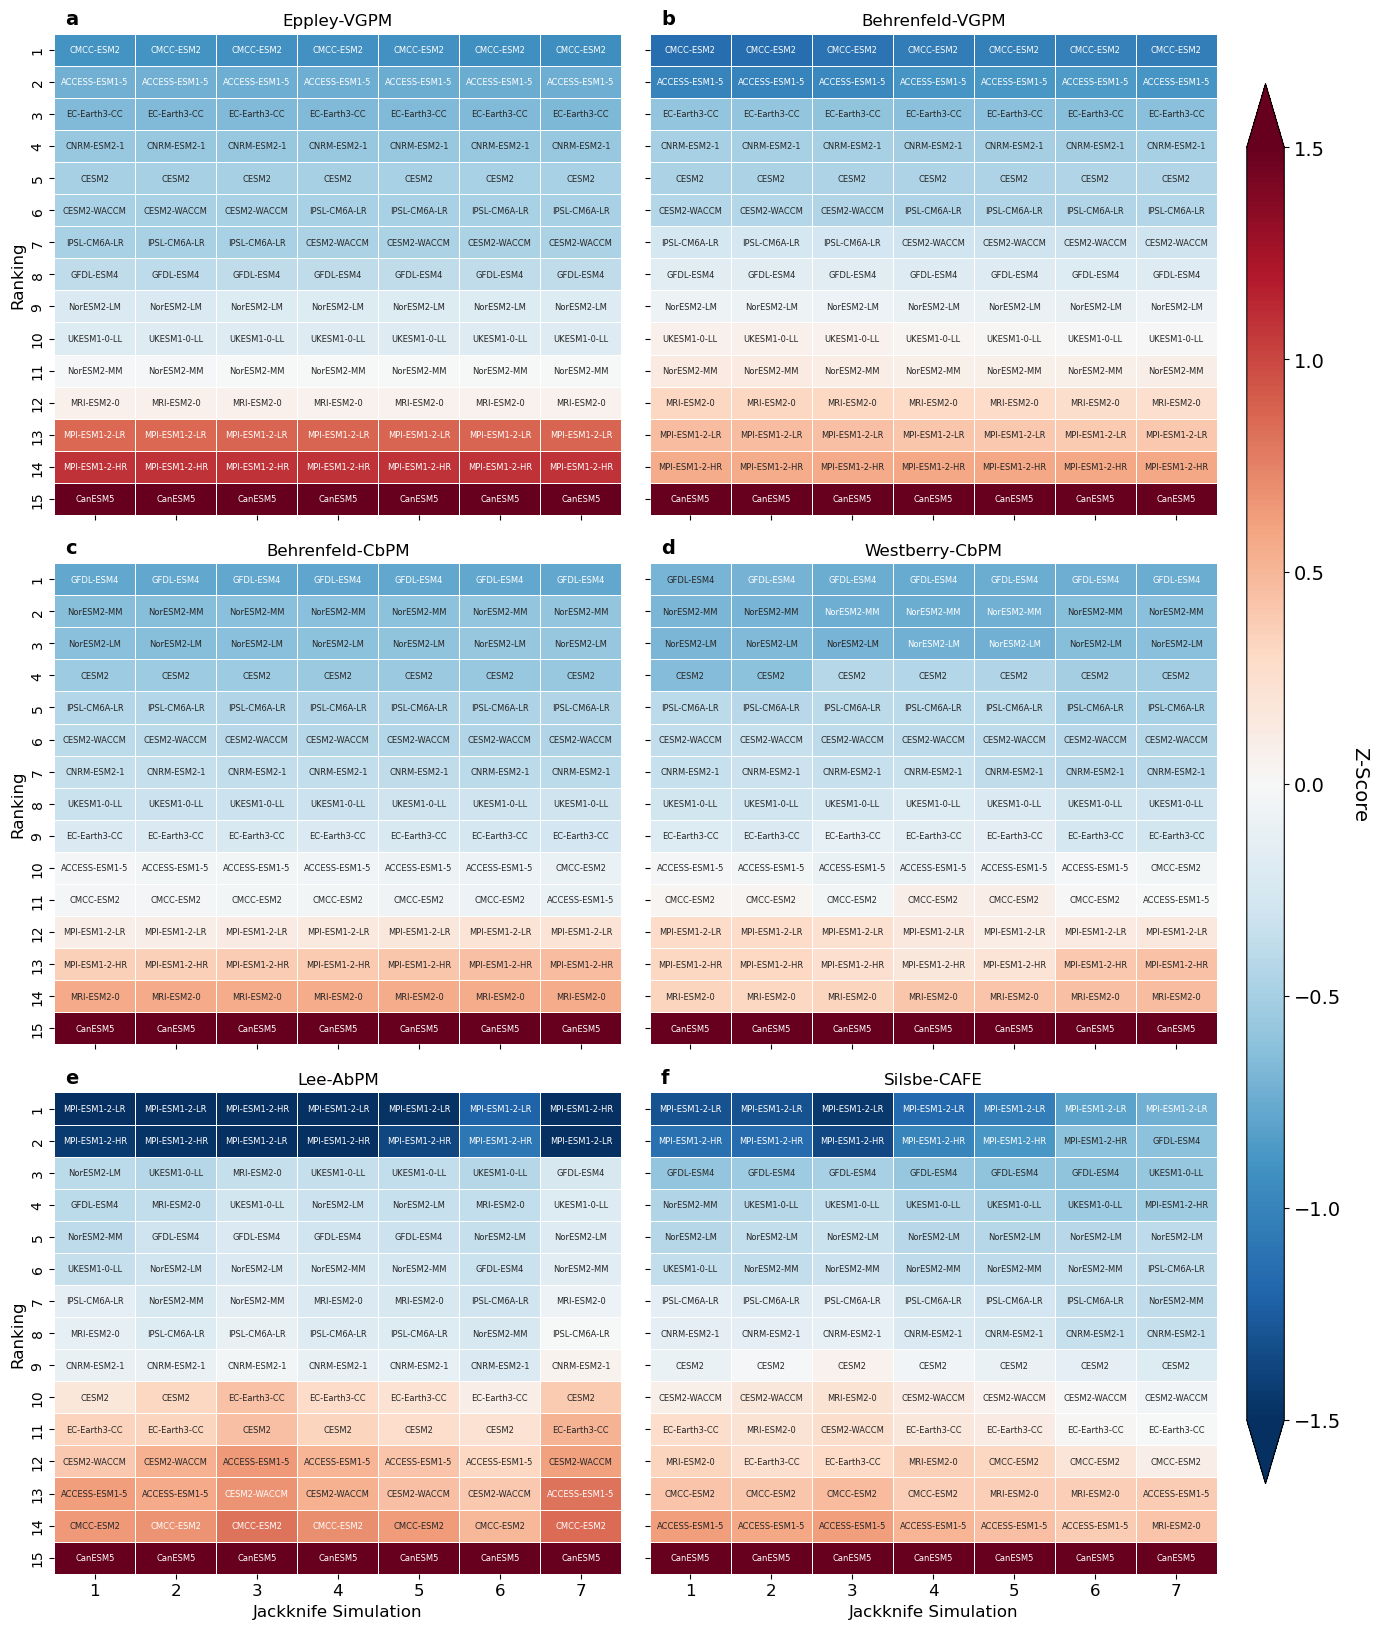

In [67]:
# Create the figure
fig = plt.figure(figsize=(15, 20))

# Create a GridSpec with 3 rows and 2 columns
gs = GridSpec(3, 2)

# Define the axes for each plot
ax0 = fig.add_subplot(gs[0, 0])  # Plot 1
ax1 = fig.add_subplot(gs[0, 1])  # Plot 2

ax2 = fig.add_subplot(gs[1, 0])  # Plot 1
ax3 = fig.add_subplot(gs[1, 1])  # Plot 2

ax4 = fig.add_subplot(gs[2, 0])  # Plot 1
ax5 = fig.add_subplot(gs[2, 1])  # Plot 2

vmin=-1.5
vmax=1.5

sns.heatmap(vgpm1_scores, ax=ax0, cmap='RdBu_r', annot=vgpm1_models, fmt='', 
            annot_kws={'fontsize': 6}, linewidths=0.5, linecolor="white", vmin=vmin, vmax=vmax, cbar=False)
ax0.set_yticks(np.arange(0.5, 15.5, 1))
ax0.set_yticklabels(np.arange(1, 16, 1), fontsize=10)
ax0.set_ylabel('Ranking', fontsize=12)
ax0.set_title('Eppley-VGPM', fontsize=12)
ax0.set_xlabel('')
ax0.set_xticklabels('')
ax0.text(0.02, 1.02, 'a', transform=ax0.transAxes, fontsize=14, fontweight='bold')

sns.heatmap(vgpm2_scores, ax=ax1, cmap='RdBu_r', annot=vgpm1_models, fmt='', 
            annot_kws={'fontsize': 6}, linewidths=0.5, linecolor="white", vmin=vmin, vmax=vmax, cbar=False)
ax1.set_yticks(np.arange(0.5, 15.5, 1))
ax1.set_yticklabels('')
ax1.set_ylabel('')
ax1.set_title('Behrenfeld-VGPM', fontsize=12)
ax1.set_xlabel('')
ax1.set_xticklabels('')
ax1.text(0.02, 1.02, 'b', transform=ax1.transAxes, fontsize=14, fontweight='bold')

sns.heatmap(cbpm1_scores, ax=ax2, cmap='RdBu_r', annot=cbpm1_models, fmt='', 
            annot_kws={'fontsize': 6}, linewidths=0.5, linecolor="white", vmin=vmin, vmax=vmax, cbar=False)
ax2.set_yticks(np.arange(0.5, 15.5, 1))
ax2.set_yticklabels(np.arange(1, 16, 1), fontsize=10)
ax2.set_ylabel('Ranking', fontsize=12)
ax2.set_title('Behrenfeld-CbPM', fontsize=12)
ax2.set_xlabel('')
ax2.set_xticklabels('')
ax2.text(0.02, 1.02, 'c', transform=ax2.transAxes, fontsize=14, fontweight='bold')

sns.heatmap(cbpm2_scores, ax=ax3, cmap='RdBu_r', annot=cbpm1_models, fmt='', 
            annot_kws={'fontsize': 6}, linewidths=0.5, linecolor="white", vmin=vmin, vmax=vmax, cbar=False)
ax3.set_yticks(np.arange(0.5, 15.5, 1))
ax3.set_yticklabels('')
ax3.set_ylabel('')
ax3.set_title('Westberry-CbPM', fontsize=12)
ax3.set_xlabel('')
ax3.set_xticklabels('')
ax3.text(0.02, 1.02, 'd', transform=ax3.transAxes, fontsize=14, fontweight='bold')

sns.heatmap(abpm_scores, ax=ax4, cmap='RdBu_r', annot=abpm_models, fmt='', 
            annot_kws={'fontsize': 6}, linewidths=0.5, linecolor="white", vmin=vmin, vmax=vmax, cbar=False)
ax4.set_yticks(np.arange(0.5, 15.5, 1))
ax4.set_yticklabels(np.arange(1, 16, 1), fontsize=10)
ax4.set_ylabel('Ranking', fontsize=12)
ax4.set_title('Lee-AbPM', fontsize=12)
ax4.set_xlabel('Jackknife Simulation', fontsize=12)
ax4.set_xticklabels(np.arange(1, 8, 1), fontsize=12)
ax4.text(0.02, 1.02, 'e', transform=ax4.transAxes, fontsize=14, fontweight='bold')

im = sns.heatmap(cafe_scores, ax=ax5, cmap='RdBu_r', annot=cafe_models, fmt='', 
            annot_kws={'fontsize': 6}, linewidths=0.5, linecolor="white", vmin=vmin, vmax=vmax, cbar=False)
ax5.set_yticks(np.arange(0.5, 15.5, 1))
ax5.set_yticklabels('')
ax5.set_ylabel('')
ax5.set_title('Silsbe-CAFE', fontsize=12)
ax5.set_xlabel('Jackknife Simulation', fontsize=12)
ax5.set_xticklabels(np.arange(1, 8, 1), fontsize=12)
ax5.text(0.02, 1.02, 'f', transform=ax5.transAxes, fontsize=14, fontweight='bold')

plt.subplots_adjust(wspace=0.05, hspace=0.1)  # Space between pairs of plots

cbar_ax = fig.add_axes([0.92, 0.155, 0.025, 0.70])
cbar = fig.colorbar(im.collections[0], cax=cbar_ax, extend='both')
cbar.set_label('Z-Score', labelpad=20, rotation=270)

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_S07"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)

# Figure S8

## Load in data

In [68]:
datadir = root_dir+'/DATA'
fname = datadir+'/NPP_ALGORITHM_SENSITIVITY/VGPM1_SENSITIVITY.csv'
vgpm1 = pd.read_csv(fname, index_col=0)
fname = datadir+'/NPP_ALGORITHM_SENSITIVITY/VGPM2_SENSITIVITY.csv'
vgpm2 = pd.read_csv(fname, index_col=0)
fname = datadir+'/NPP_ALGORITHM_SENSITIVITY/CBPM1_SENSITIVITY.csv'
cbpm1 = pd.read_csv(fname, index_col=0)
fname = datadir+'/NPP_ALGORITHM_SENSITIVITY/CBPM2_SENSITIVITY.csv'
cbpm2 = pd.read_csv(fname, index_col=0)
fname = datadir+'/NPP_ALGORITHM_SENSITIVITY/ABPM_SENSITIVITY.csv'
abpm = pd.read_csv(fname, index_col=0)
fname = datadir+'/NPP_ALGORITHM_SENSITIVITY/CAFE_SENSITIVITY.csv'
cafe = pd.read_csv(fname, index_col=0)

# Normalise data to its max
vgpm1_norm = vgpm1/vgpm1.max().max()
vgpm2_norm = vgpm2/vgpm2.max().max()
cbpm1_norm = cbpm1/cbpm1.max().max()
cbpm2_norm = cbpm2/cbpm2.max().max()
abpm_norm = abpm/abpm.max().max()
cafe_norm = cafe/cafe.max().max()

## Plot the Figure

/Users/tommyrk/opt/anaconda3/envs/pyth_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)


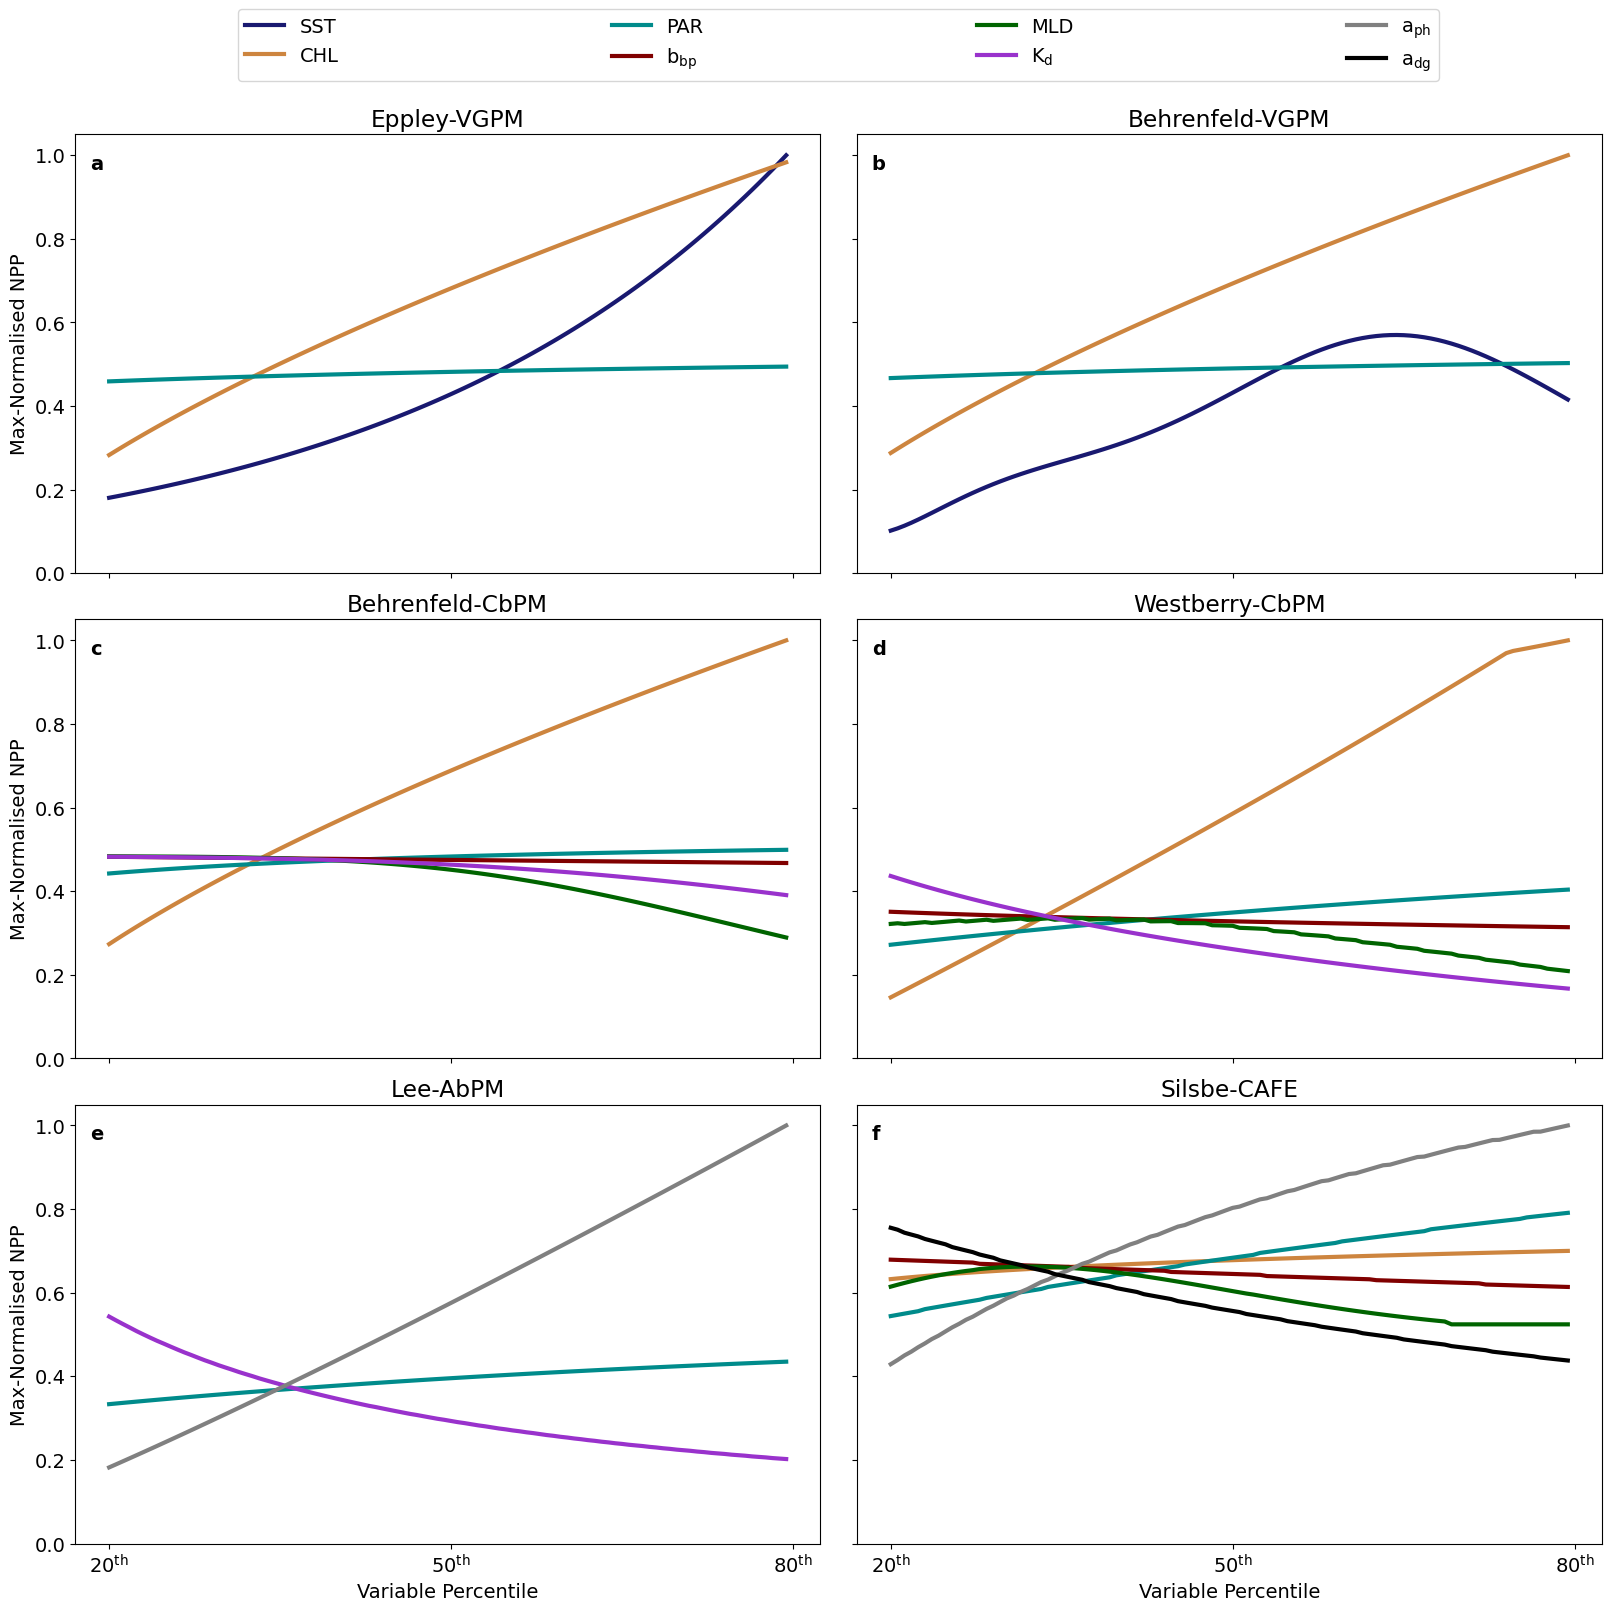

In [69]:
# Color dictionary for clarity
colors = {
    'sst': 'midnightblue', 
    'chl': 'peru', 
    'par': 'darkcyan', 
    'bbp': 'maroon', 
    'mld': 'darkgreen', 
    'kd': 'darkorchid', 
    'aph': 'grey', 
    'adg': 'black'
}

fig = plt.figure(figsize=[16, 16], constrained_layout=True)
gs = fig.add_gridspec(4, 2, height_ratios=[0.2, 1, 1, 1])  # 4 rows, 2 columns

# Define axes: top row (index 0) for legend, others start from the second row (index 1)
legend_ax = fig.add_subplot(gs[0, :])  # Legend axis spans both columns in the top row
axes = [fig.add_subplot(gs[i, j]) for i in range(1, 4) for j in range(2)]  # Regular axes from the second row onwards

# Unpack regular axes
ax0, ax1, ax2, ax3, ax4, ax5 = axes

# Data dictionary to loop through models
models_data = {
    'vgpm1': ['sst', 'chl', 'par'],
    'vgpm2': ['sst', 'chl', 'par'],
    'cbpm1': ['chl', 'par', 'bbp', 'mld', 'kd'],
    'cbpm2': ['chl', 'par', 'bbp', 'mld', 'kd'],
    'abpm': ['par', 'kd', 'aph'],
    'cafe': ['chl', 'par', 'bbp', 'mld', 'aph', 'adg']
}

# Plot data for each model in corresponding axes
for i, (model_name, variables) in enumerate(models_data.items()):
    ax = axes[i]
    norm_data = globals().get(f"{model_name}_norm", {})
    for var in variables:
        norm_data[var].plot(ax=ax, lw=3, legend=False, color=colors[var])

# Set common y-limits and xticks for all axes
for ax in axes:
    ax.set_ylim(0, 1.05)
    ax.set_xticks([0, 50, 100])
    ax.set_xticklabels('')

# Now set the x-tick labels to match the number of ticks
ax4.set_xticklabels(['20$^{th}$', '50$^{th}$', '80$^{th}$'])
ax5.set_xticklabels(['20$^{th}$', '50$^{th}$', '80$^{th}$'])

# Set x-labels
axes[4].set_xlabel('Variable Percentile')
axes[5].set_xlabel('Variable Percentile')

# Remove y-tick labels for some subplots
for ax in [ax1, ax3, ax5]:
    ax.set_yticklabels('')

# Set y-labels
axes[0].set_ylabel('Max-Normalised NPP')
axes[2].set_ylabel('Max-Normalised NPP')
axes[4].set_ylabel('Max-Normalised NPP')

# Create a legend dynamically based on color dictionary
legend_elements = [
    Line2D([0], [0], label='SST', color=colors['sst'], lw=3), 
    Line2D([0], [0], label='CHL', color=colors['chl'], lw=3),
    Line2D([0], [0], label='PAR', color=colors['par'], lw=3),
    Line2D([0], [0], label='b$_{bp}$', color=colors['bbp'], lw=3), 
    Line2D([0], [0], label='MLD', color=colors['mld'], lw=3),
    Line2D([0], [0], label='K$_d$', color=colors['kd'], lw=3), 
    Line2D([0], [0], label='a$_{ph}$', color=colors['aph'], lw=3),
    Line2D([0], [0], label='a$_{dg}$', color=colors['adg'], lw=3)
]

# Add the legend to a dedicated axes
legend_ax.axis('off')
legend_ax.legend(handles=legend_elements, loc='lower center', fontsize=14, 
                 ncol=4, mode='expand', bbox_to_anchor=(0.1, 0.1, 0.8, 0.1)) 

# Annotate each subplot with labels
subplot_labels = ['a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate(axes):
    ax.text(0.02, 0.92, subplot_labels[i], transform=ax.transAxes, fontsize=14, fontweight='bold')

# Set titles
titles = ['Eppley-VGPM', 'Behrenfeld-VGPM', 'Behrenfeld-CbPM', 'Westberry-CbPM', 'Lee-AbPM', 'Silsbe-CAFE']
for ax, title in zip(axes, titles):
    ax.set_title(title)

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_S08"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)

# Figure S9

## Load in data

In [70]:
fname = root_dir+'/DATA/NPP_RMSD.xlsx'
df = pd.read_excel(fname, skiprows=1, index_col=0)

## Plot the Figure

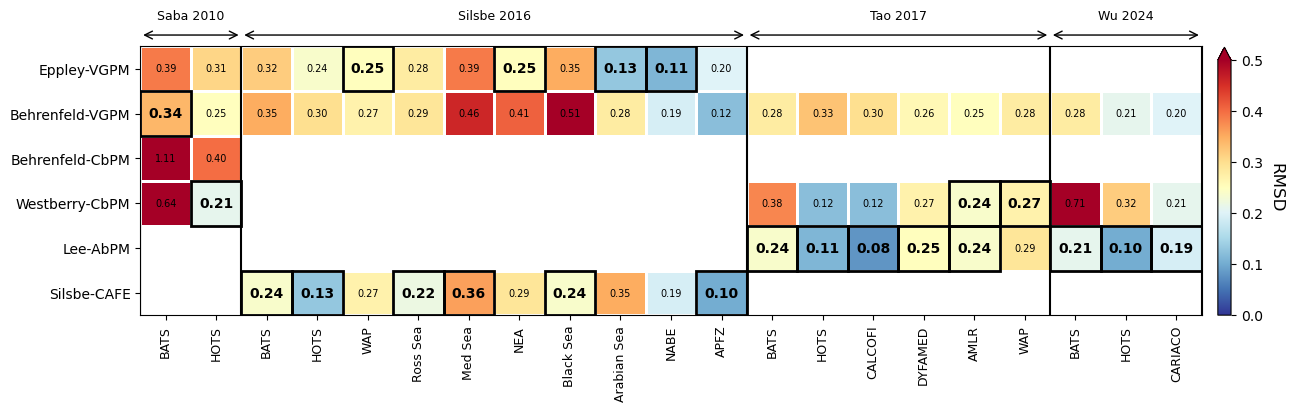

In [71]:

fig = plt.figure(figsize=[12, 4], constrained_layout=True)
gs = plt.GridSpec(1, 1, figure=fig)
ax0 = fig.add_subplot(gs[:, :])

im = ax0.pcolormesh(df, cmap='RdYlBu_r', vmin=0, vmax=0.5, edgecolors='w')

for j in range(df.shape[1]):
    min_value = df.iloc[:, j].min()  # Find the max value in the column
    for i in range(df.shape[0]):
        value = df.iloc[i, j]
        if not np.isnan(value):  # Check if the value is not np.nan
            fontweight = 'bold' if value == min_value else 'normal'
            fontsize = 10 if value == min_value else 7
            ax0.text(j + 0.5, i + 0.5, f'{value:.2f}',
                     ha='center', va='center', color='black', 
                     fontweight=fontweight, fontsize=fontsize)
            if value == min_value:
                rect = Rectangle((j, i), 1, 1, linewidth=2, edgecolor='black', facecolor='none')
                ax0.add_patch(rect)

ax0.axvline(0, c='k', lw=1.5)
ax0.axvline(2, c='k', lw=1.5)
ax0.axvline(12, c='k', lw=1.5)
ax0.axvline(18, c='k', lw=1.5)
ax0.axvline(21, c='k', lw=1.5)

ax0.set_ylim(6, 0)

ax0.text(1, -0.6, 'Saba 2010', ha='center', fontsize=9)
ax0.annotate(text='', xy=(0, -0.25), xytext=(2, -0.25), 
               arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
ax0.text(7, -0.6, 'Silsbe 2016', ha='center', fontsize=9)
ax0.annotate(text='', xy=(2, -0.25), xytext=(12, -0.25), 
               arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
ax0.text(15, -0.6, 'Tao 2017', ha='center', fontsize=9)
ax0.annotate(text='', xy=(12, -0.25), xytext=(18, -0.25), 
               arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
ax0.text(19.5, -0.6, 'Wu 2024', ha='center', fontsize=9)
ax0.annotate(text='', xy=(18, -0.25), xytext=(21, -0.25), 
               arrowprops=dict(arrowstyle='<->'), annotation_clip=False)

ax0.set_xticks(np.arange(0.5, 21.5, 1))
ax0.set_yticks(np.arange(0.5, 6.5, 1))
ax0.set_yticklabels(df.index, fontsize=10)
ax0.set_xticklabels(['BATS', 'HOTS',  'BATS', 'HOTS', 'WAP', 'Ross Sea', 'Med Sea', 'NEA', 'Black Sea',
       'Arabian Sea', 'NABE', 'APFZ', 'BATS', 'HOTS', 'CALCOFI',
       'DYFAMED', 'AMLR', 'WAP', 'BATS', 'HOTS', 'CARIACO'], rotation=90, fontsize=9)

cbar_ax = fig.add_axes([1.01, 0.225, 0.011, 0.67])
cbar = fig.colorbar(im, cax=cbar_ax, extend='max')
cbar.set_label('RMSD', rotation=270, labelpad=15, fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_S09"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)

# Figure S10

## Load in data

In [72]:
# Function to load datasets
def load_dataset(file_path):
    return xr.open_dataset(file_path)

# Function to calculate Coefficient of Variation (CV)
def calculate_cv(dataset, var_name):
    return dataset[var_name].std('simulation') / dataset[var_name].mean('simulation')

# Function to calculate KDE and normalize
def calculate_kde(ds, vmin, vmax):
    kde_plot = ds.Slope.plot.kde(ind=np.linspace(vmin, vmax, 1000))
    x_vals = kde_plot.lines[0].get_xdata()
    y_vals = kde_plot.lines[0].get_ydata()
    y_vals = y_vals / max(y_vals)  # Normalize
    plt.close()
    return pd.Series(y_vals, index=x_vals)

# Function to process the jackknife datasets
def process_jackknife_data(jackknife_ds, vmin, vmax, mask):
    kde_list = []
    for i in tqdm(range(7)):
        ds = jackknife_ds.where(mask.compute(), drop=True).sel(simulation=i).Slope.to_series().dropna().reset_index()
        kde_vals = calculate_kde(ds, vmin, vmax)
        kde_list.append(kde_vals)
    return pd.concat(kde_list, axis=1)

def convert_slope(slope, pixel_area_m2):
    """Convert slope from mg C m-2 d-1 year-1 to Gg C year-1."""
    return (slope / 1e3 * pixel_area_m2 * 365) * 1e-9

def calculate_pixel_area(xds, km_per_degree=111.1, m_per_km=1000):
    """Calculate the pixel area in m² for the given xarray dataset."""
    degrees_per_pixel = 180 / xds.lat.shape[0]
    pixel_area_equator_km2 = (degrees_per_pixel * km_per_degree) ** 2
    lat_rad = np.radians(xds['lat'])
    pixel_area = np.cos(lat_rad) * pixel_area_equator_km2
    pixel_area_2d = pixel_area.broadcast_like(xds)
    return pixel_area_2d * m_per_km**2  # Convert to m²

# File paths
statsdir = root_dir + '/DATA/STATS/TRENDS'
biomes_file = root_dir + '/DATA/Time_Varying_Biomes_25KM.nc'

# Open datasets
biomes = load_dataset(biomes_file)

models = ['VGPM1', 'VGPM2', 'CBPM1', 'CBPM2', 'CAFE', 'ABPM']
datasets = {model: load_dataset(statsdir + f'/{model}_GLOBAL_ANNUAL_MEAN_TRENDS.nc') for model in models}

pixel_area_m2 = calculate_pixel_area(datasets['VGPM1'].Slope)

# Convert units of slope
for model in models:
    datasets[model]['Slope'] = convert_slope(datasets[model]['Slope'], pixel_area_m2)

# Jackknife datasets
jackknife_datasets = {model: load_dataset(statsdir + f'/JACKKNIFE/{model}_GLOBAL_ANNUAL_MEAN_TRENDS_JACKKNIFE.nc') for model in models}

# Add absolute slopes for jackknife datasets and convert units of slope
for model in models:
    jackknife_datasets[model]['Slope'] = convert_slope(jackknife_datasets[model]['Slope'], pixel_area_m2)
    jackknife_datasets[model]['Slope_abs'] = abs(jackknife_datasets[model]['Slope'])

# Calculate CV for each model
model_cv = {model: calculate_cv(jackknife_datasets[model], 'Slope_abs') for model in models}

# KDEs for the datasets where P-value < 0.05
vmin, vmax = -6, 6
model_kde = {}

for model in models:
    ds = datasets[model].where(datasets[model].Pval < 0.05, drop=True).Slope.to_series().dropna().reset_index()
    model_kde[model] = calculate_kde(ds, vmin, vmax)
    
    # Process jackknife KDEs
    mask = jackknife_datasets[model].Pval < 0.05
    model_jackknife_kde = process_jackknife_data(jackknife_datasets[model], vmin, vmax, mask)
    
    model_kde[model + '_jackknife'] = model_jackknife_kde

# Now model_kde contains the KDE for each model (both original and jackknife)

100%|██████████| 7/7 [00:18<00:00,  2.58s/it]


## Plot the Figure

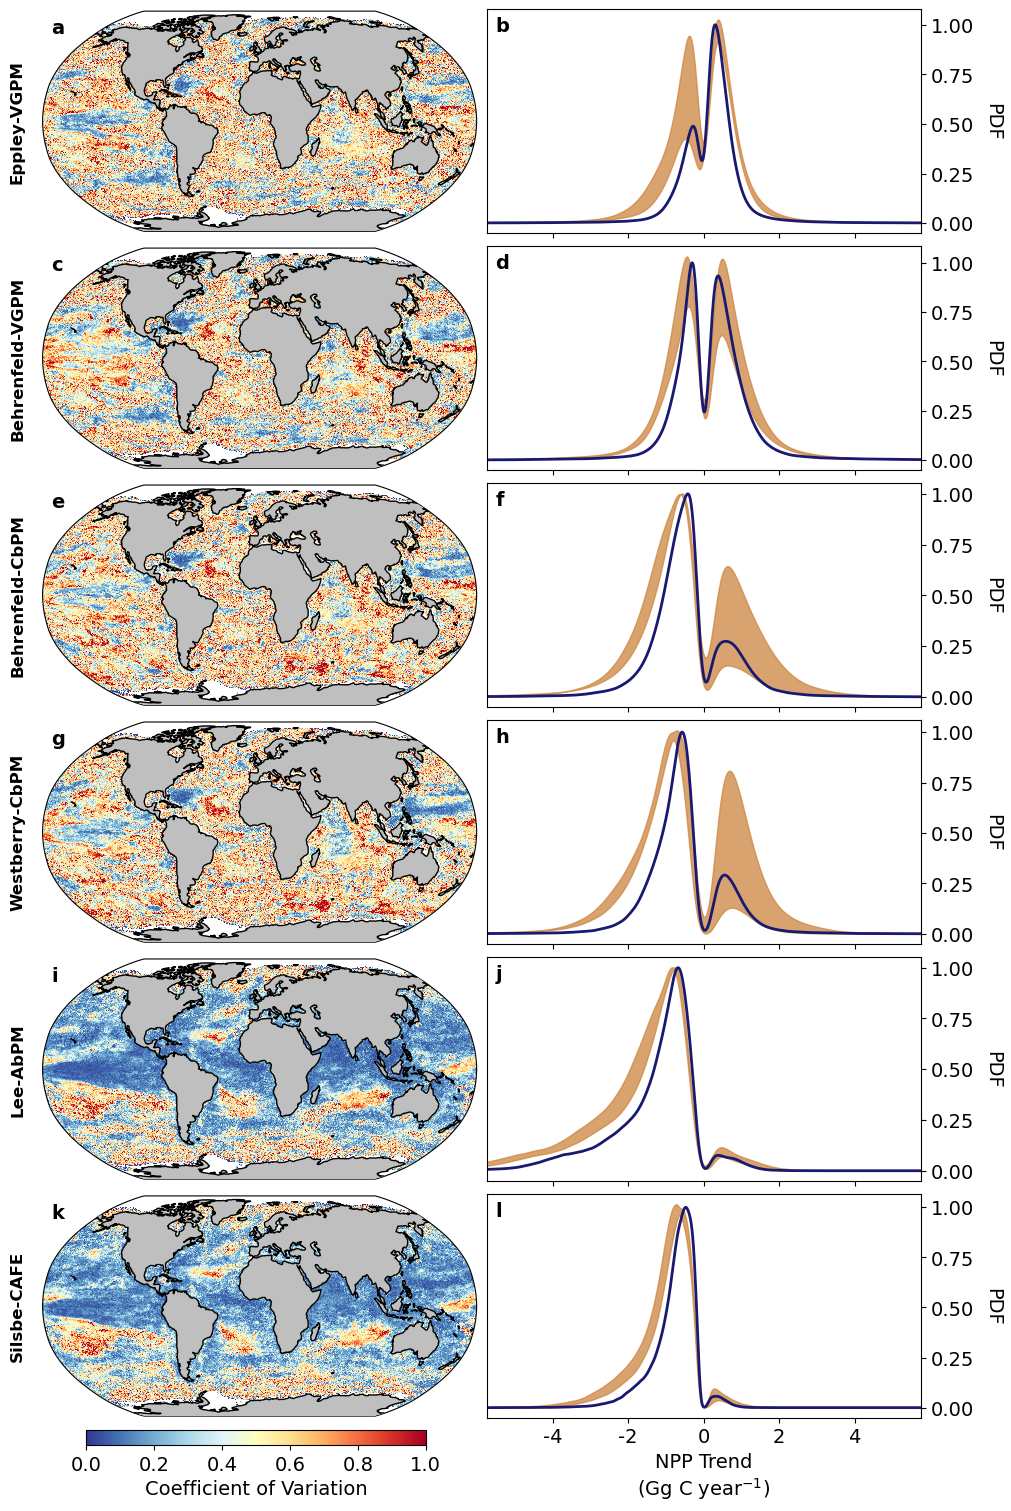

In [74]:
# Define a function for plotting model data and its jackknife uncertainty bands
def plot_kde_data(ax, model_data, model_jackknife, color, fill_color, vmin, vmax):
    model_data.plot(ax=ax, lw=2, color=color)
    kmn = model_jackknife.mean(axis=1)
    kst = model_jackknife.std(axis=1)
    x = model_data.index
    ax.fill_between(x, kmn - kst, kmn + kst, color=fill_color, alpha=0.75)
    ax.set_xlim(vmin, vmax)
    ax.set_ylabel('PDF', rotation=270, labelpad=20)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_xticklabels('')

# Define colors
colors = ['midnightblue', 'peru', 'darkcyan', 'maroon', 'darkgreen', 'darkorchid']

# Create the figure and grid specification
fig = plt.figure(figsize=[10, 15], constrained_layout=True)
gs = plt.GridSpec(6, 2, figure=fig)  # 6 rows, 2 columns

# Create subplots with different projections or no projection
axes = [[None for _ in range(2)] for _ in range(6)]  # Create a 6x2 list for axes

for row in range(6):
    for col in range(2):
        if col == 0:
            # Create a Cartopy map subplot with Robinson projection for the first column
            ax = fig.add_subplot(gs[row, col], projection=ccrs.Robinson())
            ax.add_feature(cartopy.feature.LAND, facecolor='0.75', zorder=5)
            ax.add_feature(cartopy.feature.COASTLINE, linewidth=1, zorder=5)
            ax.set_global()
            axes[row][col] = ax  # Save the axis in the list
        else:
            # Create a standard subplot for the second column
            ax = fig.add_subplot(gs[row, col])
            axes[row][col] = ax  # Save the axis in the list

# Set color limits and colormap for the maps
vmin = 0
vmax = 1
cmap = 'RdYlBu_r'

# Plot model data on the first column (maps)
for i, model in enumerate(['VGPM1', 'VGPM2', 'CBPM1', 'CBPM2', 'ABPM', 'CAFE']):
    im = model_cv[model].plot(ax=axes[i][0], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

# Set limits and color for the second column (PDFs and uncertainty bands)
vmin = -5.75
vmax = 5.75
for i, model in enumerate(['VGPM1', 'VGPM2', 'CBPM1', 'CBPM2', 'ABPM', 'CAFE']):
    plot_kde_data(
        axes[i][1],
        model_kde[model],
        model_kde[f'{model}_jackknife'],
        colors[0],
        colors[1],
        vmin,
        vmax
    )
    if i == 5:
        axes[i][1].set_xlabel('NPP Trend\n(Gg C year$^{-1}$)')
        axes[i][1].set_xticks(np.arange(-4, 6, 2))
        axes[i][1].set_xticklabels(np.arange(-4, 6, 2))
        

# Add colorbar for the maps
cbar_ax = fig.add_axes([0.08, 0.04, 0.34, 0.01])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Coefficient of Variation')

# Add subplot labels (a, b, c, ...)
subplot_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']
for i, label in enumerate(subplot_labels):
    row, col = divmod(i, 2)
    axes[row][col].text(0.02, 0.90, label, transform=axes[row][col].transAxes, fontsize=14, fontweight='bold')

# Add model names to the side
model_names = [
    'Eppley-VGPM', 'Behrenfeld-VGPM', 'Behrenfeld-CbPM', 'Westberry-CbPM',
    'Lee-AbPM', 'Silsbe-CAFE'
]
for i, model_name in enumerate(model_names):
    axes[i][0].text(-0.075, 0.5, model_name, rotation=90, va='center', transform=axes[i][0].transAxes, fontsize=12, fontweight='bold')

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_S10"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)

# Figure S11

## Load in Driver Trends

In [75]:
# List of models
models = ['ACCESS-ESM1-5', 'CESM2-WACCM', 'CESM2', 'CMCC-ESM2', 'CNRM-ESM2-1',  
          'CanESM5', 'EC-Earth3-CC', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 
          'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL']

# Directory paths
cmip_dir = root_dir + '/DATA/STATS/CMIP6_TRENDS/CONTEMPORARY'
satellite_dir = root_dir + '/DATA/STATS/VARIABLE_TRENDS'

# Define a function to load data for each variable
def load_cmip_data(variable, data_dir, models, file_pattern="*.nc"):
    fname = f"{data_dir}/{variable}/{file_pattern}"
    flist = sorted(glob.glob(fname))
    return xr.open_mfdataset(flist, combine='nested', concat_dim=xr.DataArray(models, dims='model', name='model'))

def load_satellite_data(data_dir, file_name):
    fname = f"{data_dir}/{file_name}"
    return xr.open_dataset(fname)

# CMIP6 data for SST, CHL, MLD
cmip_sst = load_cmip_data('SST', cmip_dir, models)
cmip_chl = load_cmip_data('CHL', cmip_dir, models)
cmip_mld = load_cmip_data('MLD', cmip_dir, models)

# Satellite data for SST, CHL, MLD
sat_sst = load_satellite_data(satellite_dir, 'SST_ANNUAL_MEAN_TRENDS.nc')
sat_chl = load_satellite_data(satellite_dir, 'CHL_ANNUAL_MEAN_TRENDS.nc')
sat_mld = load_satellite_data(satellite_dir, 'MLD_ANNUAL_MEAN_TRENDS.nc')

# Latitude slice selection (for both CMIP6 and satellite data)
def select_latitude(data, lat_slice=slice(-80, 80)):
    return data.sel(lat=lat_slice)

# Apply latitude selection
sat_sst = select_latitude(sat_sst)
cmip_sst = select_latitude(cmip_sst)
sat_chl = select_latitude(sat_chl)
cmip_chl = select_latitude(cmip_chl)
sat_mld = select_latitude(sat_mld)
cmip_mld = select_latitude(cmip_mld)

## Plot the Figure

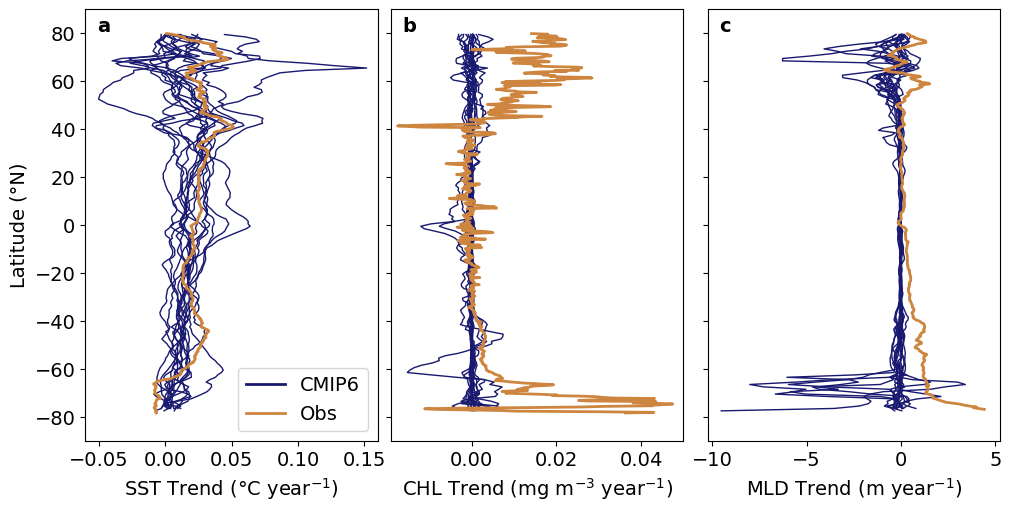

In [76]:
# Function to plot the trends
def plot_trends(ax, cmip_data, sat_data, models, color_cmip, color_sat, ylabel, xlabel, xlim, ylim, label_suffix):
    # Plot CMIP6 data for each model
    for m in models:
        x = cmip_data.mean('lon').Slope.sel(model=m).values
        ax.plot(x, cmip_data.lat, color=color_cmip, lw=1)
    
    # Plot Satellite data (only where Pval < 0.05)
    x = sat_data.where(sat_data.Pval < 0.05).mean(['lon']).Slope.values
    ax.plot(x, sat_data.lat, color=color_sat, lw=2)

    # Set axis limits and labels
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Remove y-tick labels for the top two subplots
    if ax != ax0:
        ax.set_yticklabels('')

    # Add subplot label
    ax.text(.04, 0.95, label_suffix, transform=ax.transAxes, fontsize=14, fontweight='bold')

# Colors for plotting
colors = ['midnightblue', 'peru', 'darkcyan', 'maroon', 'darkgreen', 'indigo']

# Create figure and GridSpec layout
fig = plt.figure(figsize=[10, 5], constrained_layout=True)
gs = plt.GridSpec(1, 3, figure=fig)
ax0 = fig.add_subplot(gs[:, :1])
ax1 = fig.add_subplot(gs[:, 1:2])
ax2 = fig.add_subplot(gs[:, 2:])

# Plot trends for SST, CHL, and MLD
plot_trends(ax0, cmip_sst, sat_sst, models, colors[0], colors[1], 
            ylabel='Latitude (°N)', xlabel='SST Trend (°C year$^{-1}$)', 
            xlim=(-0.06, 0.16), ylim=(-90, 90), label_suffix='a')

plot_trends(ax1, cmip_chl, sat_chl, models, colors[0], colors[1], 
            ylabel='', xlabel='CHL Trend (mg m$^{-3}$ year$^{-1}$)', 
            xlim=(-0.019, 0.05), ylim=(-90, 90), label_suffix='b')

plot_trends(ax2, cmip_mld, sat_mld, models, colors[0], colors[1], 
            ylabel='', xlabel='MLD Trend (m year$^{-1}$)', 
            xlim=(-10.25, 5.25), ylim=(-90, 90), label_suffix='c')

# Create legend
legend_elements = [Line2D([0], [0], label='CMIP6', color=colors[0], lw=2), 
                   Line2D([0], [0], label='Obs', color=colors[1], lw=2)]
ax0.legend(handles=legend_elements, loc=4)

# Save the figure
output_filename = f"{figdir}/GLOBAL_NPP_TRENDS_FIGURE_S11"
fig.savefig(f"{output_filename}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{output_filename}.jpg", bbox_inches='tight', dpi=300)